In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scanpy.api as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
sc.logging.print_versions()
results_file = './write/p16.h5ad'


/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.2.2+145.g8360b3b anndata==0.6.8 numpy==1.14.3 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Load data

In [ ]:
# adata_raw = read_h5ad('./write/maca.h5ad')


In [3]:
adata = read_h5ad('./write/maca.processed.h5ad')

# Preprocessing

In [ ]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_genes=250)

In [ ]:
adata

In [ ]:
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1

In [ ]:
adata

In [ ]:
axs = sc.pl.violin(adata, ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

In [ ]:
ax = sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata.raw = sc.pp.log1p(adata, copy=True) # freezes the state of the AnnData object returned by sc.pp.log1p
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #simple lib size normalization?

In [ ]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=10, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [ ]:
adata = adata[:, filter_result.gene_subset]

In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.scale(adata, max_value=10)

In [ ]:
#adata.write(results_file)

# Exploration


## Choose a tissue

In [4]:
tissues_available = list(set(adata.obs['Tissue']))
tissues_available.sort()
pd.DataFrame(tissues_available,columns=['Tissues'])

Tissues
0      Aorta
1    Bladder
2      Brain
3        Fat
4      Heart
5     Kidney
6      Liver
7       Lung
8    Mammary
9     Marrow
10    Muscle
11  Pancreas
12      Skin
13    Spleen
14    Thymus
15    Tongue
16   Trachea

In [17]:
tissofinterest = tissues_available[4]#"Trachea"
tiss = adata[adata.obs['Tissue'] == tissofinterest,:]



In [18]:
# tiss2 = tiss.obs[tiss.obs['Age'] == '3m']
# tiss3 = tiss.obs[tiss.obs['Age'] == '24m']
# tiss4 = tiss.obs[tiss.obs['Age'] == '18m']
# tiss5 = tiss.obs[tiss.obs['Age'] == '21m']

In [19]:
# tiss

In [20]:
# tissaux = tiss2.append(tiss3)
# tissaux = tissaux.append(tiss4)
# tissaux = tissaux.append(tiss5)
# tiss = adata[adata.obs.index.isin(tissaux.index),:]

In [21]:
tiss

View of AnnData object with n_obs × n_vars = 5182 × 2202 
    obs: 'Tissue', 'subTissue', 'Age', 'Sex', 'n_genes', 'Channel', 'Cell_Ontology_Type', 'batch', 'Cell', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'Age_colors', 'Sex_colors', 'Tissue_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

## PCA

In [22]:
sc.tl.pca(tiss)

In [23]:
tiss

AnnData object with n_obs × n_vars = 5182 × 2202 
    obs: 'Tissue', 'subTissue', 'Age', 'Sex', 'n_genes', 'Channel', 'Cell_Ontology_Type', 'batch', 'Cell', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'Age_colors', 'Sex_colors', 'Tissue_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

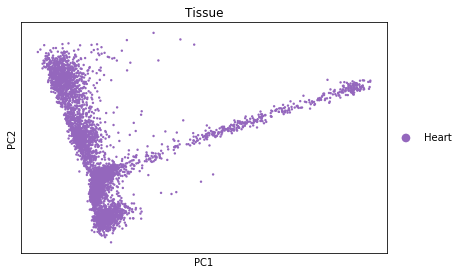

In [24]:
ax = sc.pl.pca_scatter(tiss, color=['Tissue'], right_margin=0.5)

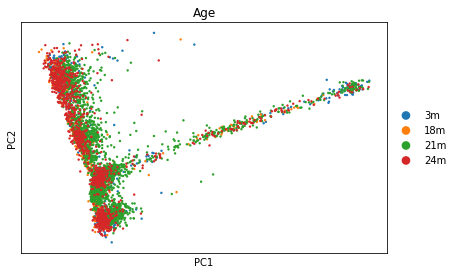

In [25]:
ax = sc.pl.pca_scatter(tiss, color=['Age'], right_margin=0.5)

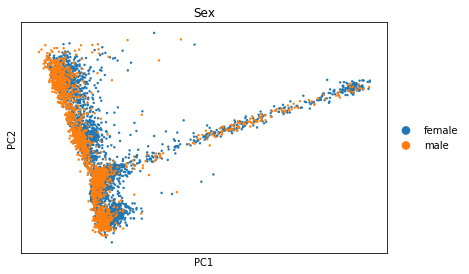

In [26]:
ax = sc.pl.pca_scatter(tiss, color=['Sex'], right_margin=0.5)

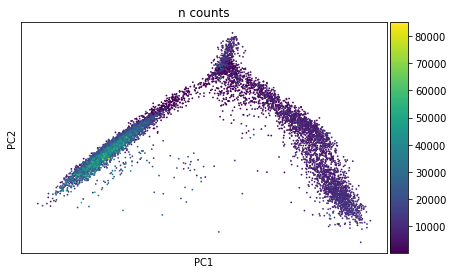

In [15]:
ax = sc.pl.pca_scatter(tiss, color='n_counts', right_margin=0.5)

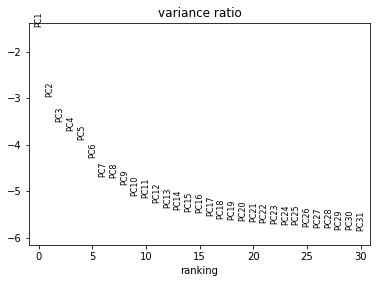

In [16]:
sc.pl.pca_variance_ratio(tiss, log=True)

## Louvain clustering

In [28]:
sc.pp.neighbors(tiss, n_neighbors=15)#, method='gauss')
sc.tl.louvain(tiss, resolution = 0.2)

/home/ubuntu/maca-scanpy/scanpy/scanpy/neighbors/__init__.py:134: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(distances)


In [29]:
tiss

AnnData object with n_obs × n_vars = 5182 × 2202 
    obs: 'Tissue', 'subTissue', 'Age', 'Sex', 'n_genes', 'Channel', 'Cell_Ontology_Type', 'batch', 'Cell', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'Age_colors', 'Sex_colors', 'Tissue_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

## UMAP

In [30]:
sc.tl.umap(tiss)

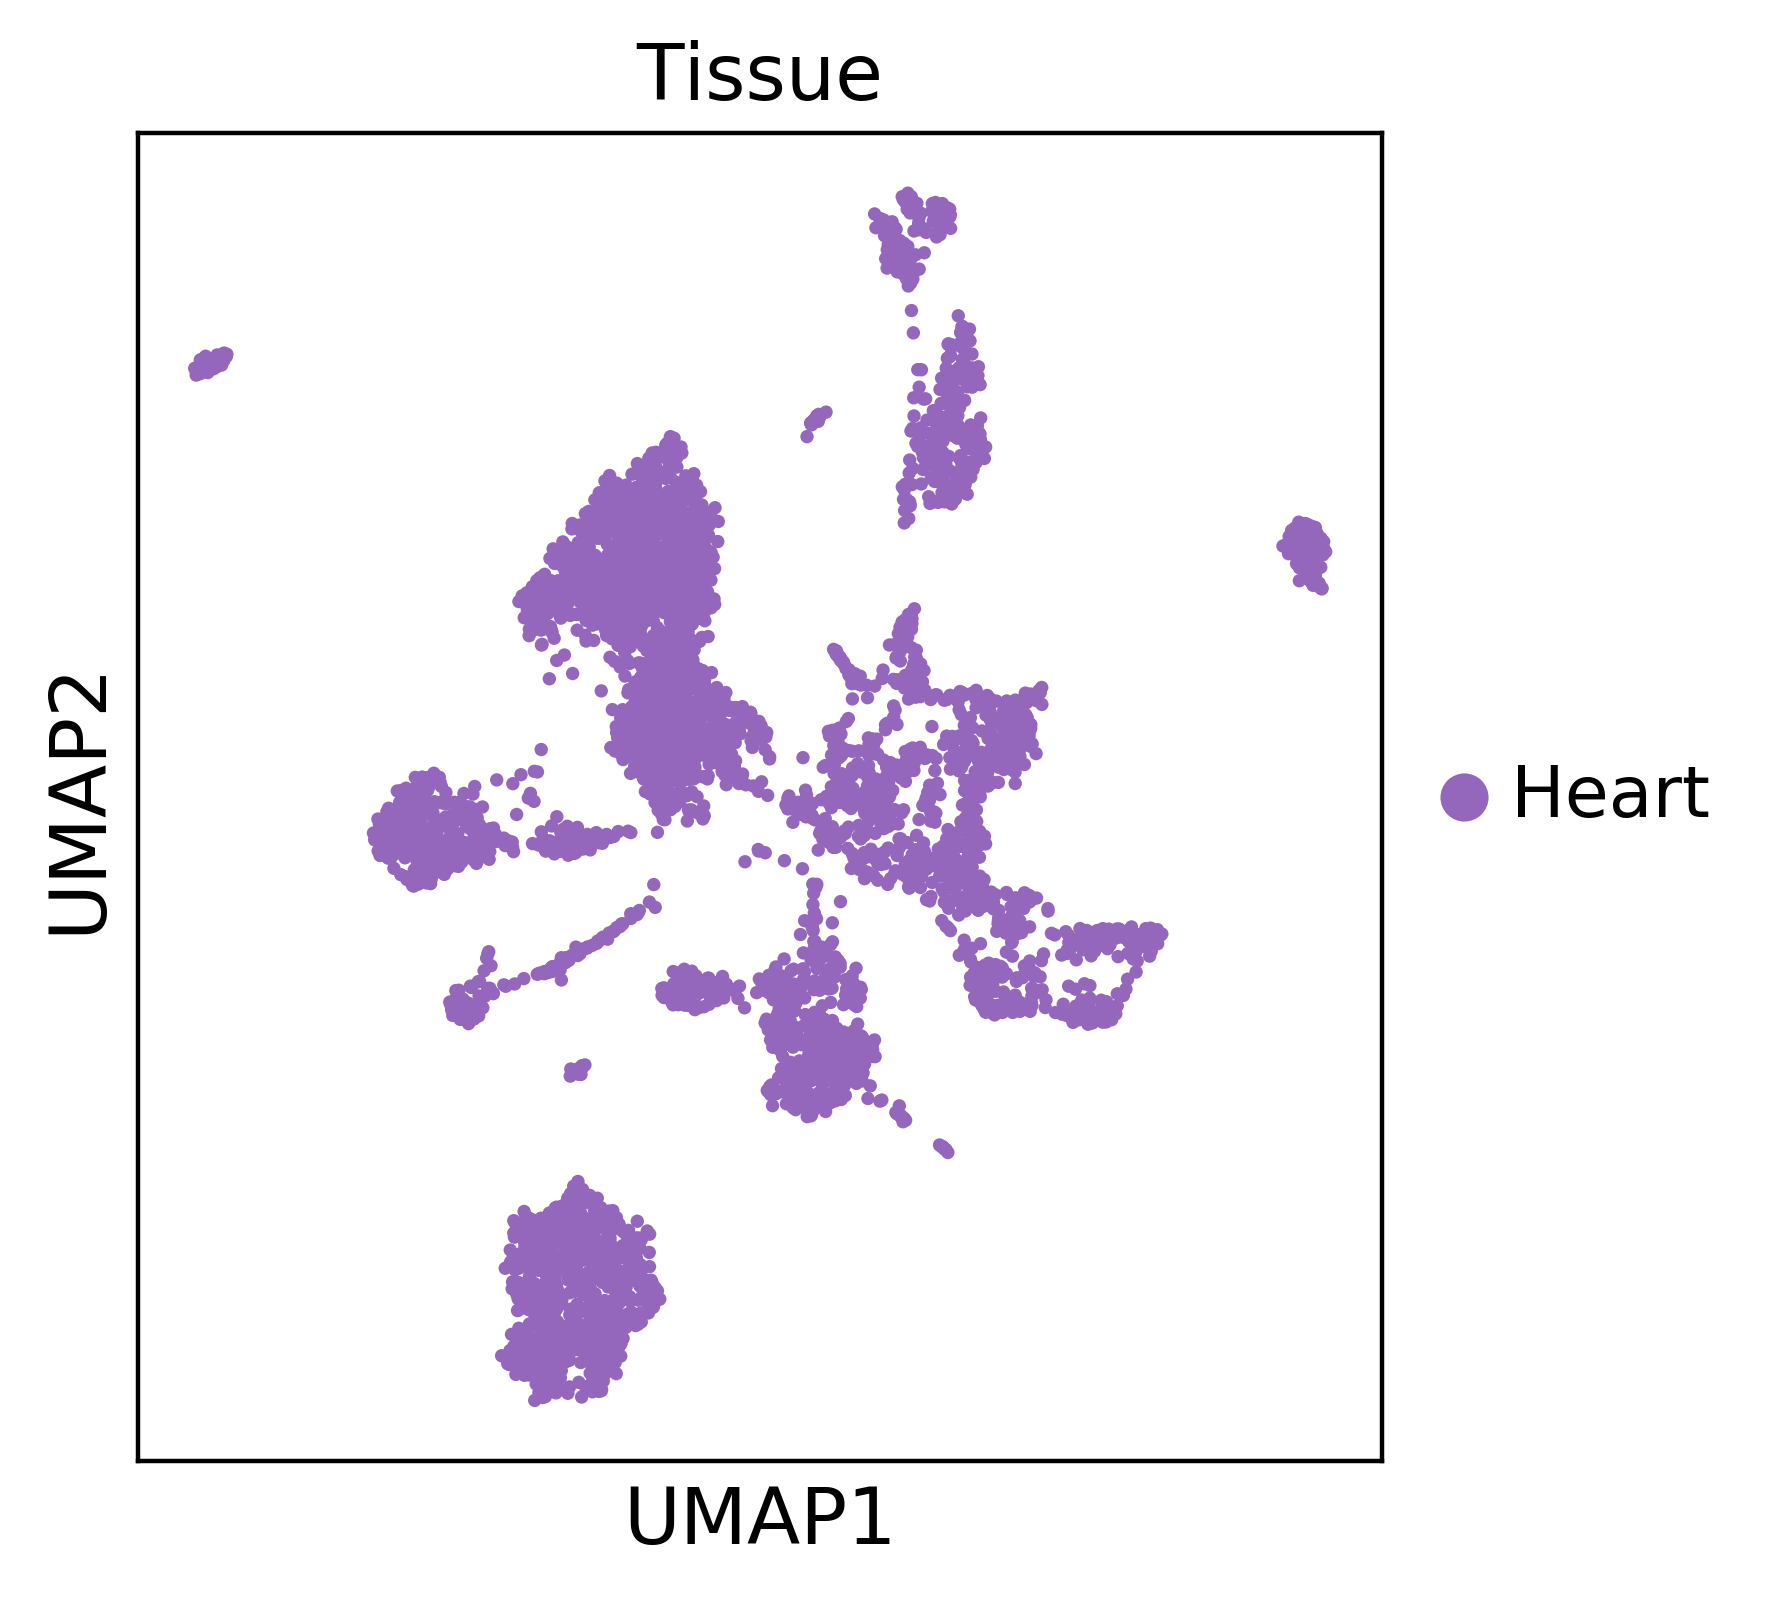

In [31]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['Tissue'], right_margin=0.5)

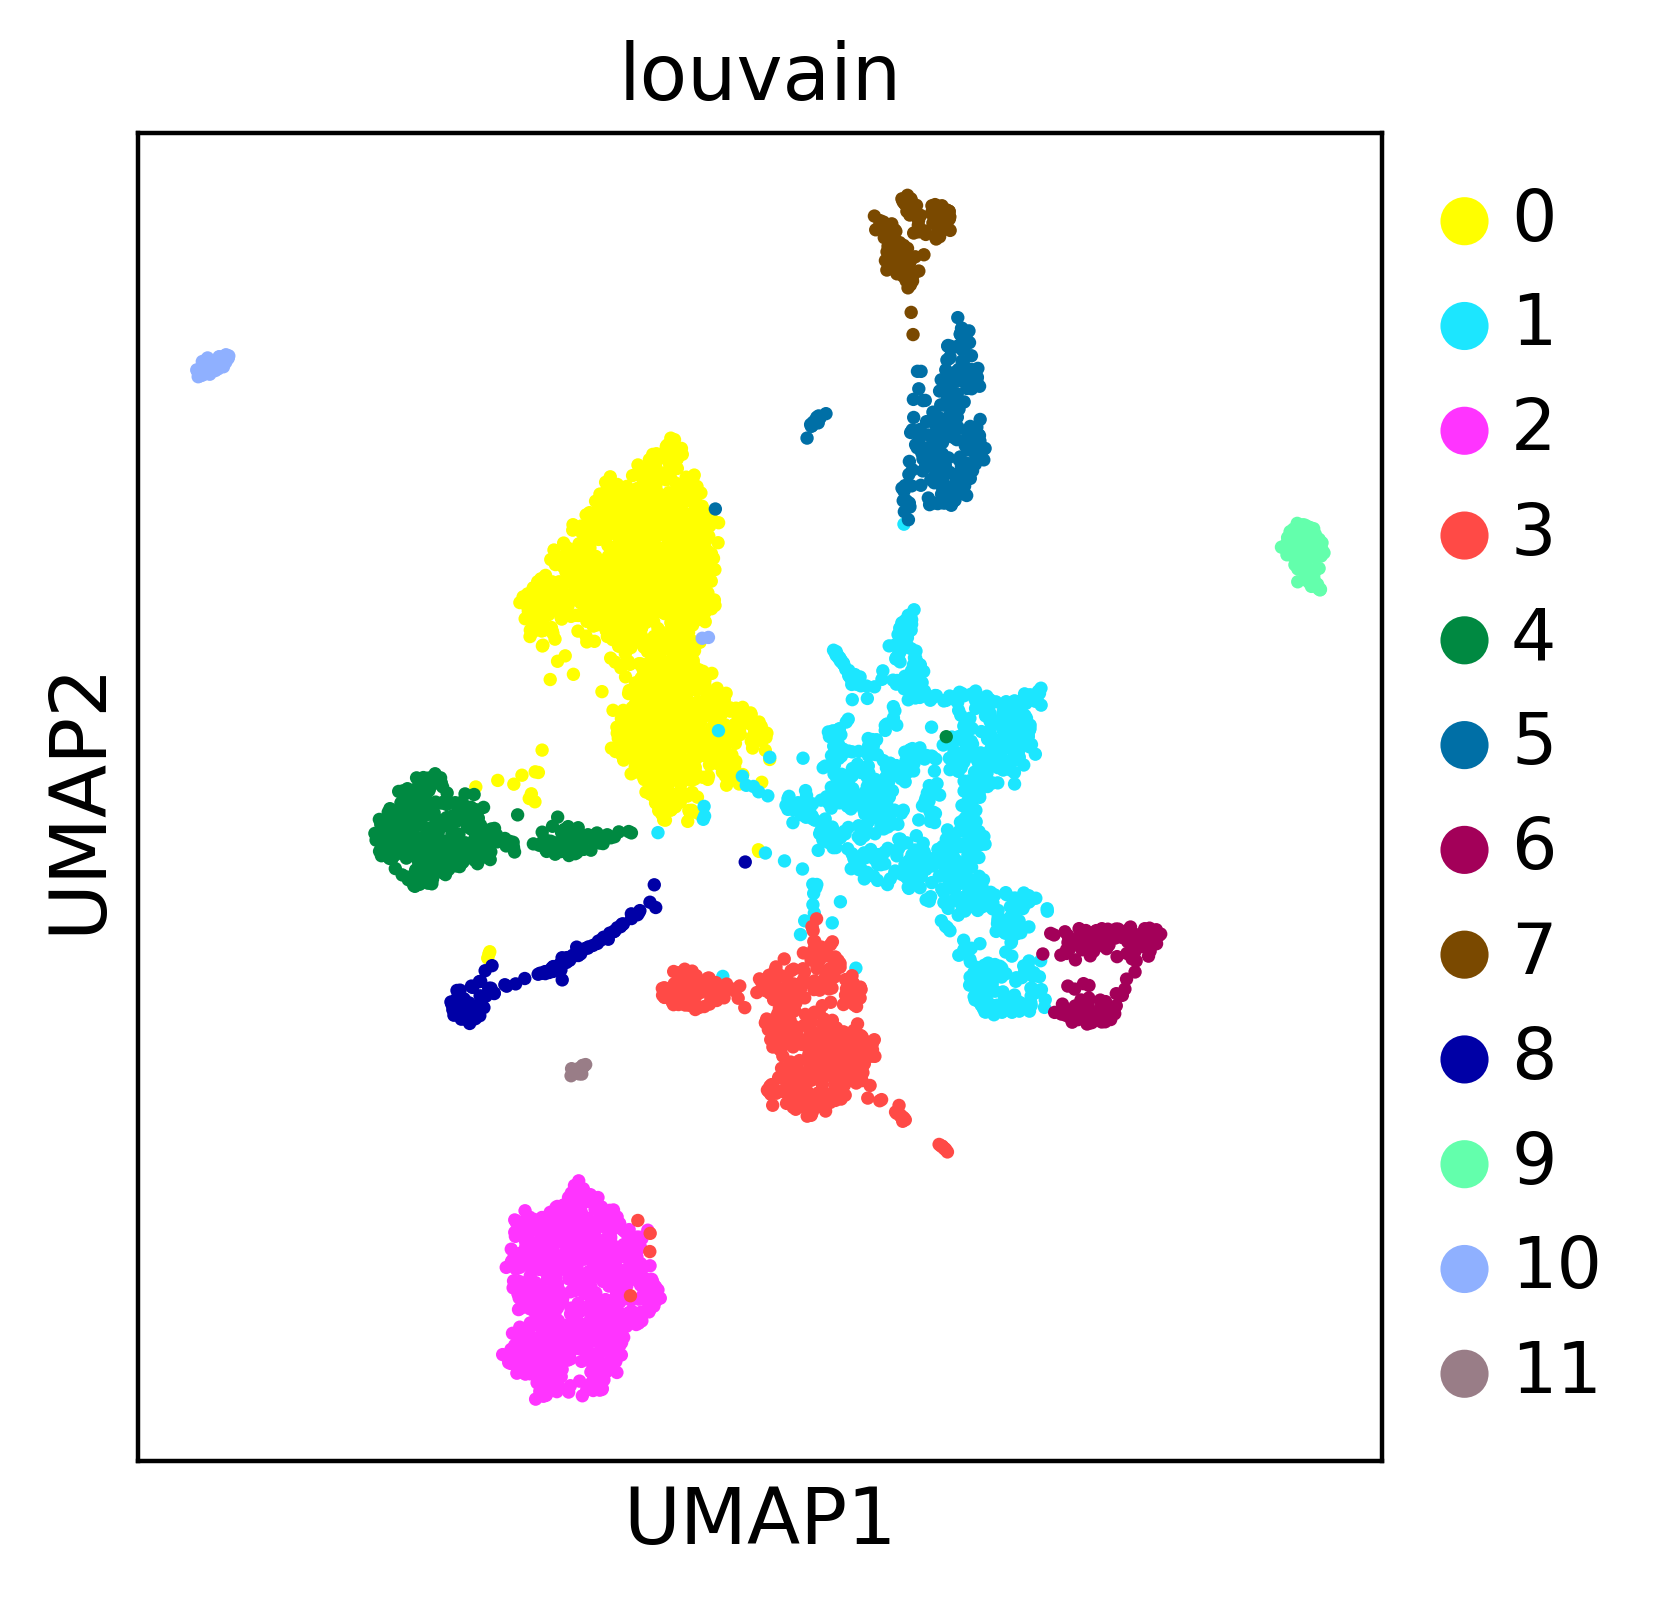

In [32]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['louvain'], right_margin=0.5)

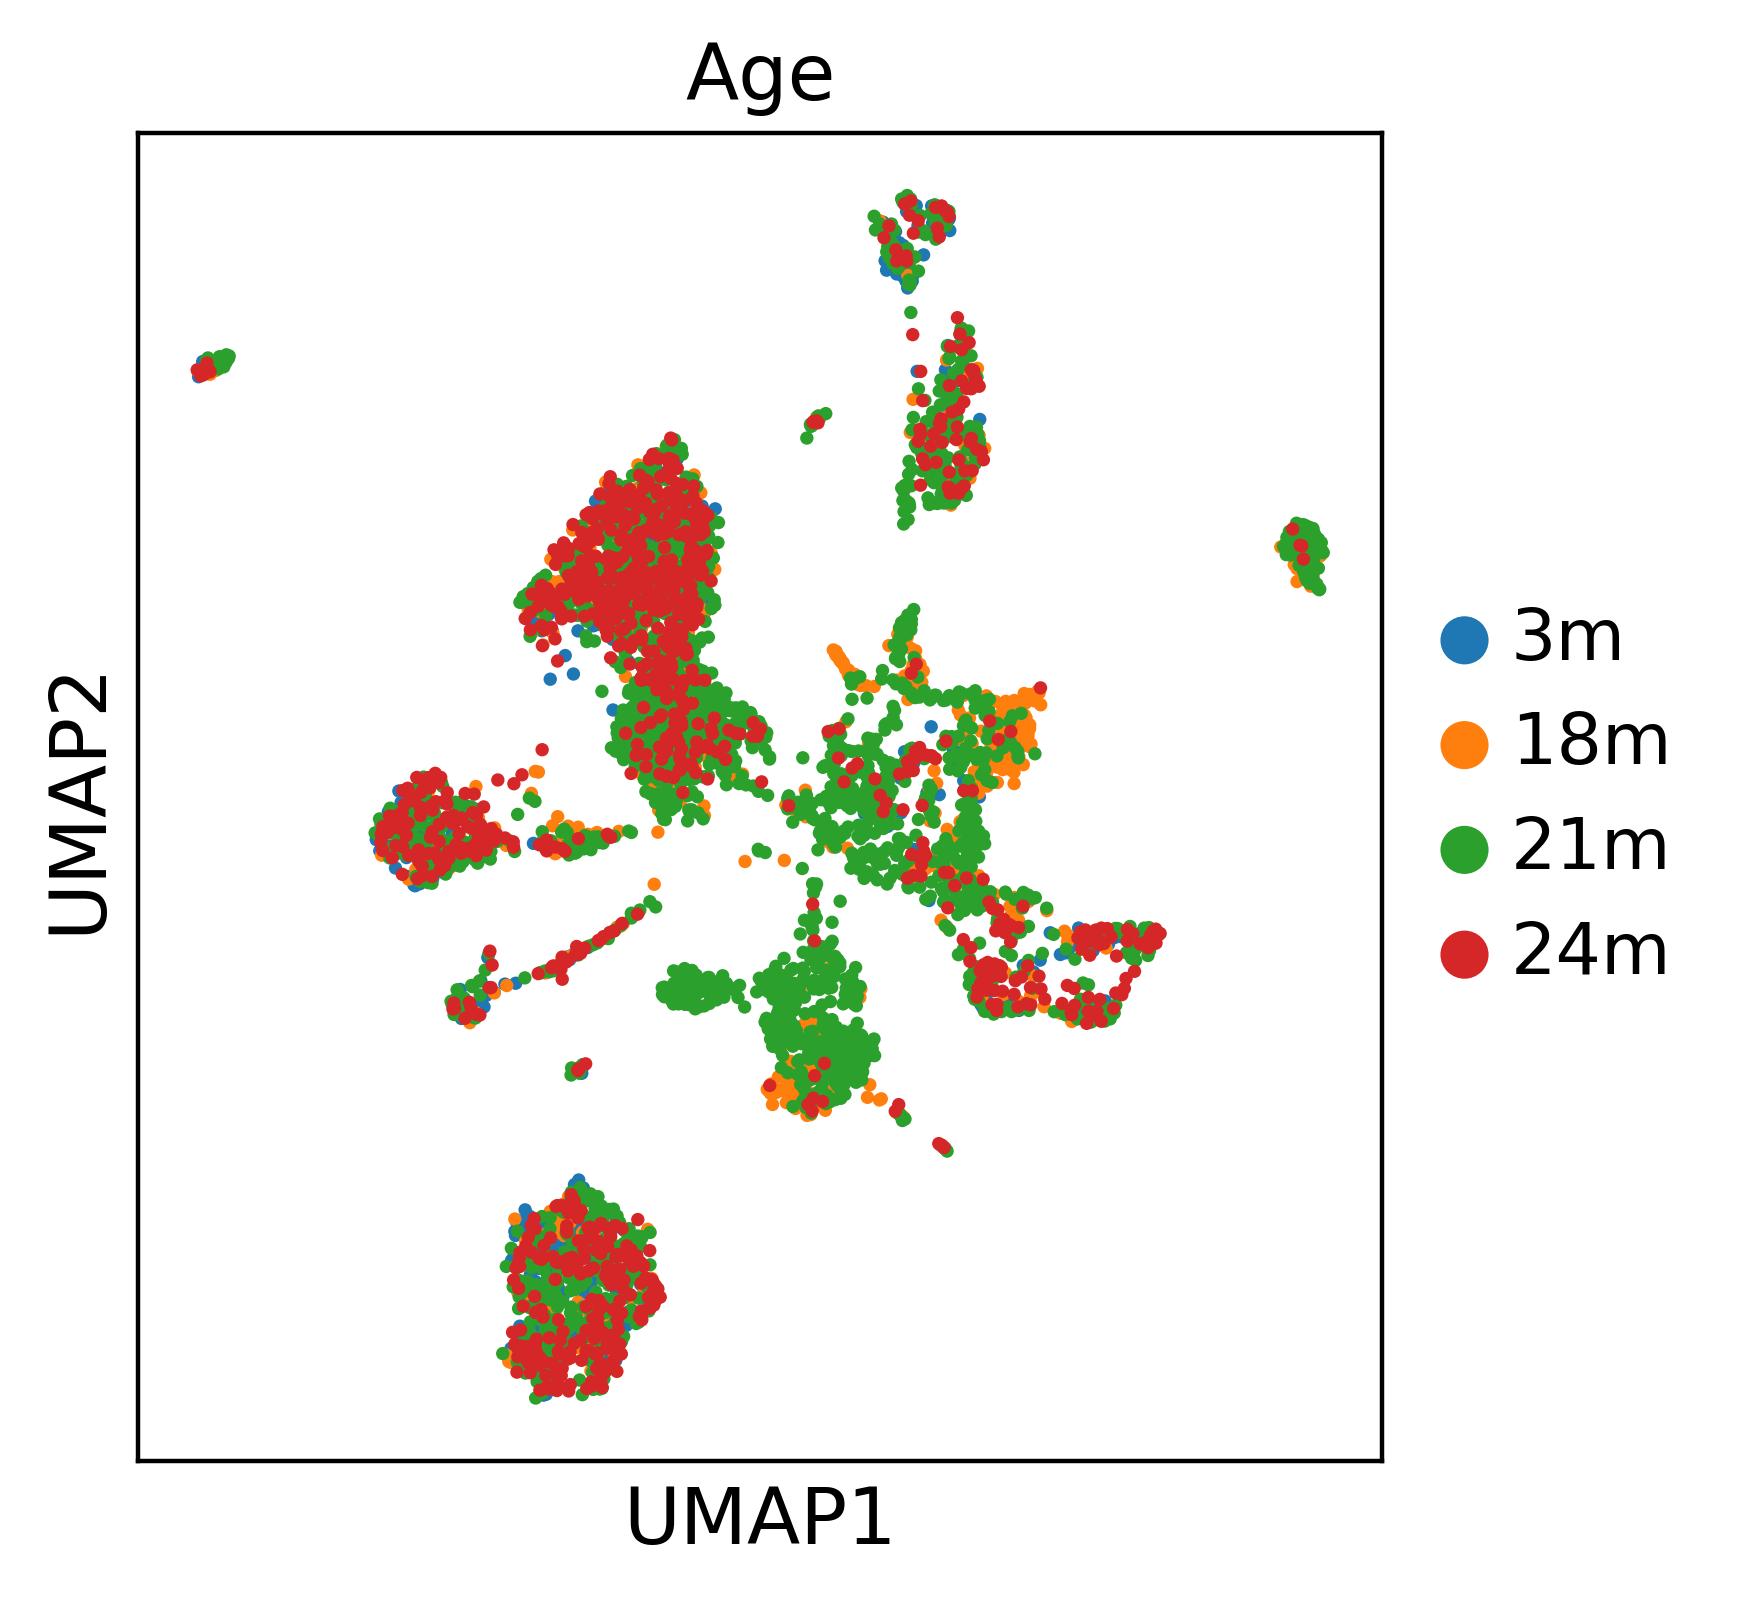

In [33]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['Age'], right_margin=0.5)

## tSNE

In [50]:
sc.tl.tsne(tiss, perplexity=50)

... storing 'cell_ontology_class' as categorical


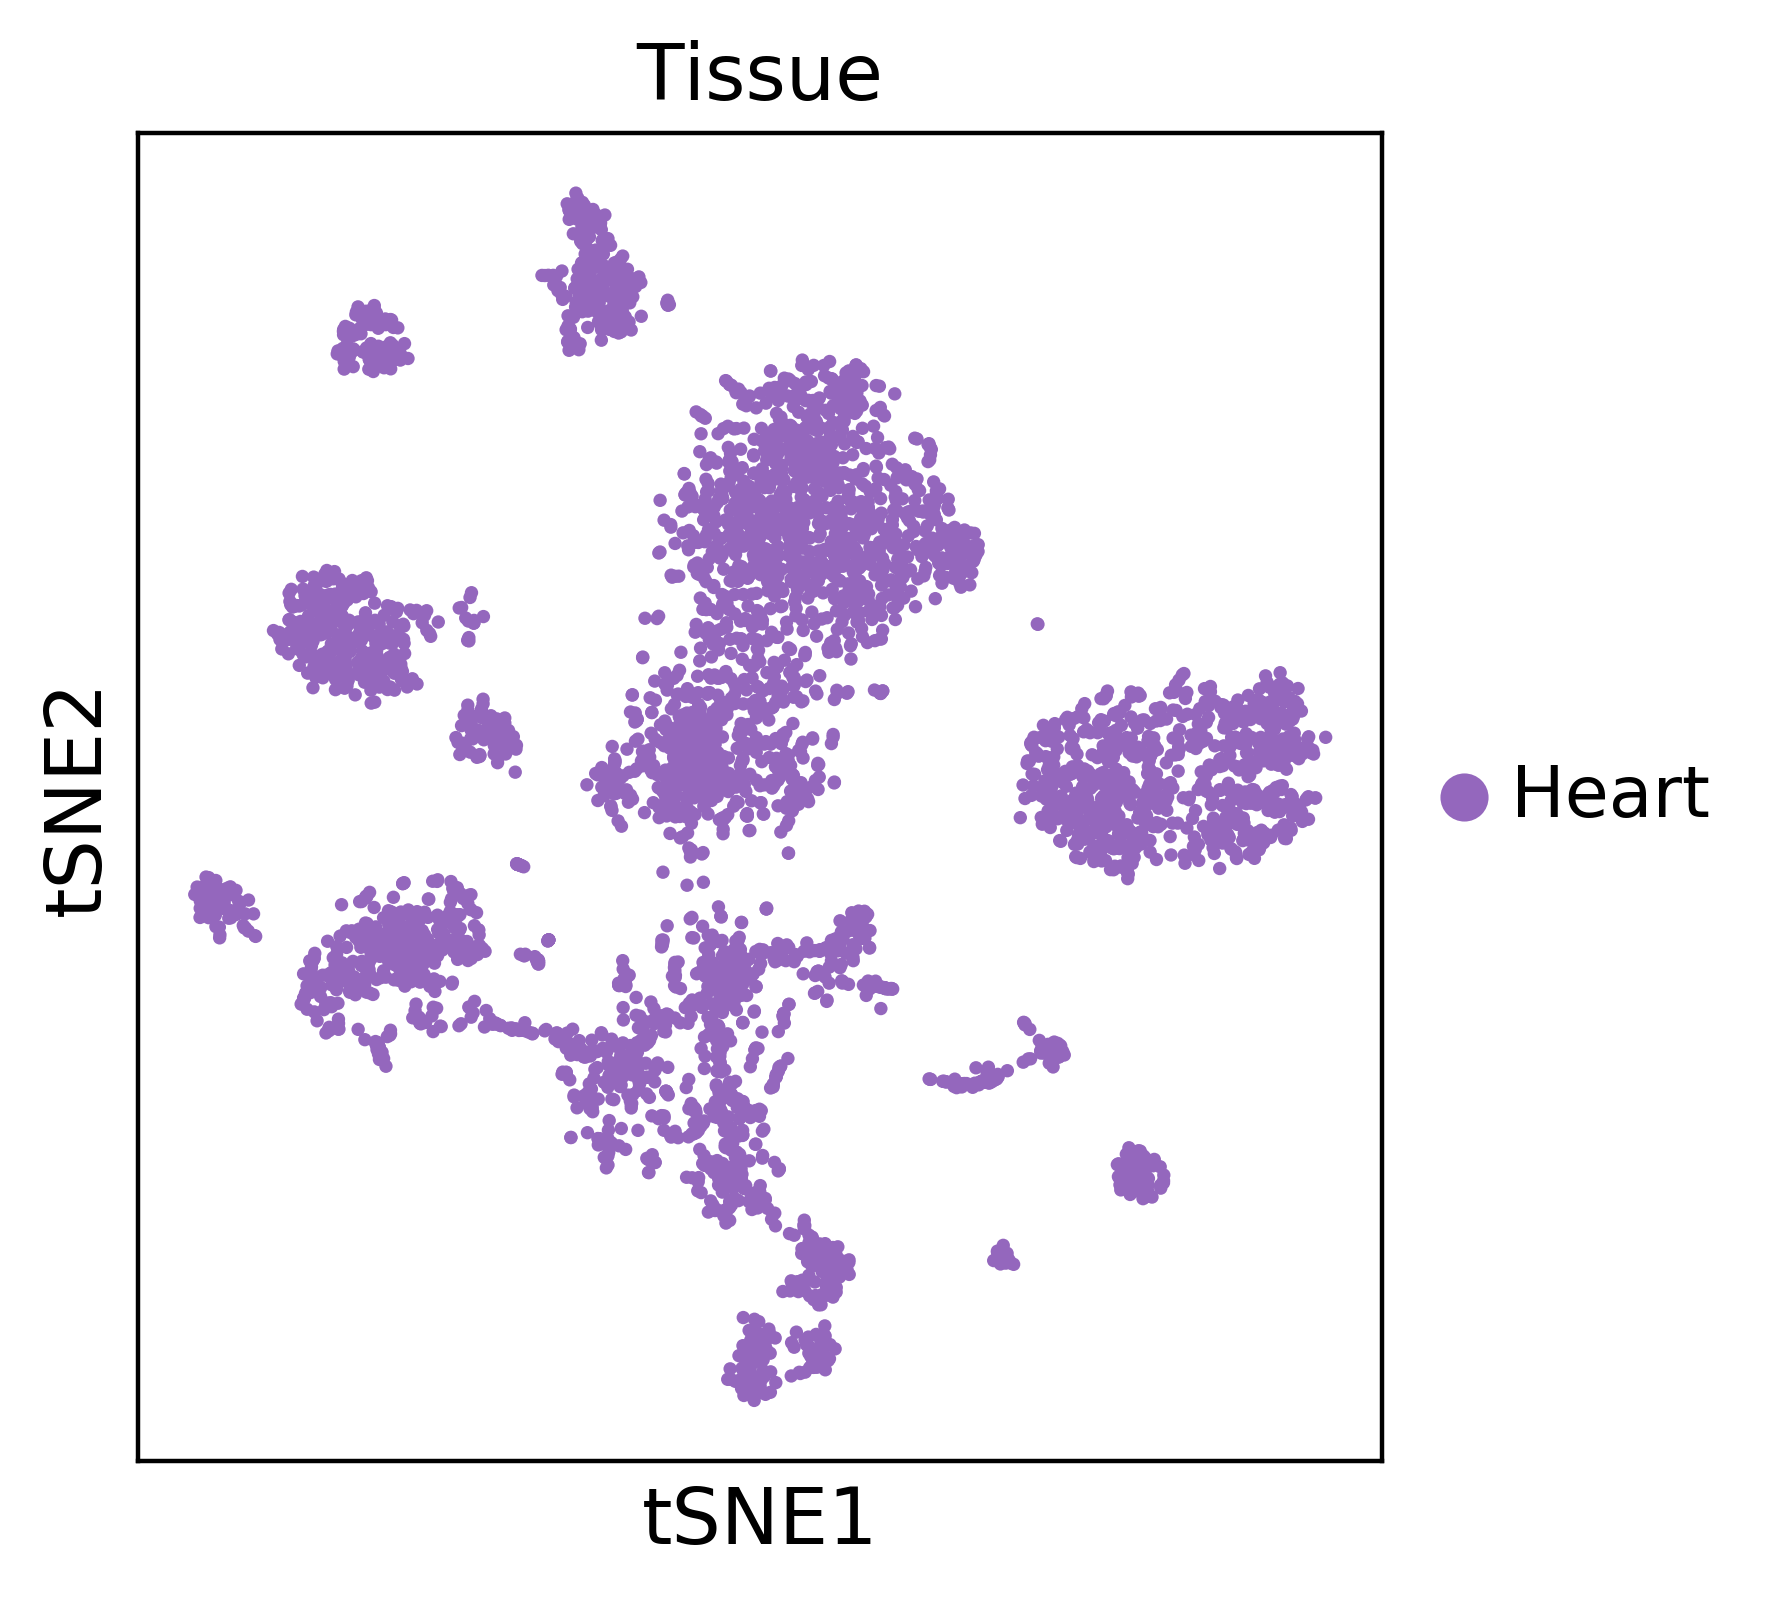

In [51]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['Tissue'], right_margin=0.5)

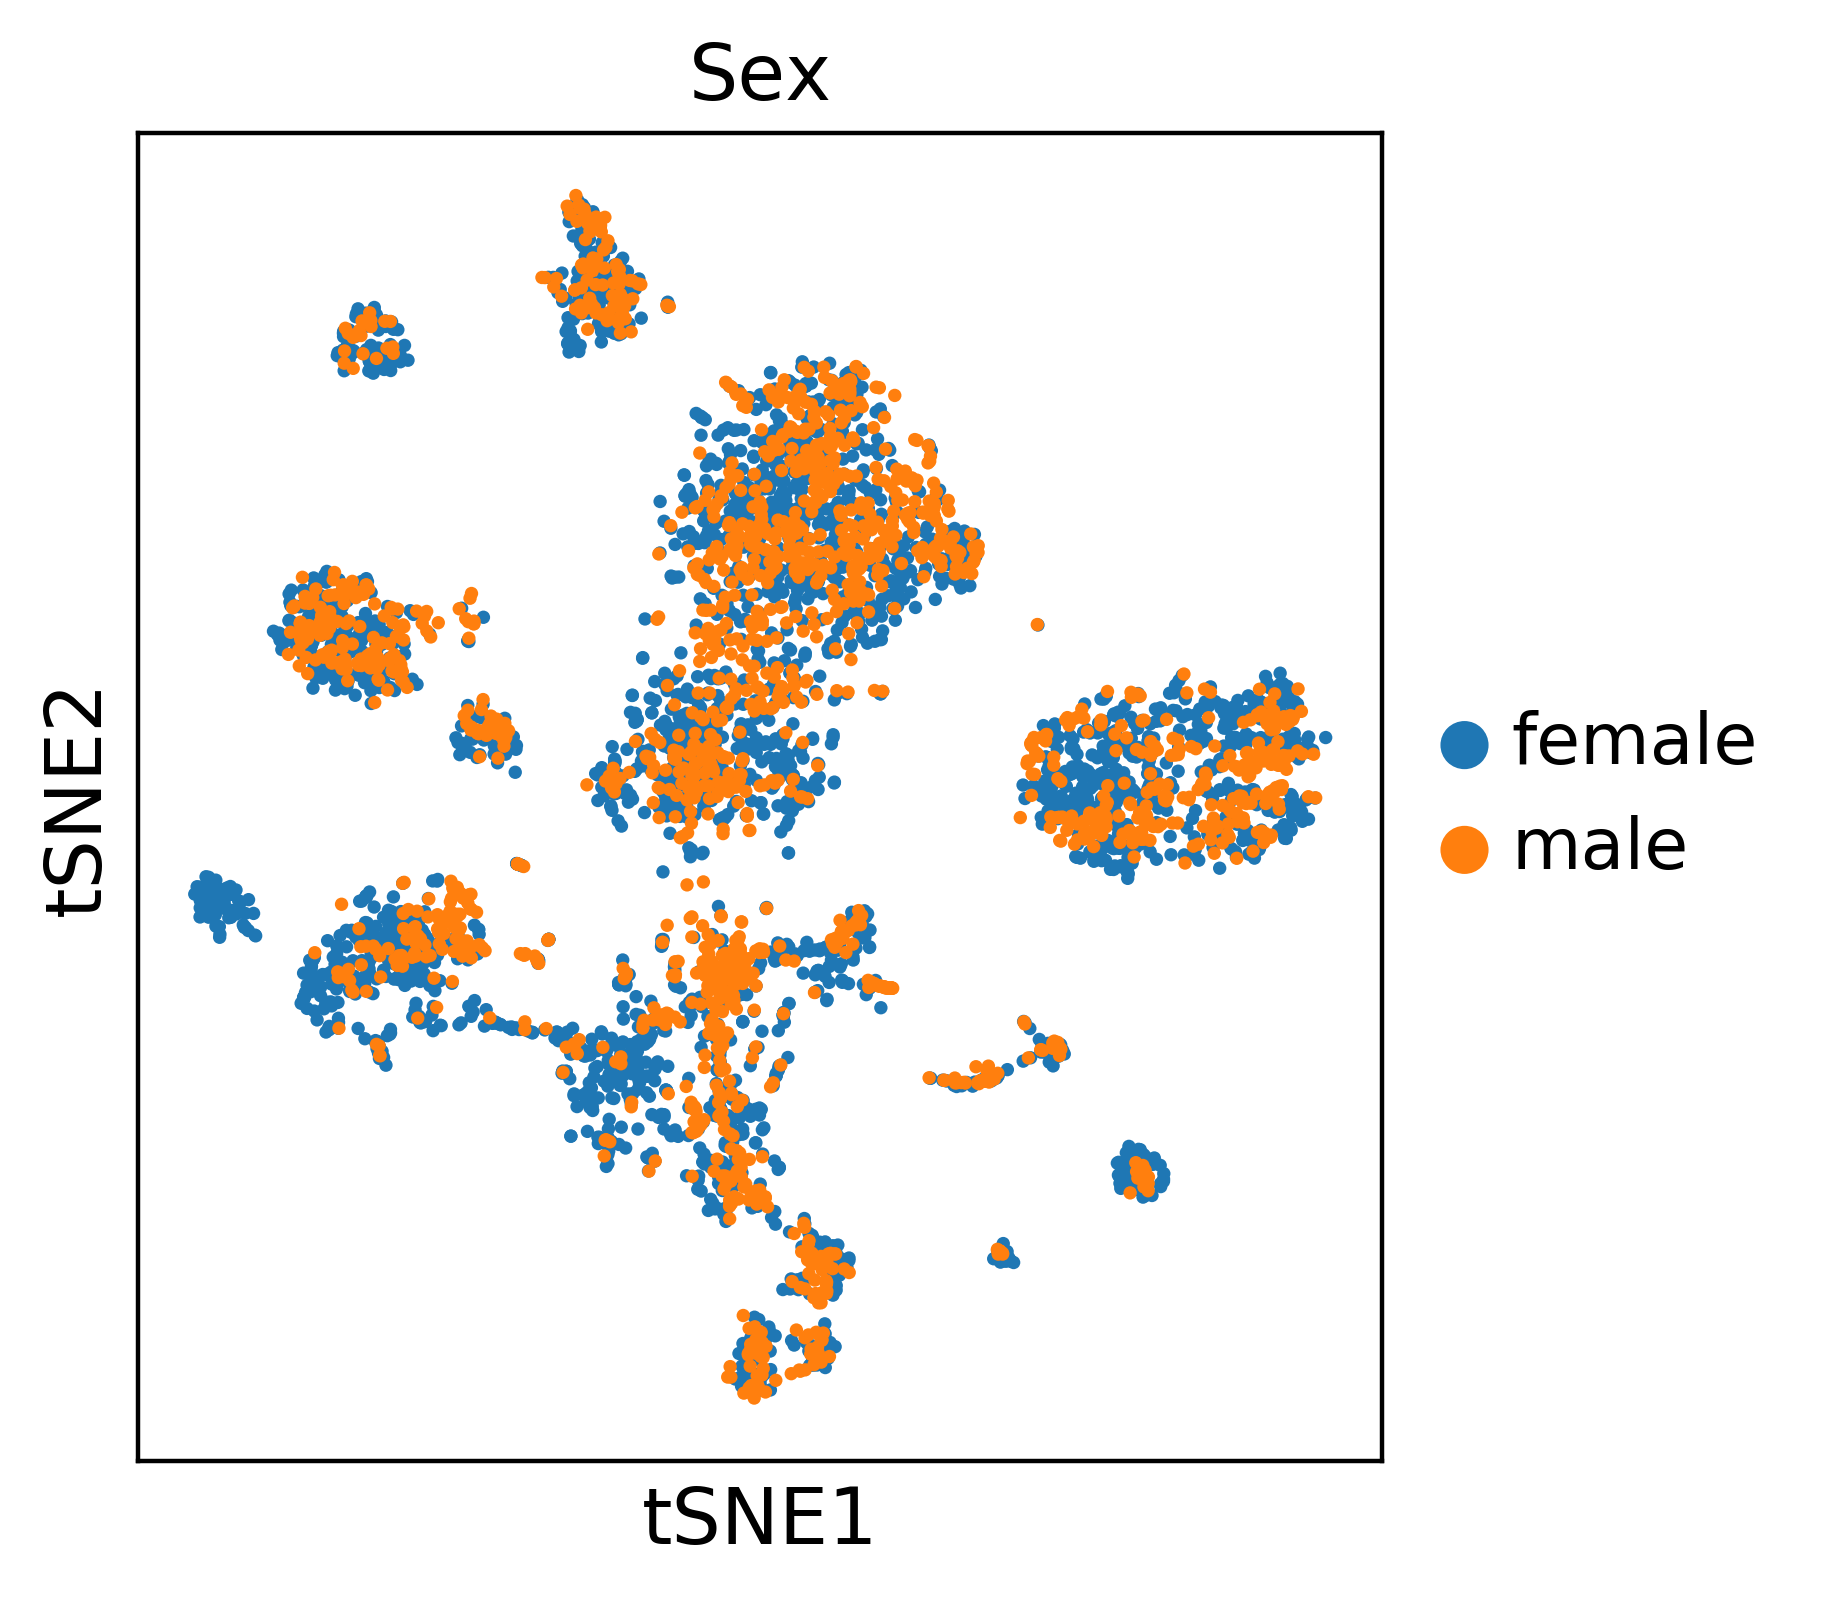

In [52]:
sc.pl.tsne(tiss, color=['Sex'], right_margin=0.5)

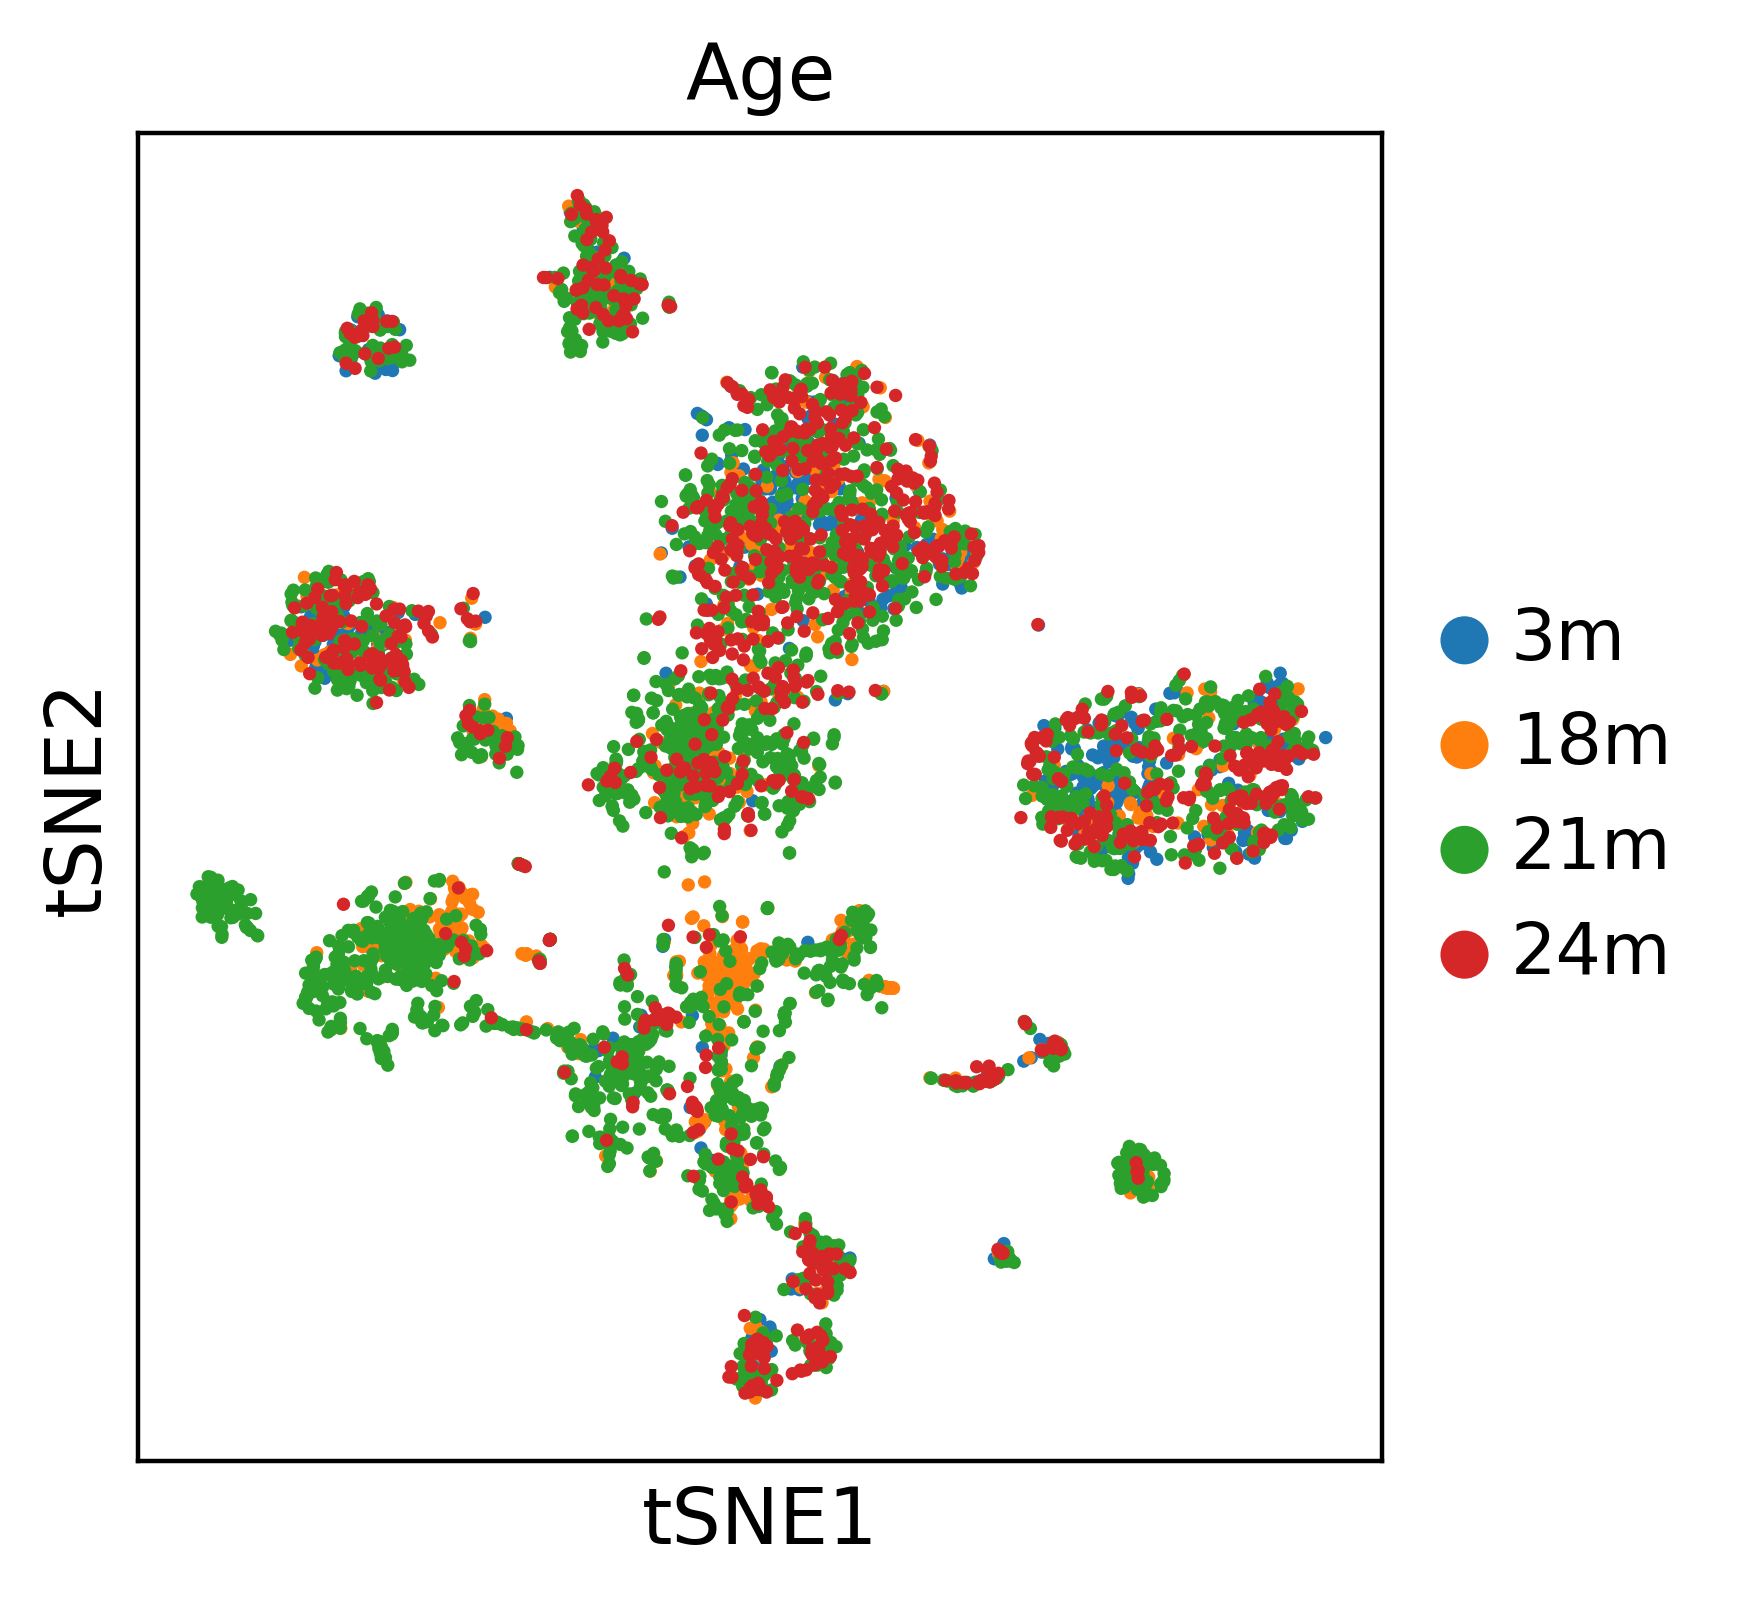

In [53]:
sc.pl.tsne(tiss, color=['Age'], right_margin=0.5)

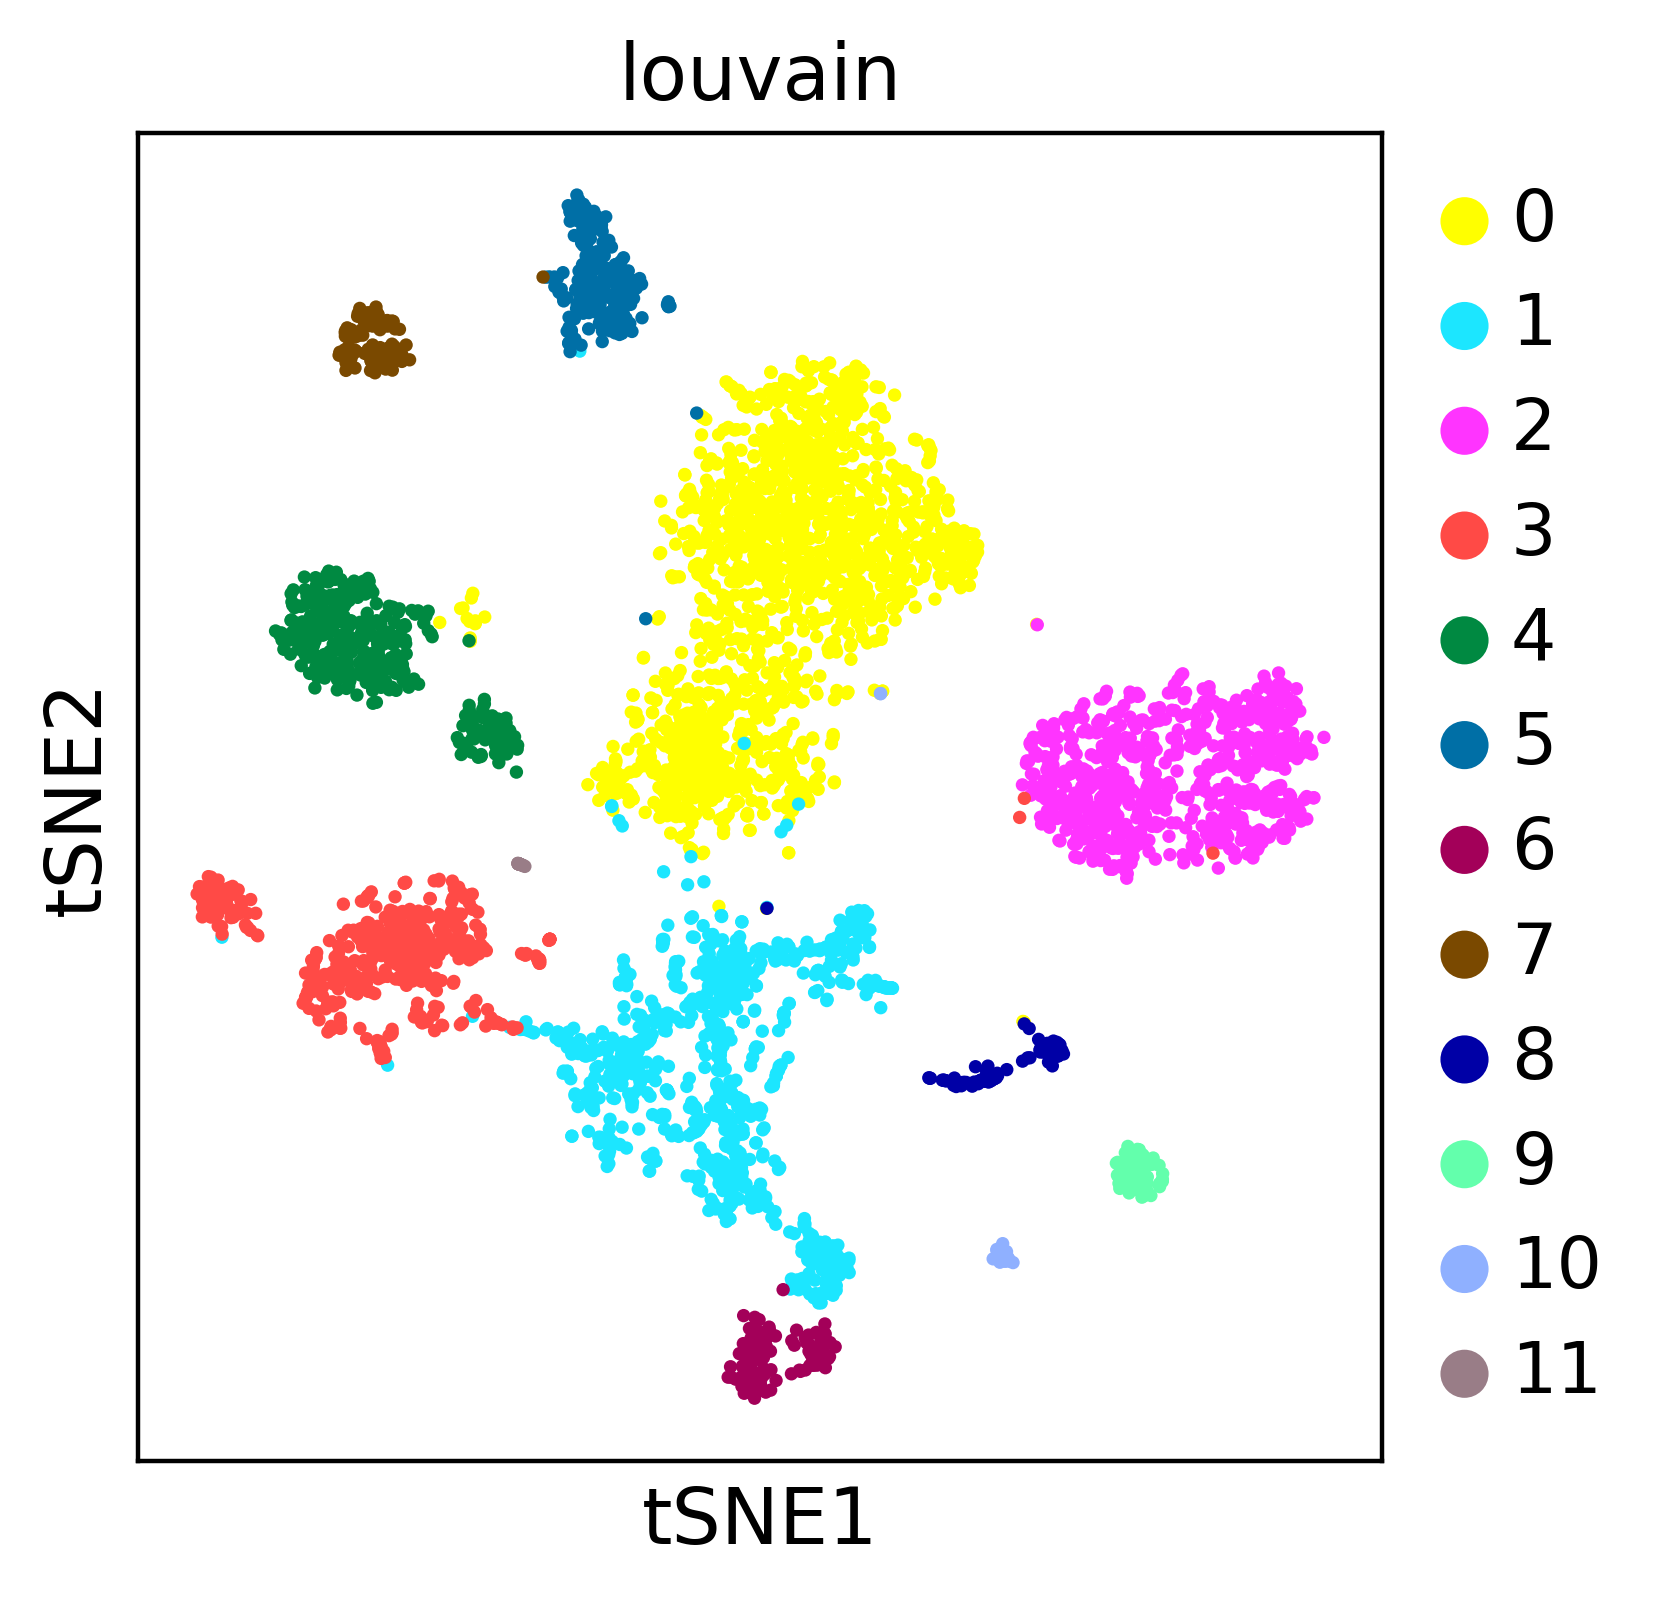

In [54]:
sc.pl.tsne(tiss, color=['louvain'],right_margin=0.5)

## read the annotations from tabula muris

In [34]:
maca10x3metadata2 = pd.read_csv('/data/maca/data/10x/TM_droplet_metadata.csv', low_memory=False)
maca10x3metadata2 = maca10x3metadata2.rename(columns = {'cell':'Cell'})
len(maca10x3metadata2)

70118

In [35]:
ageofinterest = "3m"
tissage = tiss[tiss.obs['Age'] == ageofinterest,:]
tissage

View of AnnData object with n_obs × n_vars = 634 × 2202 
    obs: 'Tissue', 'subTissue', 'Age', 'Sex', 'n_genes', 'Channel', 'Cell_Ontology_Type', 'batch', 'Cell', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'Age_colors', 'Sex_colors', 'Tissue_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

In [36]:
tissage.obs.head()

Tissue subTissue Age     Sex  n_genes   Channel  \
index                                                                     
AAACCTGCACGACGAA-1-13-1  Heart  HEART-56  3m  female     2063  10X_P7_4   
AAACCTGGTTCCACGG-1-13-1  Heart  HEART-56  3m  female     2040  10X_P7_4   
AAACCTGTCTCGATGA-1-13-1  Heart  HEART-56  3m  female     2024  10X_P7_4   
AAACGGGAGCGCTCCA-1-13-1  Heart  HEART-56  3m  female     1449  10X_P7_4   
AAAGCAAAGTGAATTG-1-13-1  Heart  HEART-56  3m  female      832  10X_P7_4   

                        Cell_Ontology_Type batch                       Cell  \
index                                                                         
AAACCTGCACGACGAA-1-13-1                 NA     1  10X_P7_4_AAACCTGCACGACGAA   
AAACCTGGTTCCACGG-1-13-1                 NA     1  10X_P7_4_AAACCTGGTTCCACGG   
AAACCTGTCTCGATGA-1-13-1                 NA     1  10X_P7_4_AAACCTGTCTCGATGA   
AAACGGGAGCGCTCCA-1-13-1                 NA     1  10X_P7_4_AAACGGGAGCGCTCCA   
AAAGCAAAGTGAATTG-1-13-1                 NA     1  10X_P7_4_AAAGCAAAGTGAATTG   

                         n_counts louvain  
index                                      
AAACCTGCACGACGAA-1-13-1    4680.0       0  
AAACCTGGTTCCACGG-1-13-1    4330.0       2  
AAACCTGTCTCGATGA-1-13-1    3851.0       0  
AAACGGGAGCGCTCCA-1-13-1    3902.0       1  
AAAGCAAAGTGAATTG-1-13-1    1676.0       2

In [37]:
maca10x3metadata2.head()

Cell   channel mouse.id  tissue subtissue mouse.sex  \
0  10X_P4_0_AAACCTGAGATTACCC  10X_P4_0    3-M-8  Tongue       NaN         M   
1  10X_P4_0_AAACCTGAGTGCCAGA  10X_P4_0    3-M-8  Tongue       NaN         M   
2  10X_P4_0_AAACCTGCAAATCCGT  10X_P4_0    3-M-8  Tongue       NaN         M   
3  10X_P4_0_AAACCTGGTAATCGTC  10X_P4_0    3-M-8  Tongue       NaN         M   
4  10X_P4_0_AAACCTGGTCCAACTA  10X_P4_0    3-M-8  Tongue       NaN         M   

    method      cell_ontology_class cell_ontology_id  \
0  droplet  basal cell of epidermis       CL:0002187   
1  droplet             keratinocyte       CL:0000312   
2  droplet             keratinocyte       CL:0000312   
3  droplet  basal cell of epidermis       CL:0002187   
4  droplet  basal cell of epidermis       CL:0002187   

              free_annotation  
0               proliferating  
1              differentiated  
2  suprabasal differentiating  
3                 basal cells  
4               proliferating

In [38]:
merged_inner = pd.merge(left=tissage.obs,right=maca10x3metadata2, left_on='Cell', right_on='Cell')
#merged_inner = merged_inner[['Age','Cell','Channel','Sex','Tissue','batch','n_genes','n_counts','cell_ontology_class','free_annotation']]
merged_inner.head()

Tissue subTissue Age     Sex  n_genes   Channel Cell_Ontology_Type batch  \
0  Heart  HEART-56  3m  female     2063  10X_P7_4                 NA     1   
1  Heart  HEART-56  3m  female     2040  10X_P7_4                 NA     1   
2  Heart  HEART-56  3m  female     2024  10X_P7_4                 NA     1   
3  Heart  HEART-56  3m  female     1449  10X_P7_4                 NA     1   
4  Heart  HEART-56  3m  female      832  10X_P7_4                 NA     1   

                        Cell  n_counts louvain   channel mouse.id  \
0  10X_P7_4_AAACCTGCACGACGAA    4680.0       0  10X_P7_4   3-F-56   
1  10X_P7_4_AAACCTGGTTCCACGG    4330.0       2  10X_P7_4   3-F-56   
2  10X_P7_4_AAACCTGTCTCGATGA    3851.0       0  10X_P7_4   3-F-56   
3  10X_P7_4_AAACGGGAGCGCTCCA    3902.0       1  10X_P7_4   3-F-56   
4  10X_P7_4_AAAGCAAAGTGAATTG    1676.0       2  10X_P7_4   3-F-56   

            tissue subtissue mouse.sex   method cell_ontology_class  \
0  Heart_and_Aorta       NaN         F  droplet    endothelial cell   
1  Heart_and_Aorta       NaN         F  droplet          fibroblast   
2  Heart_and_Aorta       NaN         F  droplet    endothelial cell   
3  Heart_and_Aorta       NaN         F  droplet                 NaN   
4  Heart_and_Aorta       NaN         F  droplet          fibroblast   

  cell_ontology_id free_annotation  
0       CL:0000115             NaN  
1       CL:0000057             NaN  
2       CL:0000115             NaN  
3              NaN             NaN  
4       CL:0000057             NaN

In [39]:
tissage.obs["cell_ontology_class"] = merged_inner["cell_ontology_class"]
tissage.obs["free_annotation"] = merged_inner["free_annotation"]
tissage.obs

Tissue subTissue Age     Sex  n_genes   Channel  \
index                                                                     
AAACCTGCACGACGAA-1-13-1  Heart  HEART-56  3m  female     2063  10X_P7_4   
AAACCTGGTTCCACGG-1-13-1  Heart  HEART-56  3m  female     2040  10X_P7_4   
AAACCTGTCTCGATGA-1-13-1  Heart  HEART-56  3m  female     2024  10X_P7_4   
AAACGGGAGCGCTCCA-1-13-1  Heart  HEART-56  3m  female     1449  10X_P7_4   
AAAGCAAAGTGAATTG-1-13-1  Heart  HEART-56  3m  female      832  10X_P7_4   
AAAGCAACACCGAAAG-1-13-1  Heart  HEART-56  3m  female      930  10X_P7_4   
AAATGCCAGTCCATAC-1-13-1  Heart  HEART-56  3m  female     3478  10X_P7_4   
AAATGCCCAGTAAGAT-1-13-1  Heart  HEART-56  3m  female     2783  10X_P7_4   
AACCATGCACTGTCGG-1-13-1  Heart  HEART-56  3m  female     3056  10X_P7_4   
AACGTTGTCCTCATTA-1-13-1  Heart  HEART-56  3m  female     2127  10X_P7_4   
AACTCAGTCACTTCAT-1-13-1  Heart  HEART-56  3m  female     1228  10X_P7_4   
AACTCTTGTCTTGCGG-1-13-1  Heart  HEART-56  3m  female     1305  10X_P7_4   
AACTCTTGTTCAACCA-1-13-1  Heart  HEART-56  3m  female     2629  10X_P7_4   
AACTTTCCACGAAGCA-1-13-1  Heart  HEART-56  3m  female     2460  10X_P7_4   
AAGACCTAGTCCCACG-1-13-1  Heart  HEART-56  3m  female     3426  10X_P7_4   
AAGACCTCAGGGTTAG-1-13-1  Heart  HEART-56  3m  female     2289  10X_P7_4   
AAGACCTCAGGTTTCA-1-13-1  Heart  HEART-56  3m  female     1169  10X_P7_4   
AAGACCTTCTCAAACG-1-13-1  Heart  HEART-56  3m  female     2092  10X_P7_4   
AAGACCTTCTTCTGGC-1-13-1  Heart  HEART-56  3m  female     2689  10X_P7_4   
AAGGAGCAGCCAGAAC-1-13-1  Heart  HEART-56  3m  female     2258  10X_P7_4   
AAGGCAGAGCGTTGCC-1-13-1  Heart  HEART-56  3m  female     2509  10X_P7_4   
AAGGCAGAGCTCAACT-1-13-1  Heart  HEART-56  3m  female      765  10X_P7_4   
AAGGCAGGTCACCTAA-1-13-1  Heart  HEART-56  3m  female     2316  10X_P7_4   
AAGGTTCCAGCTATTG-1-13-1  Heart  HEART-56  3m  female     1350  10X_P7_4   
AAGGTTCGTATAGTAG-1-13-1  Heart  HEART-56  3m  female     1532  10X_P7_4   
AAGTCTGGTAAGAGGA-1-13-1  Heart  HEART-56  3m  female     3542  10X_P7_4   
AATCCAGCATGATCCA-1-13-1  Heart  HEART-56  3m  female     1012  10X_P7_4   
AATCCAGTCAGTTAGC-1-13-1  Heart  HEART-56  3m  female     1043  10X_P7_4   
AATCCAGTCTTGTCAT-1-13-1  Heart  HEART-56  3m  female     3202  10X_P7_4   
AATCGGTAGACAGGCT-1-13-1  Heart  HEART-56  3m  female     3176  10X_P7_4   
...                        ...       ...  ..     ...      ...       ...   
TTAGTTCTCTCTGCTG-1-13-1  Heart  HEART-56  3m  female     1582  10X_P7_4   
TTATGCTTCCCAAGTA-1-13-1  Heart  HEART-56  3m  female     3372  10X_P7_4   
TTATGCTTCCTTAATC-1-13-1  Heart  HEART-56  3m  female     3130  10X_P7_4   
TTCCCAGCATAAGACA-1-13-1  Heart  HEART-56  3m  female     1868  10X_P7_4   
TTCCCAGGTTGTTTGG-1-13-1  Heart  HEART-56  3m  female     1383  10X_P7_4   
TTCGGTCAGACAATAC-1-13-1  Heart  HEART-56  3m  female     2319  10X_P7_4   
TTCGGTCCAATCCGAT-1-13-1  Heart  HEART-56  3m  female     3298  10X_P7_4   
TTCGGTCCACTGTTAG-1-13-1  Heart  HEART-56  3m  female     2642  10X_P7_4   
TTCGGTCTCAGCTCTC-1-13-1  Heart  HEART-56  3m  female      625  10X_P7_4   
TTCTACAAGAGCAATT-1-13-1  Heart  HEART-56  3m  female     1930  10X_P7_4   
TTCTCCTTCACCGTAA-1-13-1  Heart  HEART-56  3m  female     3226  10X_P7_4   
TTCTTAGGTTTGGGCC-1-13-1  Heart  HEART-56  3m  female      825  10X_P7_4   
TTCTTAGTCATGGTCA-1-13-1  Heart  HEART-56  3m  female      808  10X_P7_4   
TTGCCGTAGCTATGCT-1-13-1  Heart  HEART-56  3m  female     2246  10X_P7_4   
TTGCCGTGTTGCGCAC-1-13-1  Heart  HEART-56  3m  female     1898  10X_P7_4   
TTGCCGTGTTGTTTGG-1-13-1  Heart  HEART-56  3m  female     2806  10X_P7_4   
TTGCGTCAGCAGATCG-1-13-1  Heart  HEART-56  3m  female      702  10X_P7_4   
TTGGAACAGTTGCAGG-1-13-1  Heart  HEART-56  3m  female     2263  10X_P7_4   
TTGGCAAAGTGGTAAT-1-13-1  Heart  HEART-56  3m  female      346  10X_P7_4   
TTGTAGGAGGTGGGTT-1-13-1  Heart  HEART-56  3m  female     2623  10X_P7_4   
TTTACTGCAGACGCTC-1-13-1  Heart  HEART-56  3m  fem

In [40]:
tissage.obs = tissage.obs.reset_index()

In [41]:
tissage.obs["cell_ontology_class"] = merged_inner["cell_ontology_class"]
tissage.obs["free_annotation"] = merged_inner["free_annotation"]
tissage.obs

index Tissue subTissue Age     Sex  n_genes   Channel  \
0    AAACCTGCACGACGAA-1-13-1  Heart  HEART-56  3m  female     2063  10X_P7_4   
1    AAACCTGGTTCCACGG-1-13-1  Heart  HEART-56  3m  female     2040  10X_P7_4   
2    AAACCTGTCTCGATGA-1-13-1  Heart  HEART-56  3m  female     2024  10X_P7_4   
3    AAACGGGAGCGCTCCA-1-13-1  Heart  HEART-56  3m  female     1449  10X_P7_4   
4    AAAGCAAAGTGAATTG-1-13-1  Heart  HEART-56  3m  female      832  10X_P7_4   
5    AAAGCAACACCGAAAG-1-13-1  Heart  HEART-56  3m  female      930  10X_P7_4   
6    AAATGCCAGTCCATAC-1-13-1  Heart  HEART-56  3m  female     3478  10X_P7_4   
7    AAATGCCCAGTAAGAT-1-13-1  Heart  HEART-56  3m  female     2783  10X_P7_4   
8    AACCATGCACTGTCGG-1-13-1  Heart  HEART-56  3m  female     3056  10X_P7_4   
9    AACGTTGTCCTCATTA-1-13-1  Heart  HEART-56  3m  female     2127  10X_P7_4   
10   AACTCAGTCACTTCAT-1-13-1  Heart  HEART-56  3m  female     1228  10X_P7_4   
11   AACTCTTGTCTTGCGG-1-13-1  Heart  HEART-56  3m  female     1305  10X_P7_4   
12   AACTCTTGTTCAACCA-1-13-1  Heart  HEART-56  3m  female     2629  10X_P7_4   
13   AACTTTCCACGAAGCA-1-13-1  Heart  HEART-56  3m  female     2460  10X_P7_4   
14   AAGACCTAGTCCCACG-1-13-1  Heart  HEART-56  3m  female     3426  10X_P7_4   
15   AAGACCTCAGGGTTAG-1-13-1  Heart  HEART-56  3m  female     2289  10X_P7_4   
16   AAGACCTCAGGTTTCA-1-13-1  Heart  HEART-56  3m  female     1169  10X_P7_4   
17   AAGACCTTCTCAAACG-1-13-1  Heart  HEART-56  3m  female     2092  10X_P7_4   
18   AAGACCTTCTTCTGGC-1-13-1  Heart  HEART-56  3m  female     2689  10X_P7_4   
19   AAGGAGCAGCCAGAAC-1-13-1  Heart  HEART-56  3m  female     2258  10X_P7_4   
20   AAGGCAGAGCGTTGCC-1-13-1  Heart  HEART-56  3m  female     2509  10X_P7_4   
21   AAGGCAGAGCTCAACT-1-13-1  Heart  HEART-56  3m  female      765  10X_P7_4   
22   AAGGCAGGTCACCTAA-1-13-1  Heart  HEART-56  3m  female     2316  10X_P7_4   
23   AAGGTTCCAGCTATTG-1-13-1  Heart  HEART-56  3m  female     1350  10X_P7_4   
24   AAGGTTCGTATAGTAG-1-13-1  Heart  HEART-56  3m  female     1532  10X_P7_4   
25   AAGTCTGGTAAGAGGA-1-13-1  Heart  HEART-56  3m  female     3542  10X_P7_4   
26   AATCCAGCATGATCCA-1-13-1  Heart  HEART-56  3m  female     1012  10X_P7_4   
27   AATCCAGTCAGTTAGC-1-13-1  Heart  HEART-56  3m  female     1043  10X_P7_4   
28   AATCCAGTCTTGTCAT-1-13-1  Heart  HEART-56  3m  female     3202  10X_P7_4   
29   AATCGGTAGACAGGCT-1-13-1  Heart  HEART-56  3m  female     3176  10X_P7_4   
..                       ...    ...       ...  ..     ...      ...       ...   
604  TTAGTTCTCTCTGCTG-1-13-1  Heart  HEART-56  3m  female     1582  10X_P7_4   
605  TTATGCTTCCCAAGTA-1-13-1  Heart  HEART-56  3m  female     3372  10X_P7_4   
606  TTATGCTTCCTTAATC-1-13-1  Heart  HEART-56  3m  female     3130  10X_P7_4   
607  TTCCCAGCATAAGACA-1-13-1  Heart  HEART-56  3m  female     1868  10X_P7_4   
608  TTCCCAGGTTGTTTGG-1-13-1  Heart  HEART-56  3m  female     1383  10X_P7_4   
609  TTCGGTCAGACAATAC-1-13-1  Heart  HEART-56  3m  female     2319  10X_P7_4   
610  TTCGGTCCAATCCGAT-1-13-1  Heart  HEART-56  3m  female     3298  10X_P7_4   
611  TTCGGTCCACTGTTAG-1-13-1  Heart  HEART-56  3m  female     2642  10X_P7_4   
612  TTCGGTCTCAGCTCTC-1-13-1  Heart  HEART-56  3m  female      625  10X_P7_4   
613  TTCTACAAGAGCAATT-1-13-1  Heart  HEART-56  3m  female     1930  10X_P7_4   
614  TTCTCCTTCACCGTAA-1-13-1  Heart  HEART-56  3m  female     3226  10X_P7_4   
615  TTCTTAGGTTTGGGCC-1-13-1  Heart  HEART-56  3m  female      825  10X_P7_4   
616  TTCTTAGTCATGGTCA-1-13-1  Heart  HEART-56  3m  female      808  10X_P7_4   
617  TTGCCGTAGCTATGCT-1-13-1  Heart  HEART-56  3m  female     2246  10X_P7_4   
618  TTGCCGTGTTGCGCAC-1-13-1  Heart  HEART-56  3m  female     1898  10X_P7_4   
619  TTGCCGTGTTGTTTGG-1-13-1  Heart  HEART-56  3m  female     2806  10X_P7_4   
620  TTGCGTCAGCAGATCG-1-13-1  Heart  HEART-56  3m  female      702  10X_P7_4   
621  TTGGAACAGTTGCAGG-1-13-1  Heart  HEART-56  3m  female     2263  10X_P7_4   
622  TTGGCAAAGTGGTAAT-1

In [42]:
tissage.obs.head()

index Tissue subTissue Age     Sex  n_genes   Channel  \
0  AAACCTGCACGACGAA-1-13-1  Heart  HEART-56  3m  female     2063  10X_P7_4   
1  AAACCTGGTTCCACGG-1-13-1  Heart  HEART-56  3m  female     2040  10X_P7_4   
2  AAACCTGTCTCGATGA-1-13-1  Heart  HEART-56  3m  female     2024  10X_P7_4   
3  AAACGGGAGCGCTCCA-1-13-1  Heart  HEART-56  3m  female     1449  10X_P7_4   
4  AAAGCAAAGTGAATTG-1-13-1  Heart  HEART-56  3m  female      832  10X_P7_4   

  Cell_Ontology_Type batch                       Cell  n_counts louvain  \
0                 NA     1  10X_P7_4_AAACCTGCACGACGAA    4680.0       0   
1                 NA     1  10X_P7_4_AAACCTGGTTCCACGG    4330.0       2   
2                 NA     1  10X_P7_4_AAACCTGTCTCGATGA    3851.0       0   
3                 NA     1  10X_P7_4_AAACGGGAGCGCTCCA    3902.0       1   
4                 NA     1  10X_P7_4_AAAGCAAAGTGAATTG    1676.0       2   

  cell_ontology_class free_annotation  
0    endothelial cell             NaN  
1          fibroblast             NaN  
2    endothelial cell             NaN  
3                 NaN             NaN  
4          fibroblast             NaN

In [43]:
#sc.tl.pca(tissage)
#sc.pp.neighbors(tissage, n_neighbors=15)#, method='gauss')
#sc.tl.louvain(tissage, resolution = 0.3)
#sc.tl.tsne(tissage, perplexity=50)

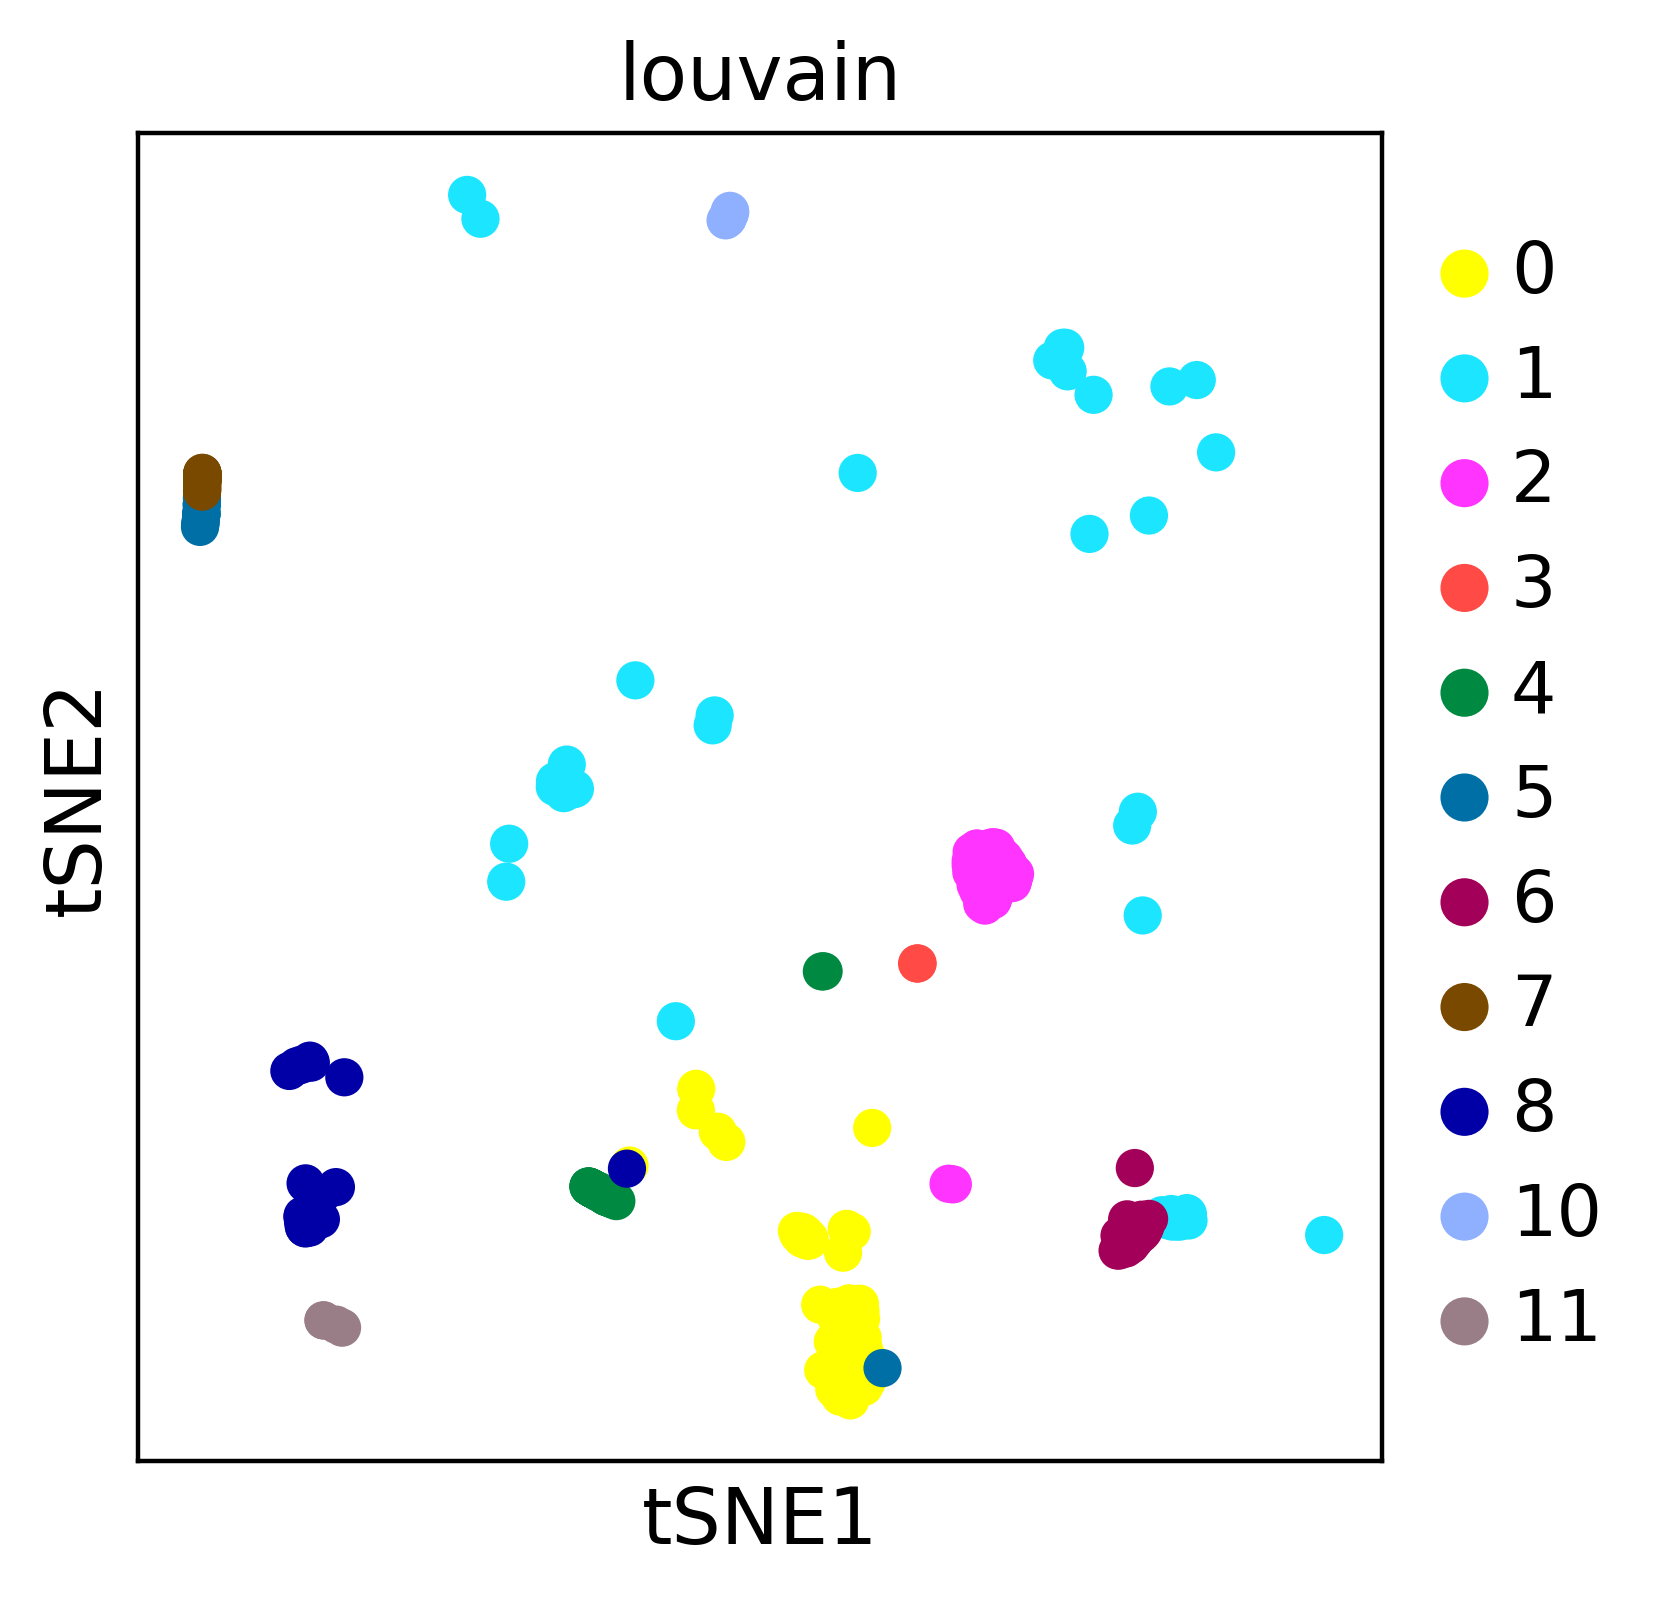

In [55]:
sc.pl.tsne(tissage, color=['louvain'],right_margin=0.5)

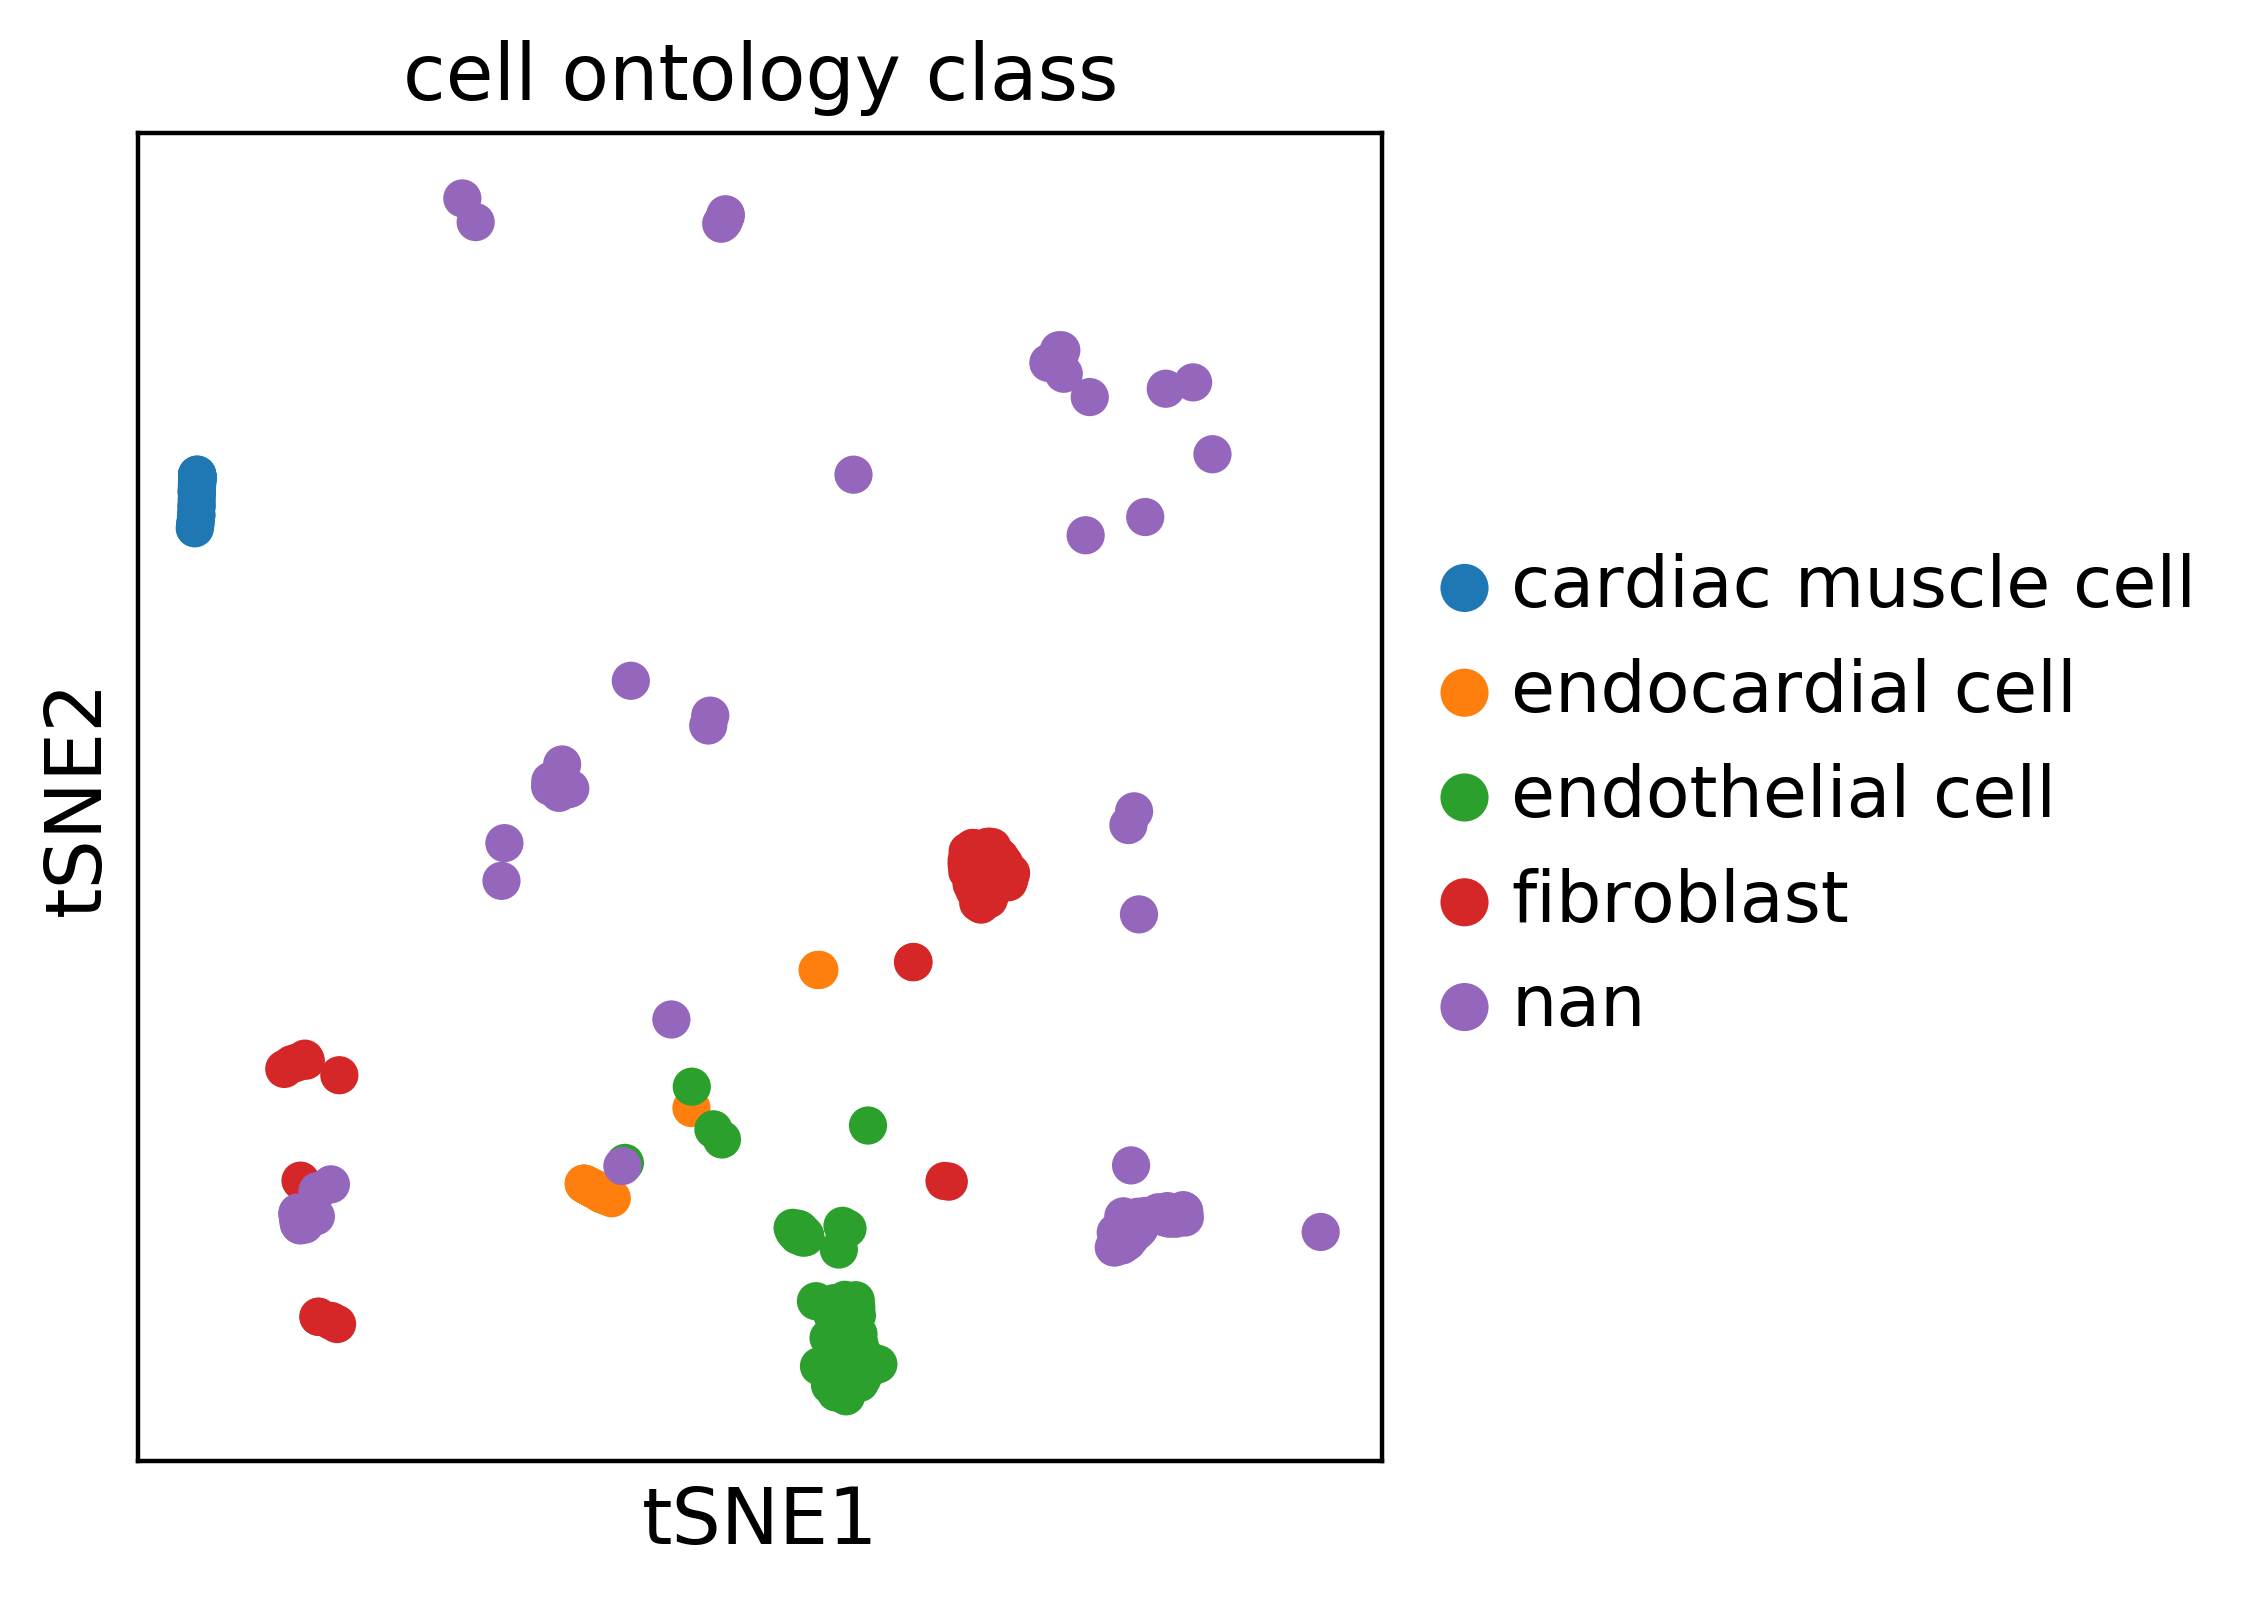

In [56]:
sc.pl.tsne(tissage, color=['cell_ontology_class'],right_margin=0.5)

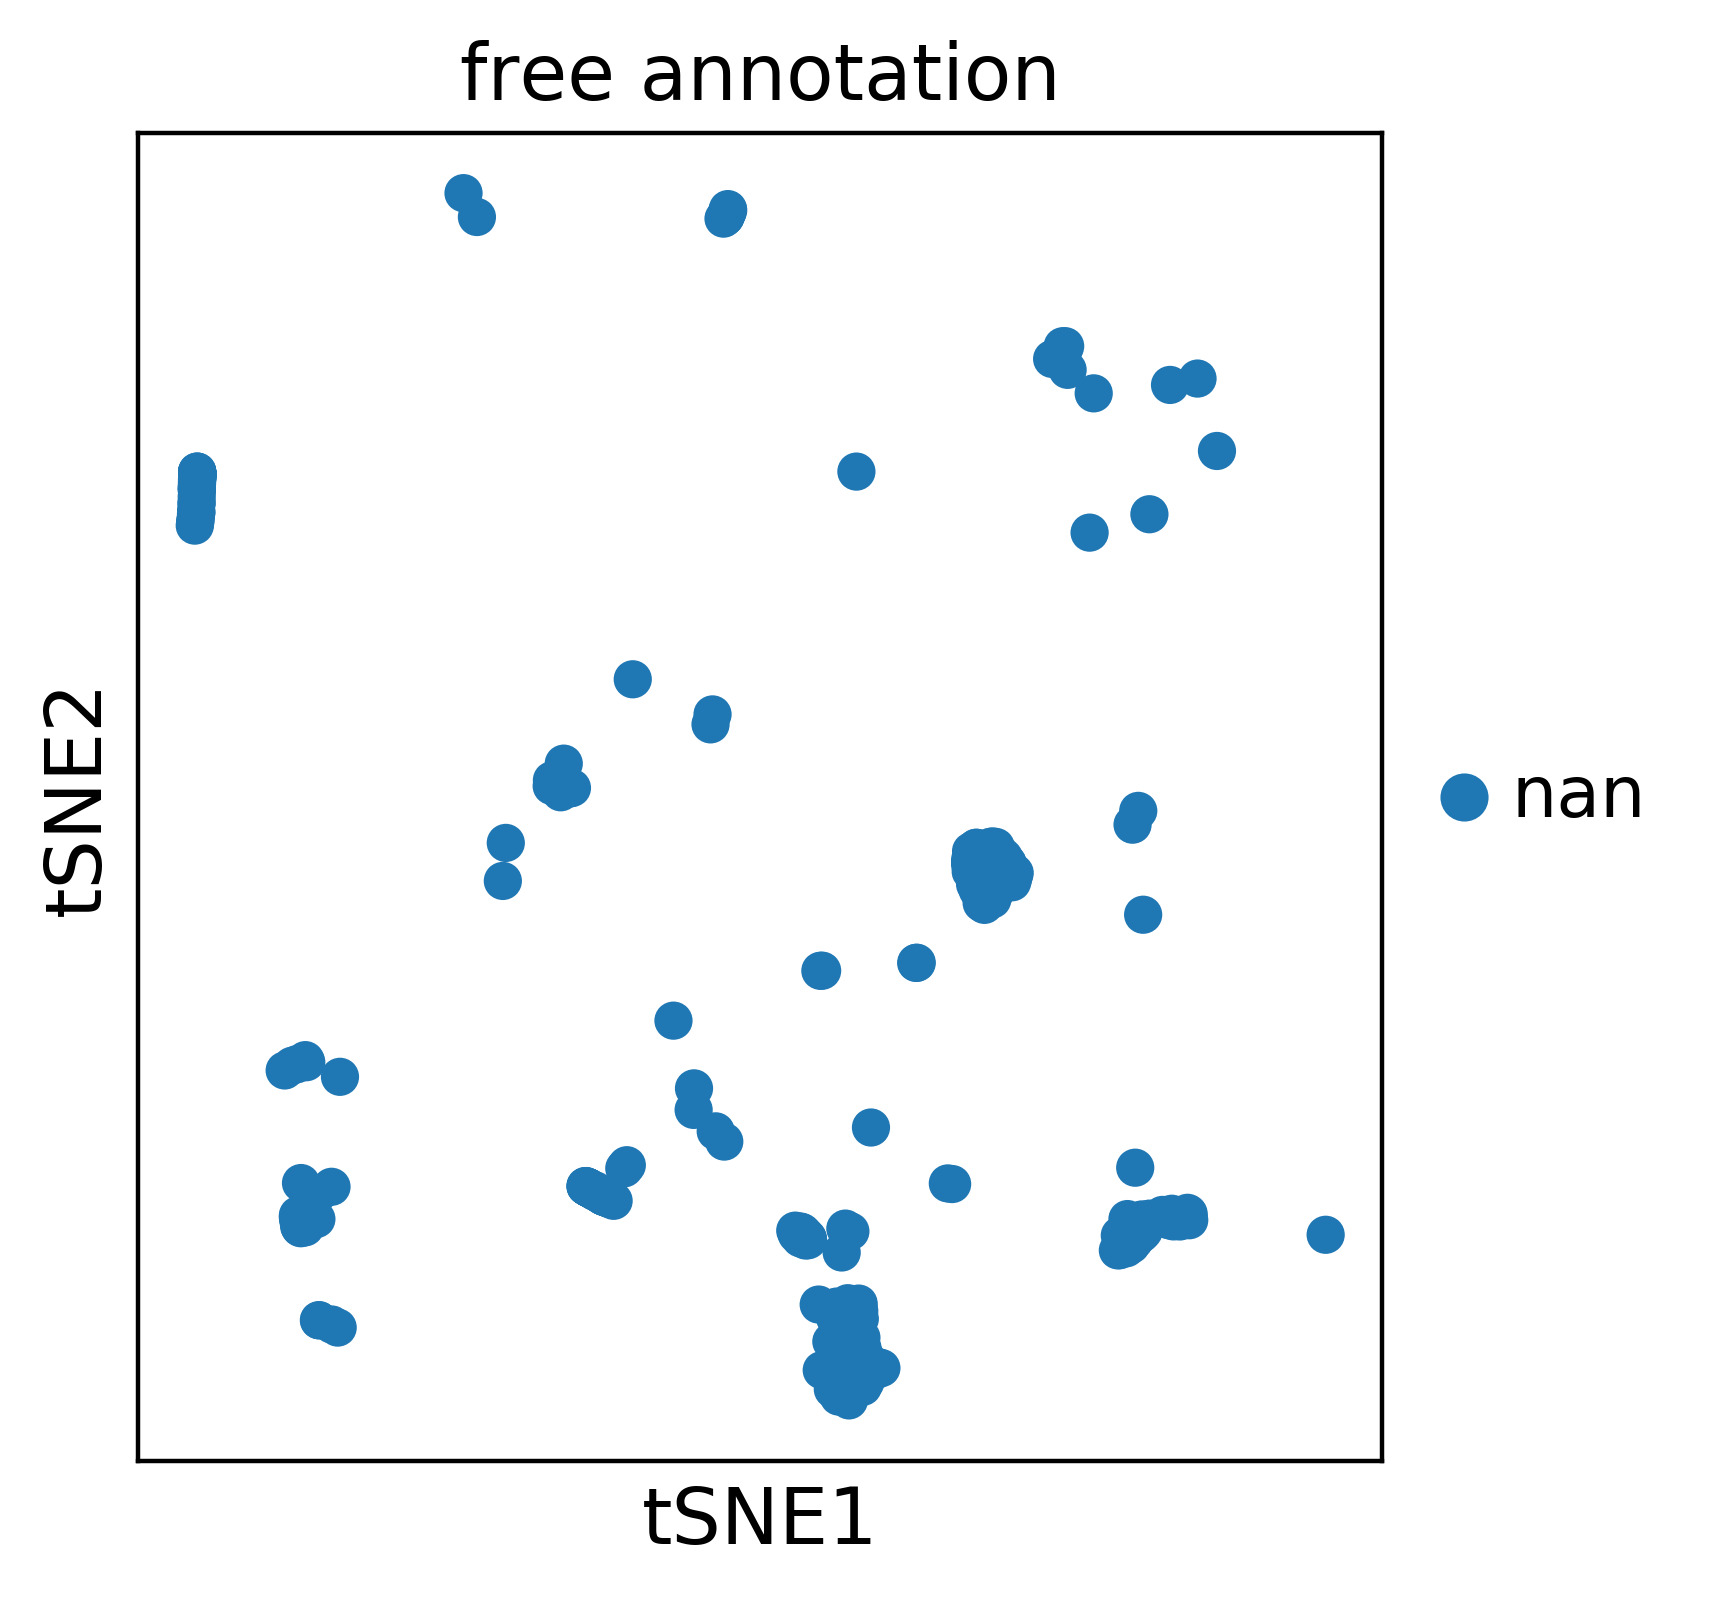

In [57]:
sc.pl.tsne(tissage, color=['free_annotation'],right_margin=0.5)

In [47]:
# df = tissage.obs[tissage.obs['louvain'].str.match('2')]['cell_ontology_class']
# df.reset_index()
# df = df.reset_index()
# display(df.groupby('cell_ontology_class').count())
# display(df.groupby('cell_ontology_class').count().sum())
# display(df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum())
# dfaux = df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum()
# dfaux.reset_index()
# dfaux = dfaux.reset_index()
# display(dfaux[dfaux['index']>0.95][['cell_ontology_class']])
# #dfdf.sum()
# #df.drop_duplicates()
# #tissage.obs['louvain']
# #val = dfaux[dfaux['index']>0.95][['cell_ontology_class']].values[0]
# #print(val)

In [58]:
tiss_cell_ontology_class = {}
for i in range(0,tissage.obs['louvain'].nunique()):
    df = tissage.obs[tissage.obs['louvain'].str.match(str(i))]['cell_ontology_class']
    df.reset_index()
    df = df.reset_index()
    #df.groupby('cell_ontology_class').count()
    #df.groupby('cell_ontology_class').count().sum()
    #df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum()
    dfaux = df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum()
    dfaux.reset_index()
    dfaux = dfaux.reset_index()
    #display(dfaux[dfaux['index']>0.95][['cell_ontology_class']])
    #dfdfaux = pd.concat([dfdfaux,dfaux[dfaux['index']>0.95][['cell_ontology_class']]])
    a = dfaux[dfaux['index']>0.95][['cell_ontology_class']]
    if a.empty:
        tiss_cell_ontology_class[i] = 'tbc'
    else:
        tiss_cell_ontology_class[i] = a.values[0]

tiss_cell_ontology_class



{0: array(['endothelial cell'], dtype=object),
 1: 'tbc',
 2: array(['fibroblast'], dtype=object),
 3: array(['fibroblast'], dtype=object),
 4: array(['endocardial cell'], dtype=object),
 5: 'tbc',
 6: array(['nan'], dtype=object),
 7: array(['cardiac muscle cell'], dtype=object),
 8: 'tbc',
 9: 'tbc',
 10: array(['nan'], dtype=object)}

In [49]:
tiss.obs['louvain'] = tiss.obs['louvain'].apply(pd.to_numeric)
tiss.obs['cell_ontology_class'] = tiss.obs['louvain'].map(tiss_cell_ontology_class)
tiss.obs

Tissue  subTissue  Age     Sex  n_genes  \
index                                                             
AAAGCAAGTAGGGACT-1-29-0  Heart  4Chambers  18m    male     2853   
AAAGCAATCCAGTATG-1-29-0  Heart  4Chambers  18m    male      458   
AAAGTAGAGACAAAGG-1-29-0  Heart  4Chambers  18m    male     1708   
AACACGTAGCTCTCGG-1-29-0  Heart  4Chambers  18m    male      382   
AACACGTCATGCCTAA-1-29-0  Heart  4Chambers  18m    male      272   
AACACGTTCTCTAAGG-1-29-0  Heart  4Chambers  18m    male     2490   
AACCGCGCAGCATGAG-1-29-0  Heart  4Chambers  18m    male     2151   
AACGTTGGTATCAGTC-1-29-0  Heart  4Chambers  18m    male      285   
AACGTTGGTCTCATCC-1-29-0  Heart  4Chambers  18m    male      264   
AACTCAGAGAAGCCCA-1-29-0  Heart  4Chambers  18m    male      299   
AACTCCCAGACAAGCC-1-29-0  Heart  4Chambers  18m    male      267   
AACTCCCAGAGAACAG-1-29-0  Heart  4Chambers  18m    male      621   
AACTCCCCAAGACACG-1-29-0  Heart  4Chambers  18m    male     3012   
AACTCCCTCAACACAC-1-29-0  Heart  4Chambers  18m    male      415   
AACTCTTAGGCGACAT-1-29-0  Heart  4Chambers  18m    male      342   
AACTCTTTCTTACCTA-1-29-0  Heart  4Chambers  18m    male      487   
AACTGGTAGAAGGTGA-1-29-0  Heart  4Chambers  18m    male     1270   
AACTGGTAGATGCCAG-1-29-0  Heart  4Chambers  18m    male      536   
AACTGGTCAGGGAGAG-1-29-0  Heart  4Chambers  18m    male      364   
AACTTTCAGGAGCGAG-1-29-0  Heart  4Chambers  18m    male      300   
AACTTTCCAAGGGTCA-1-29-0  Heart  4Chambers  18m    male      334   
AAGACCTAGAGAACAG-1-29-0  Heart  4Chambers  18m    male      476   
AAGACCTAGATCTGCT-1-29-0  Heart  4Chambers  18m    male     2434   
AAGACCTGTGTAATGA-1-29-0  Heart  4Chambers  18m    male      864   
AAGCCGCAGGTGGGTT-1-29-0  Heart  4Chambers  18m    male      250   
AAGGAGCCATACTACG-1-29-0  Heart  4Chambers  18m    male     1361   
AAGGAGCCATCCTTGC-1-29-0  Heart  4Chambers  18m    male      273   
AAGGAGCGTTTAGCTG-1-29-0  Heart  4Chambers  18m    male      298   
AAGGCAGGTATGAAAC-1-29-0  Heart  4Chambers  18m    male     3230   
AAGGCAGGTCAGGACA-1-29-0  Heart  4Chambers  18m    male      330   
...                        ...        ...  ...     ...      ...   
TTAGTTCTCTCTGCTG-1-13-1  Heart   HEART-56   3m  female     1582   
TTATGCTTCCCAAGTA-1-13-1  Heart   HEART-56   3m  female     3372   
TTATGCTTCCTTAATC-1-13-1  Heart   HEART-56   3m  female     3130   
TTCCCAGCATAAGACA-1-13-1  Heart   HEART-56   3m  female     1868   
TTCCCAGGTTGTTTGG-1-13-1  Heart   HEART-56   3m  female     1383   
TTCGGTCAGACAATAC-1-13-1  Heart   HEART-56   3m  female     2319   
TTCGGTCCAATCCGAT-1-13-1  Heart   HEART-56   3m  female     3298   
TTCGGTCCACTGTTAG-1-13-1  Heart   HEART-56   3m  female     2642   
TTCGGTCTCAGCTCTC-1-13-1  Heart   HEART-56   3m  female      625   
TTCTACAAGAGCAATT-1-13-1  Heart   HEART-56   3m  female     1930   
TTCTCCTTCACCGTAA-1-13-1  Heart   HEART-56   3m  female     3226   
TTCTTAGGTTTGGGCC-1-13-1  Heart   HEART-56   3m  female      825   
TTCTTAGTCATGGTCA-1-13-1  Heart   HEART-56   3m  female      808   
TTGCCGTAGCTATGCT-1-13-1  Heart   HEART-56   3m  female     2246   
TTGCCGTGTTGCGCAC-1-13-1  Heart   HEART-56   3m  female     1898   
TTGCCGTGTTGTTTGG-1-13-1  Heart   HEART-56   3m  female     2806   
TTGCGTCAGCAGATCG-1-13-1  Heart   HEART-56   3m  female      702   
TTGGAACAGTTGCAGG-1-13-1  Heart   HEART-56   3m  female     2263   
TTGGCAAAGTGGTAAT-1-13-1  Heart   HEART-56   3m  female      346   
TTGTAGGAGGTGGGTT-1-13-1  Heart   HEART-56   3m  female     2623   
TTTACTGCAGACGCTC-1-13-1  Heart   HEART-56   3m  female     2420   
TTTATGCTCGATAGAA-1-13-1  Heart   HEART-56   3m  female     2864   
TTTCCTCGTATCACCA-1-13-1  Heart   HEART-56   3m  female     2860   
TTTCCTCTCCAGGGCT-1-13-1  Heart   HEART-56   3m  female     2507   
TTTGCGCAGGACAGCT-1-13-1  Heart   HEART-56   3m  female     1637   
TTTGGTTCAGACTCGC-1-13-1  Heart   HEART-56   3m  female     1369   
TTTGTCAAGTGGAGAA-1-13-1  Heart   HEART-56   3m  female     2011   
TTTG

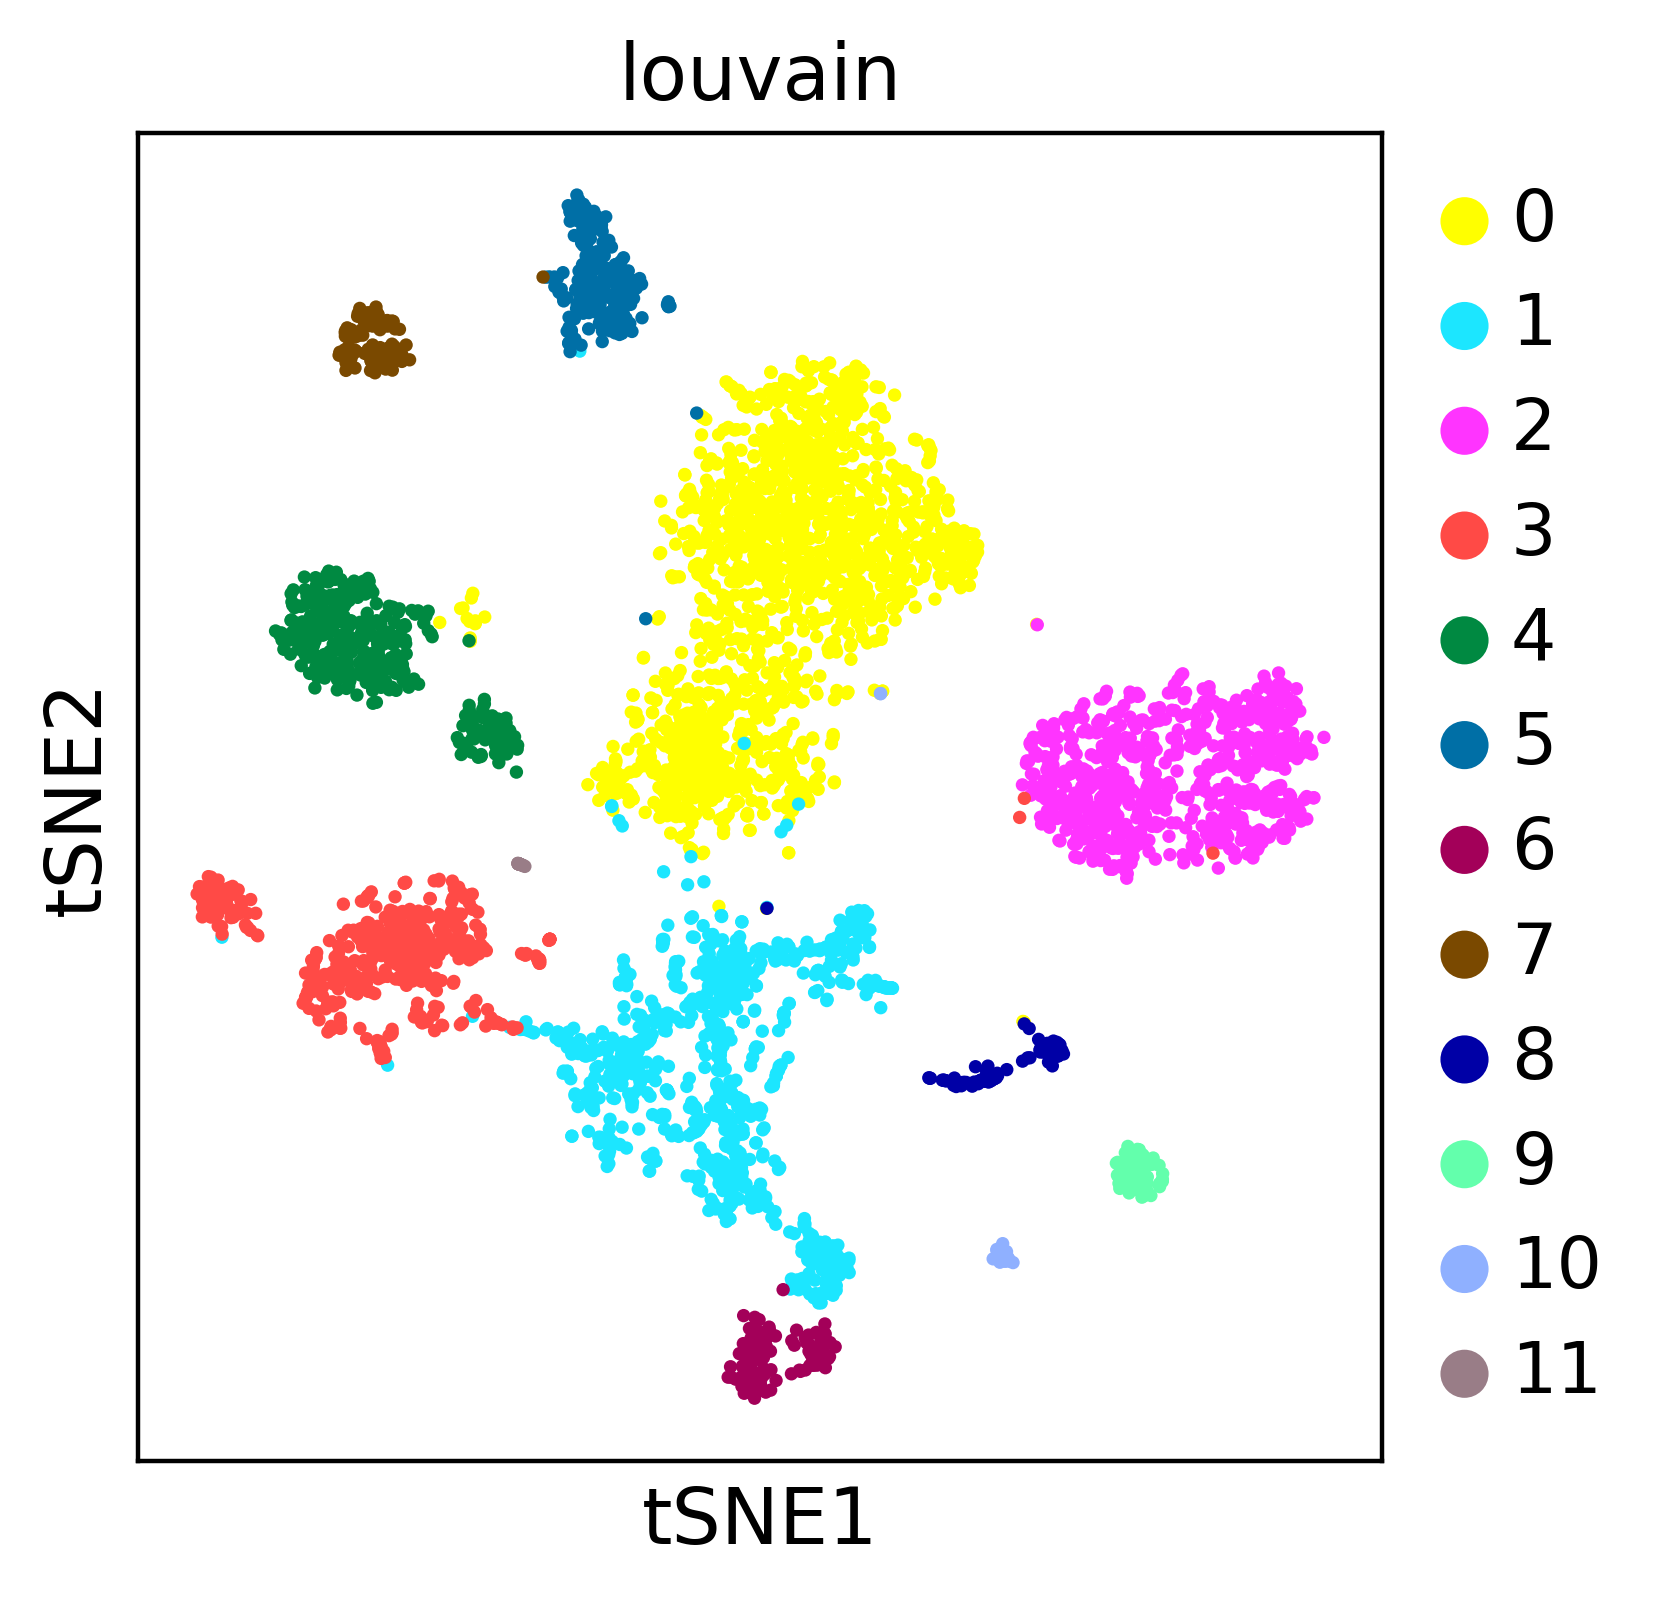

In [59]:
sc.pl.tsne(tiss, color=['louvain'],right_margin=0.5)

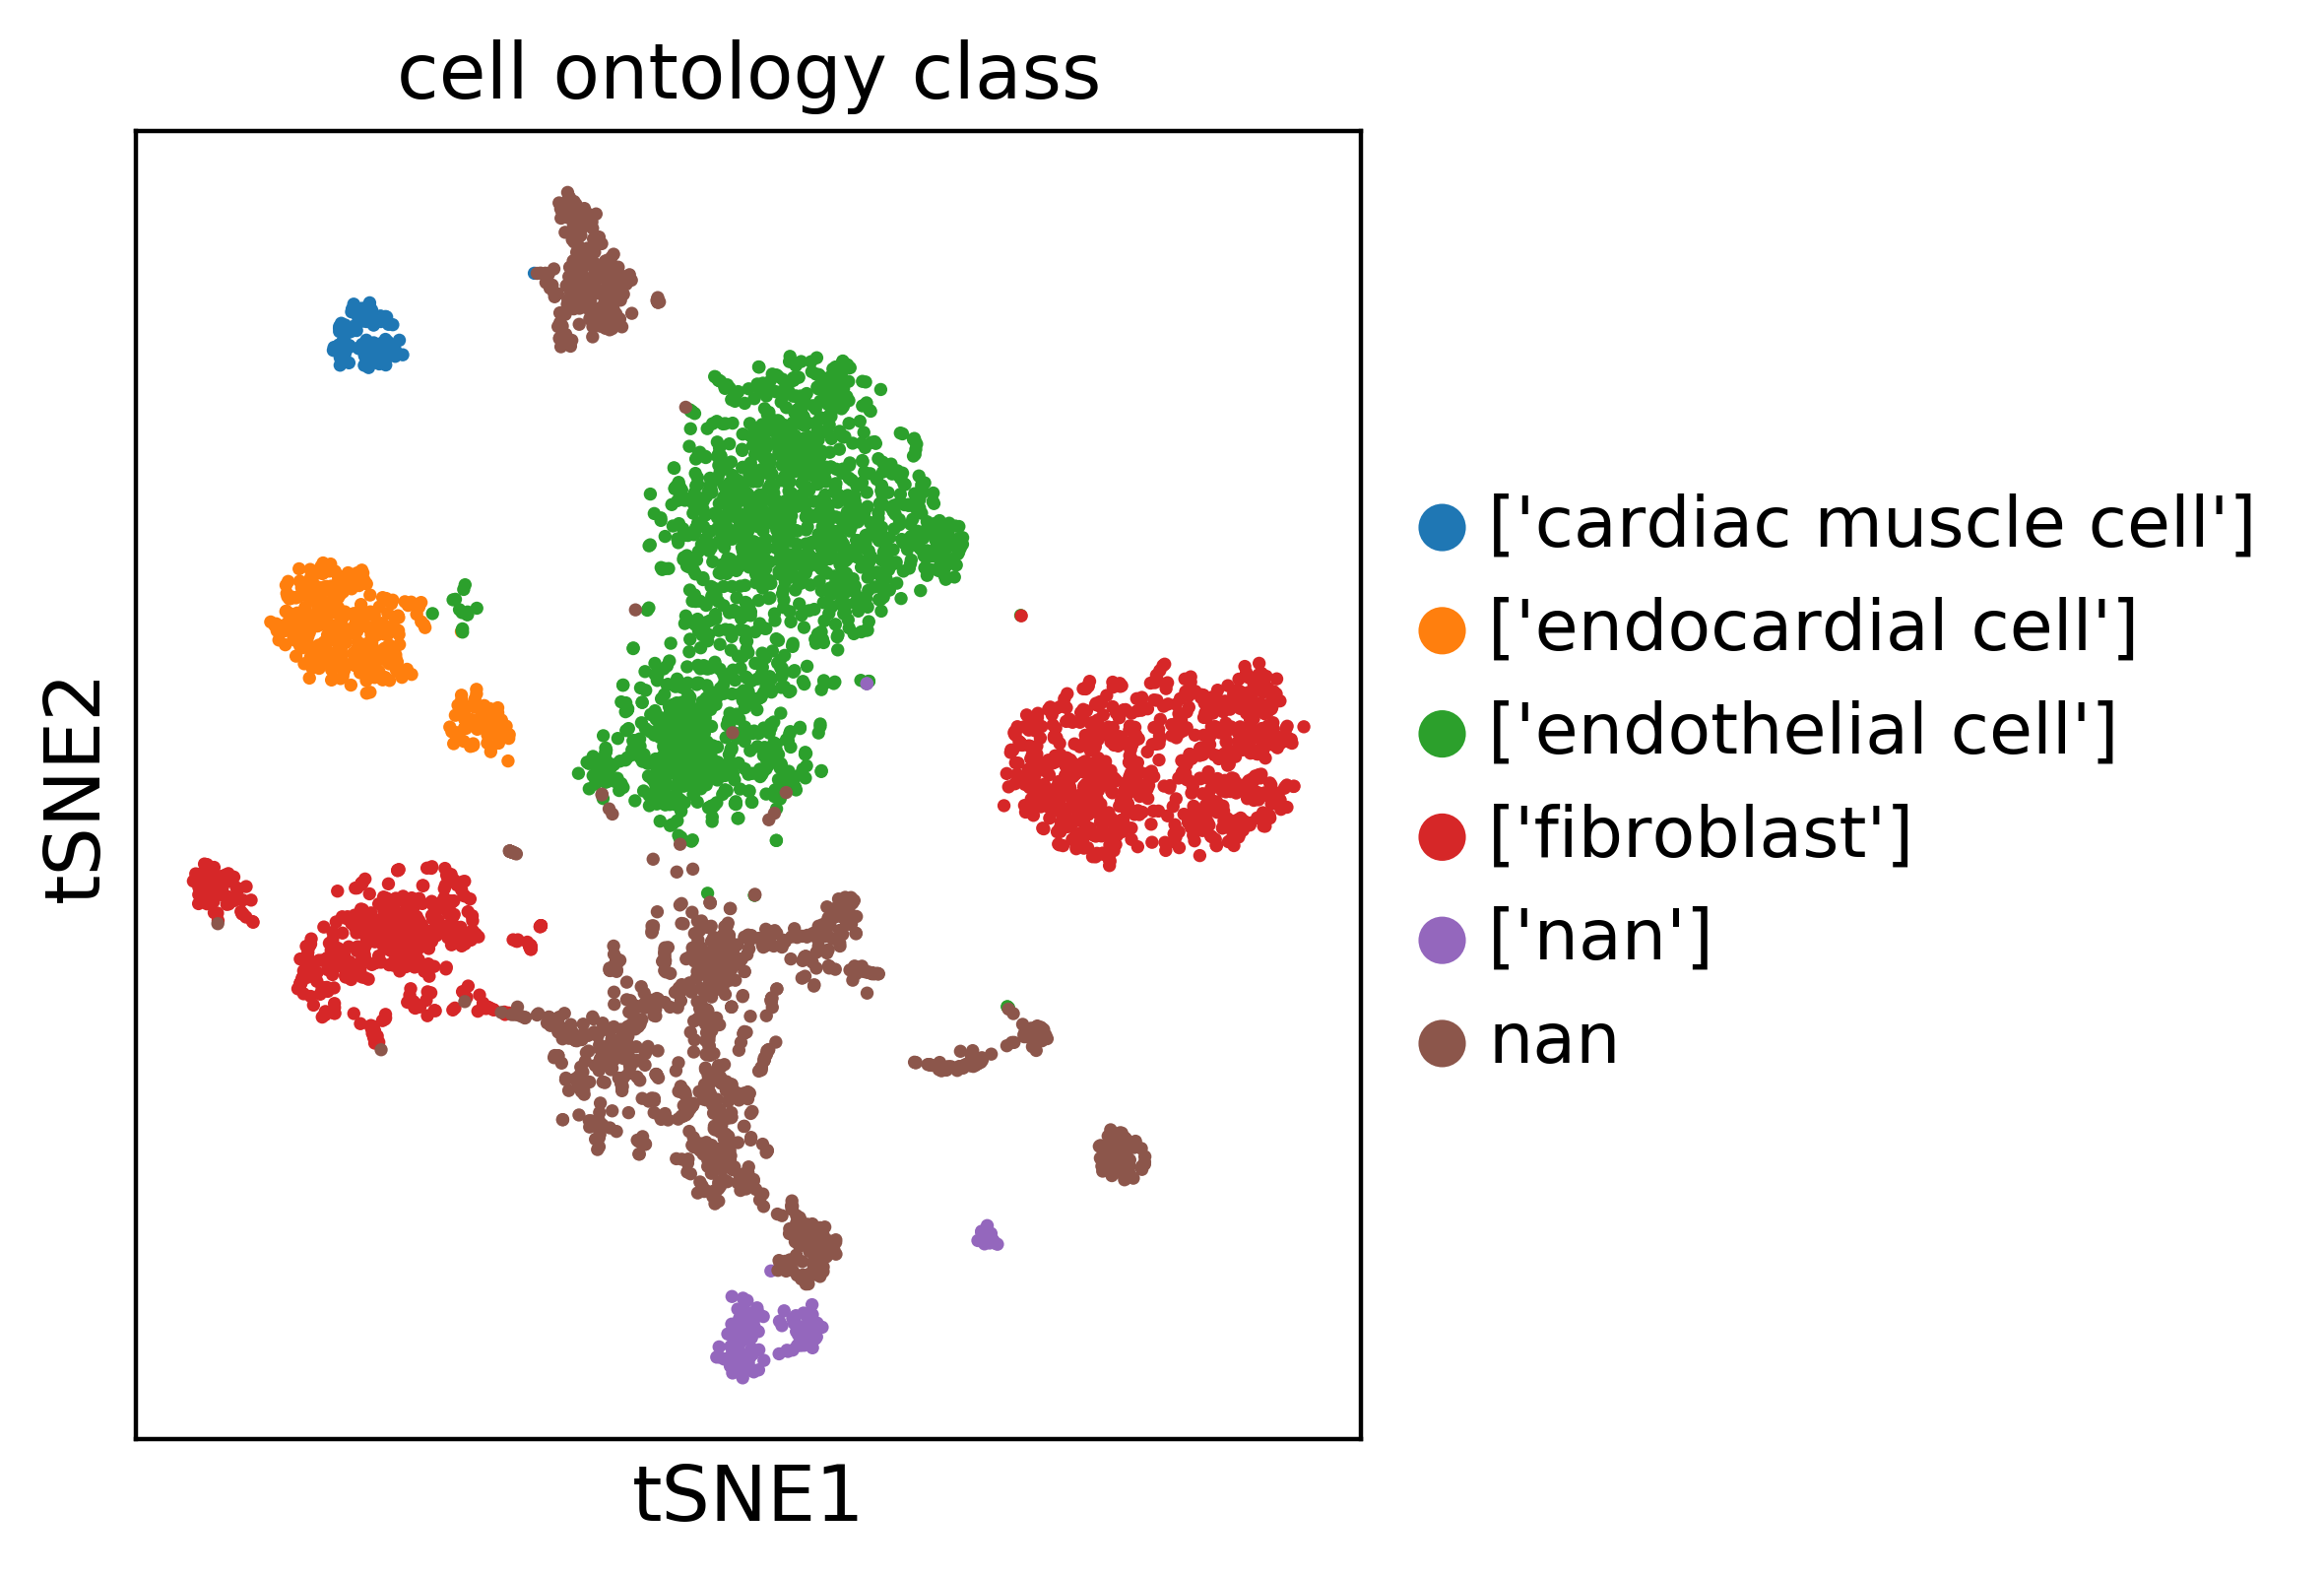

In [60]:
sc.pl.tsne(tiss, color=['cell_ontology_class'],right_margin=0.5)

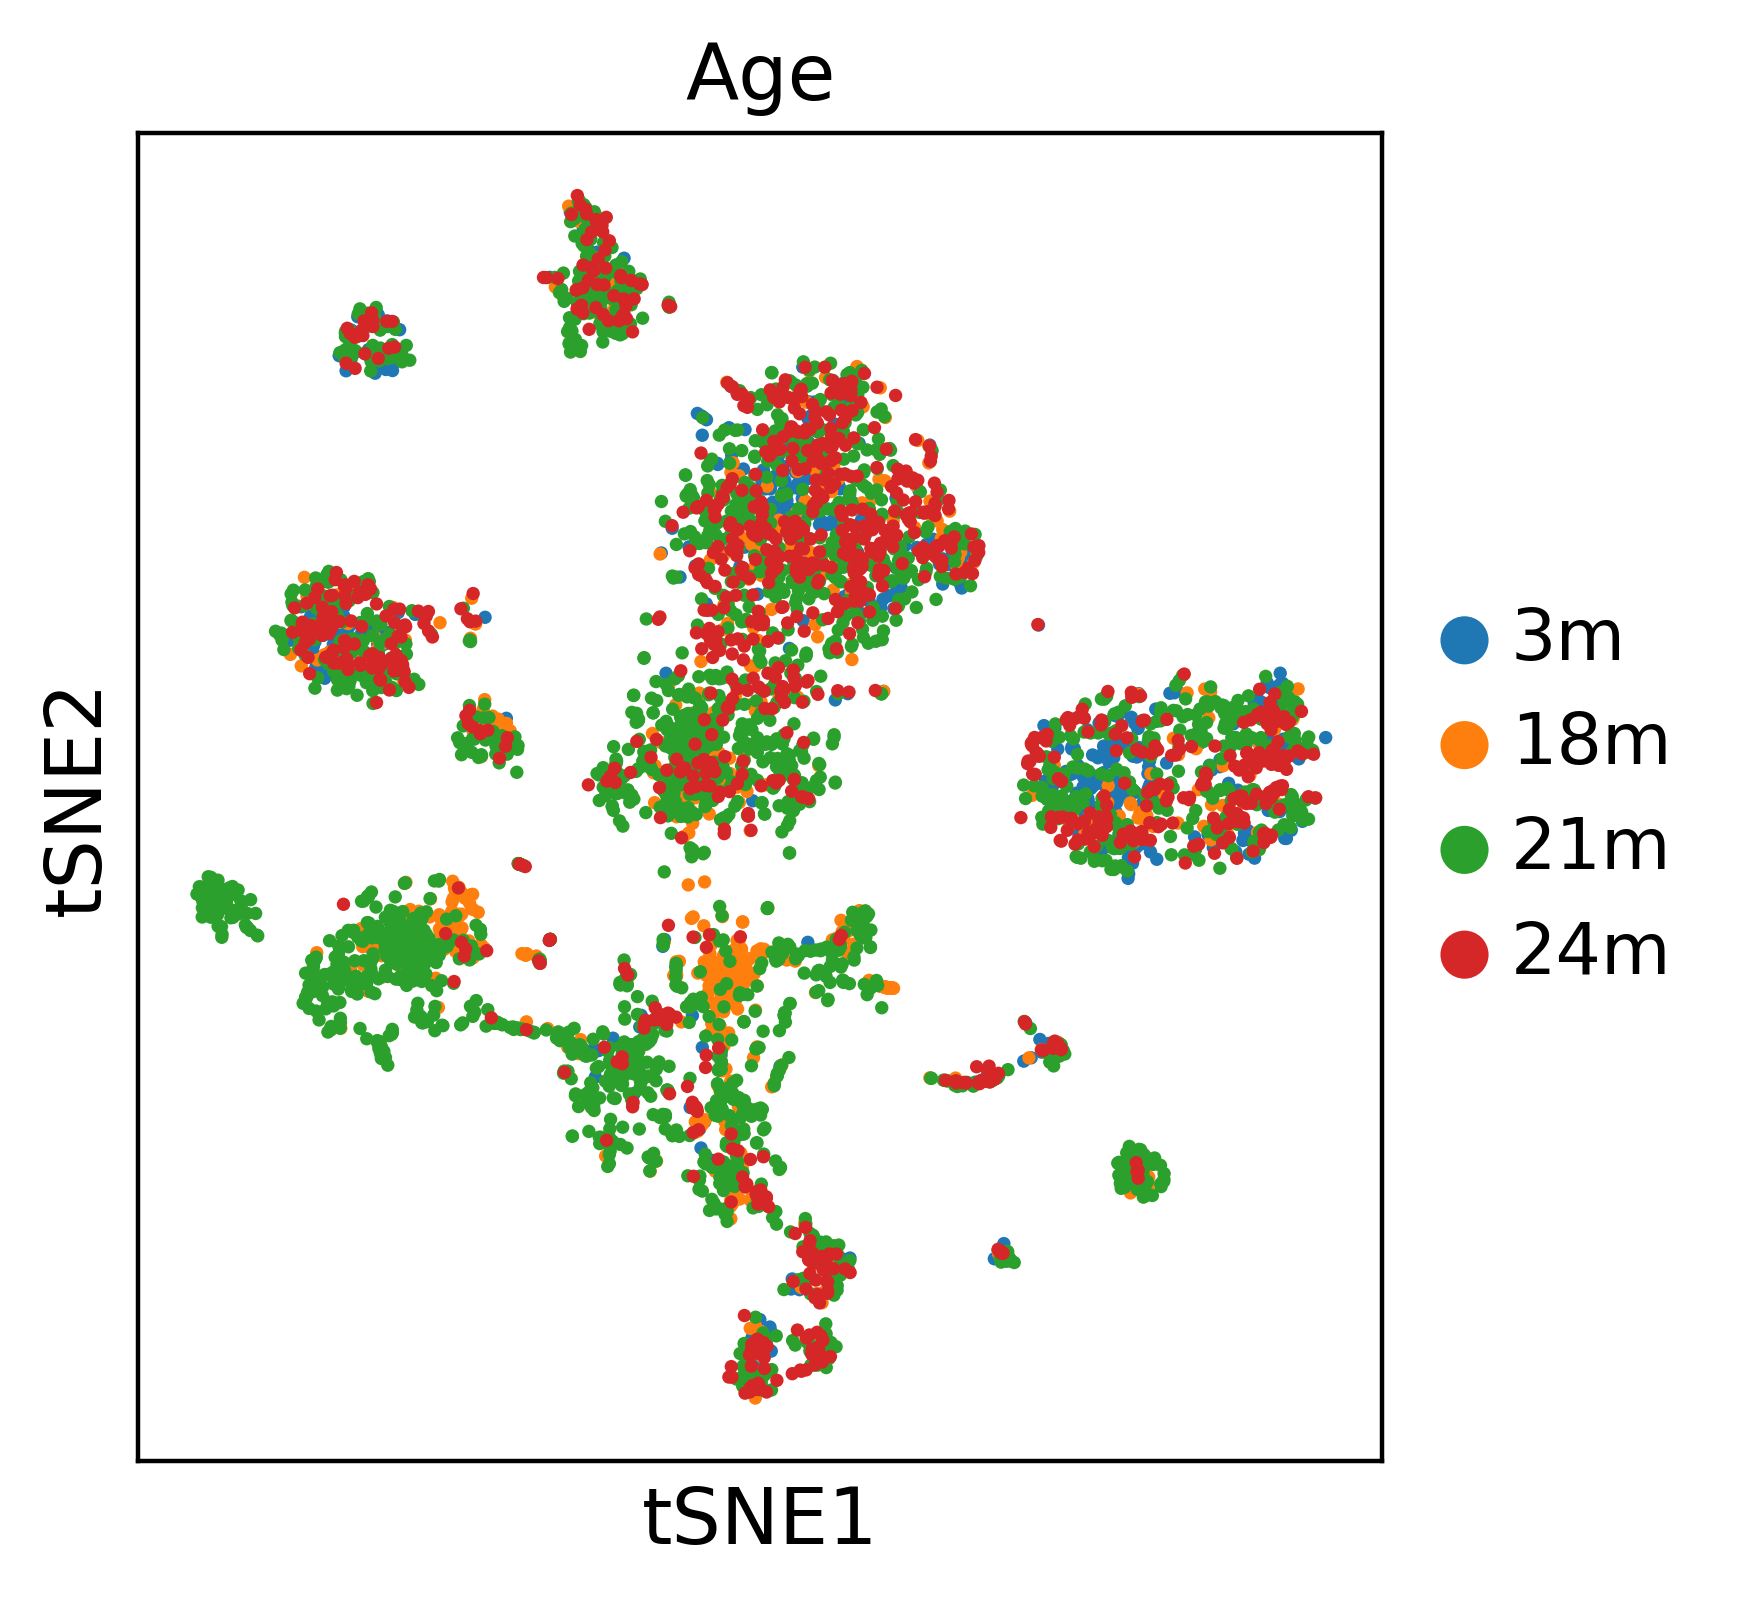

In [61]:
sc.pl.tsne(tiss, color=['Age'],right_margin=0.5)

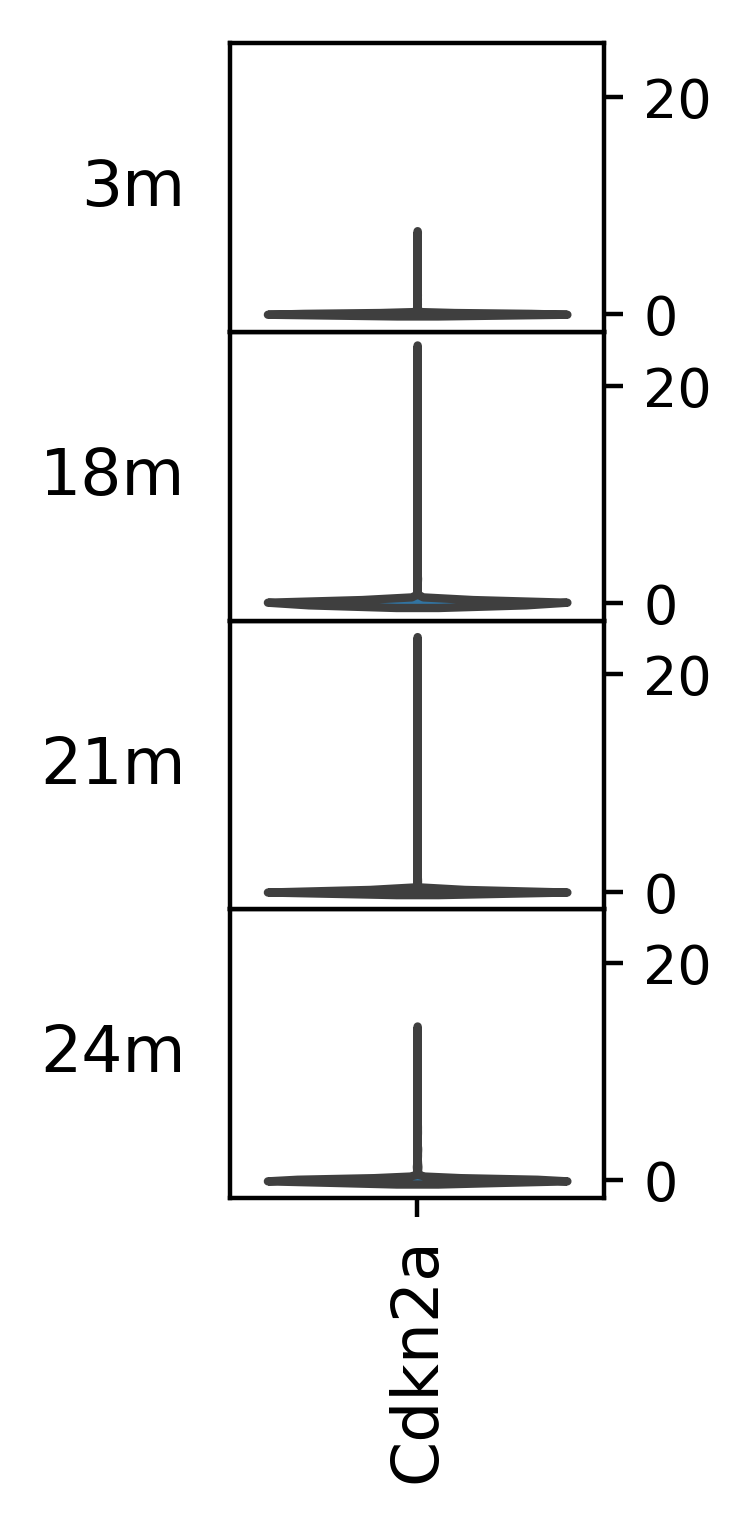

In [62]:
ax = sc.pl.stacked_violin(tiss, ['Cdkn2a'], groupby='Age')

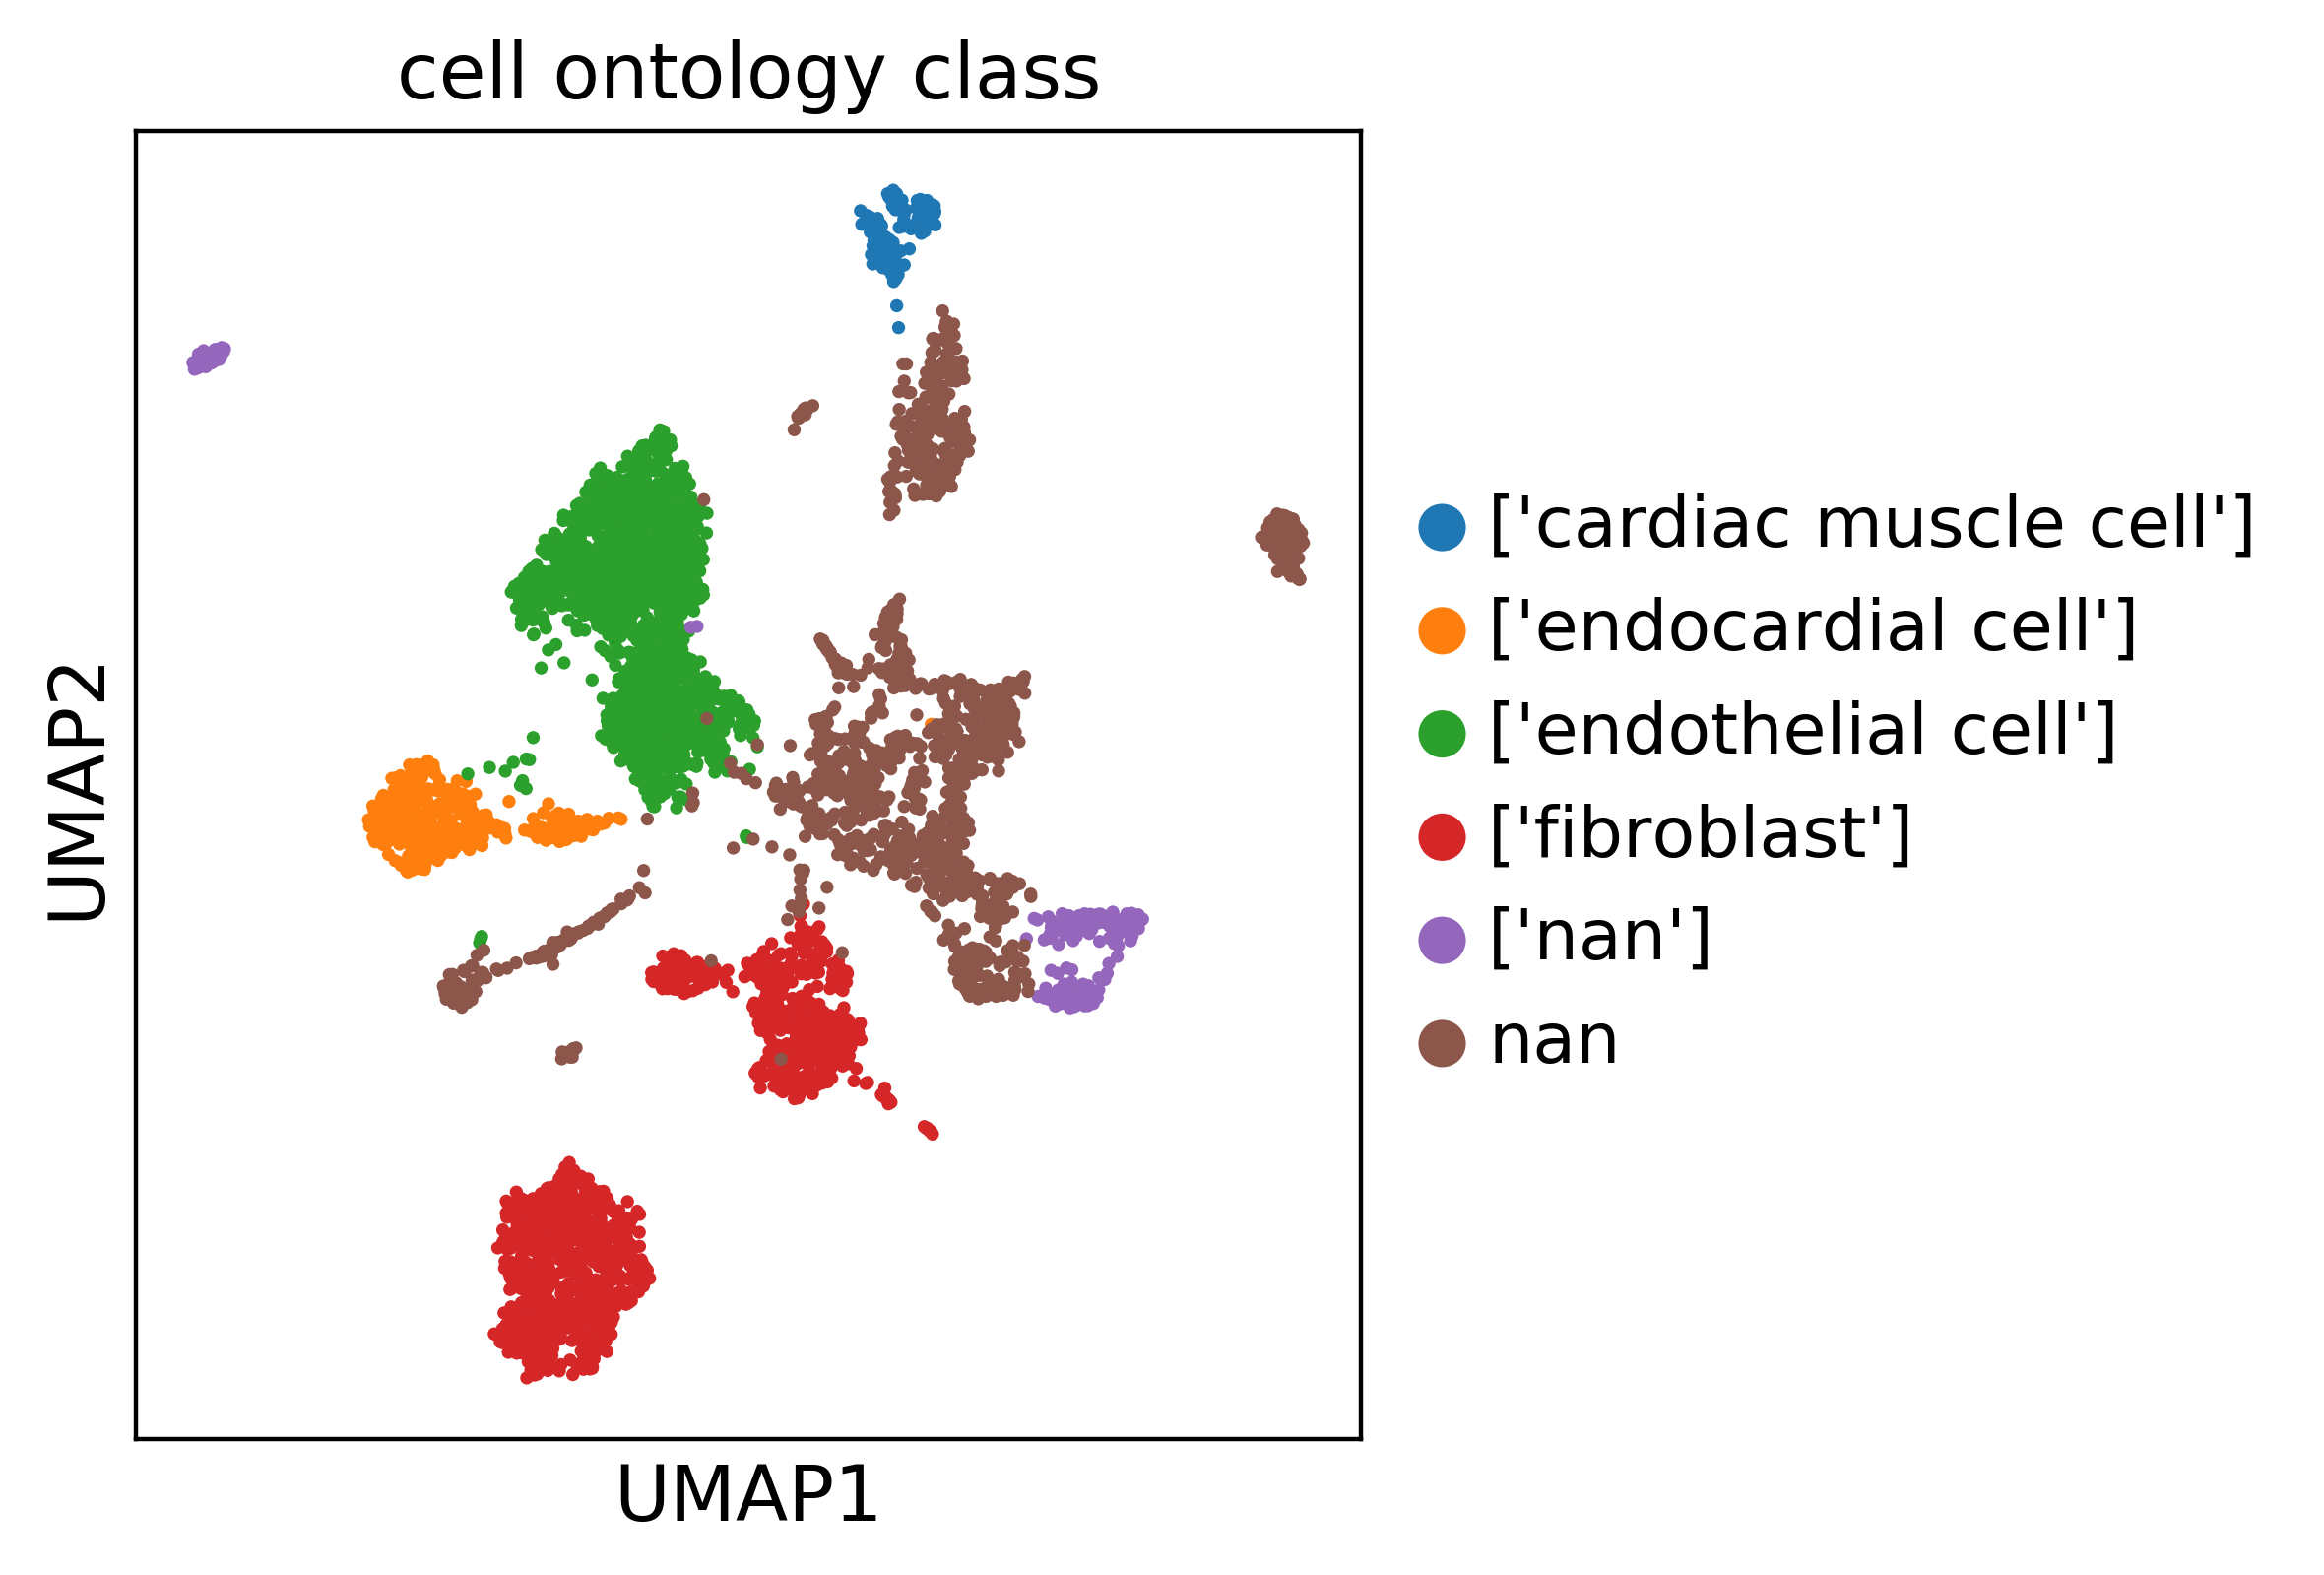

In [64]:
sc.pl.umap(tiss, color=['cell_ontology_class'],right_margin=0.5)

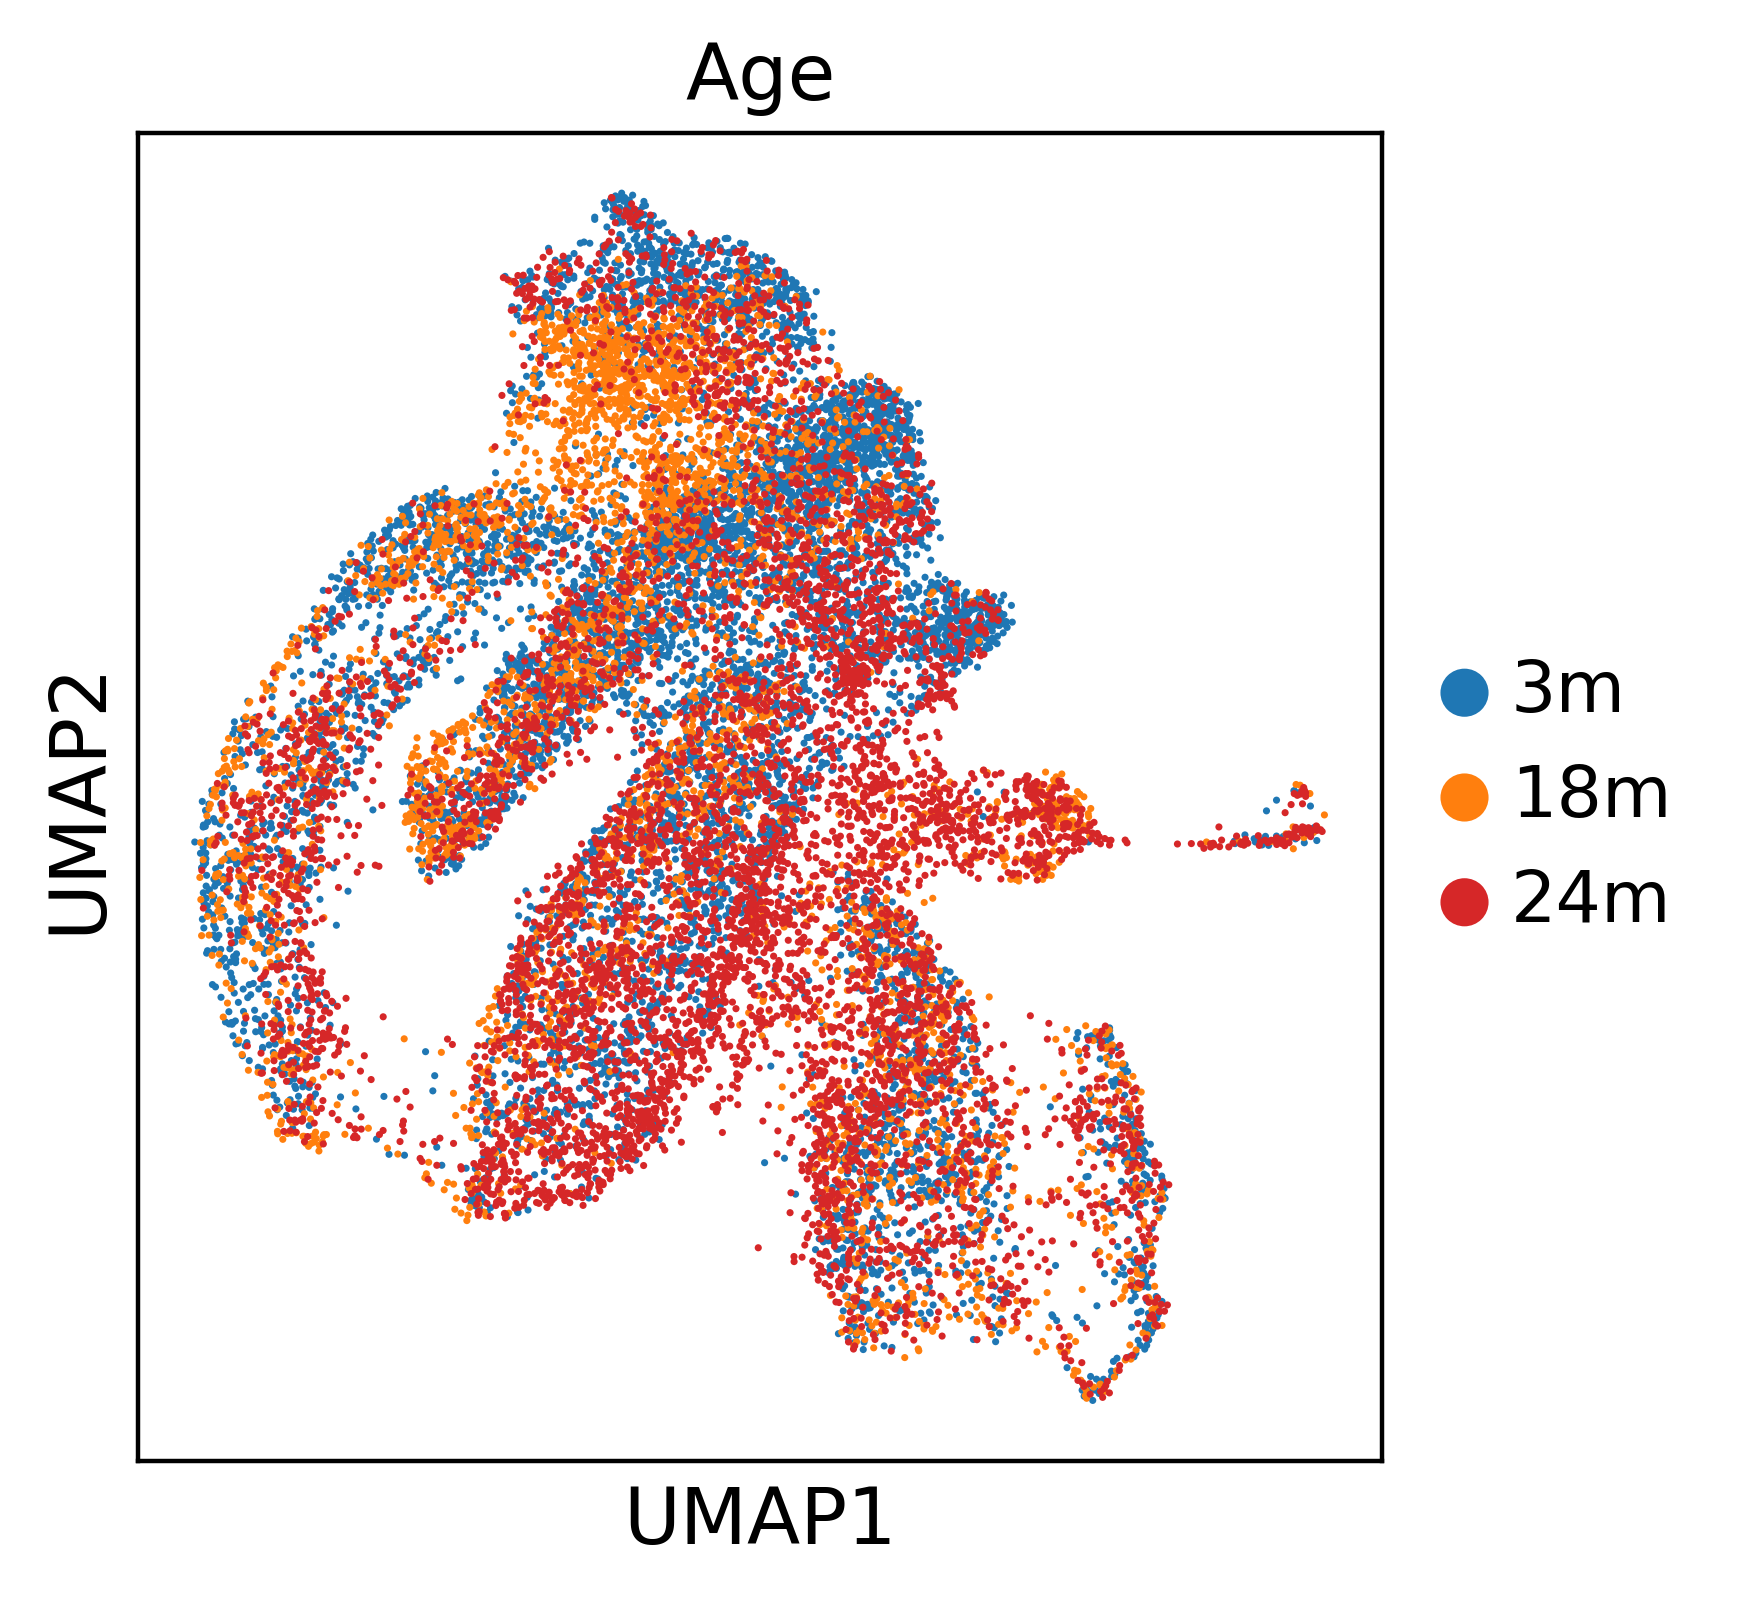

In [516]:
sc.pl.umap(tiss, color=['Age'],right_margin=0.5)

## finding marker genes

saving figure to file ./figures/rank_genes_groups_louvainlouvain_clusters_top_genes.pdf


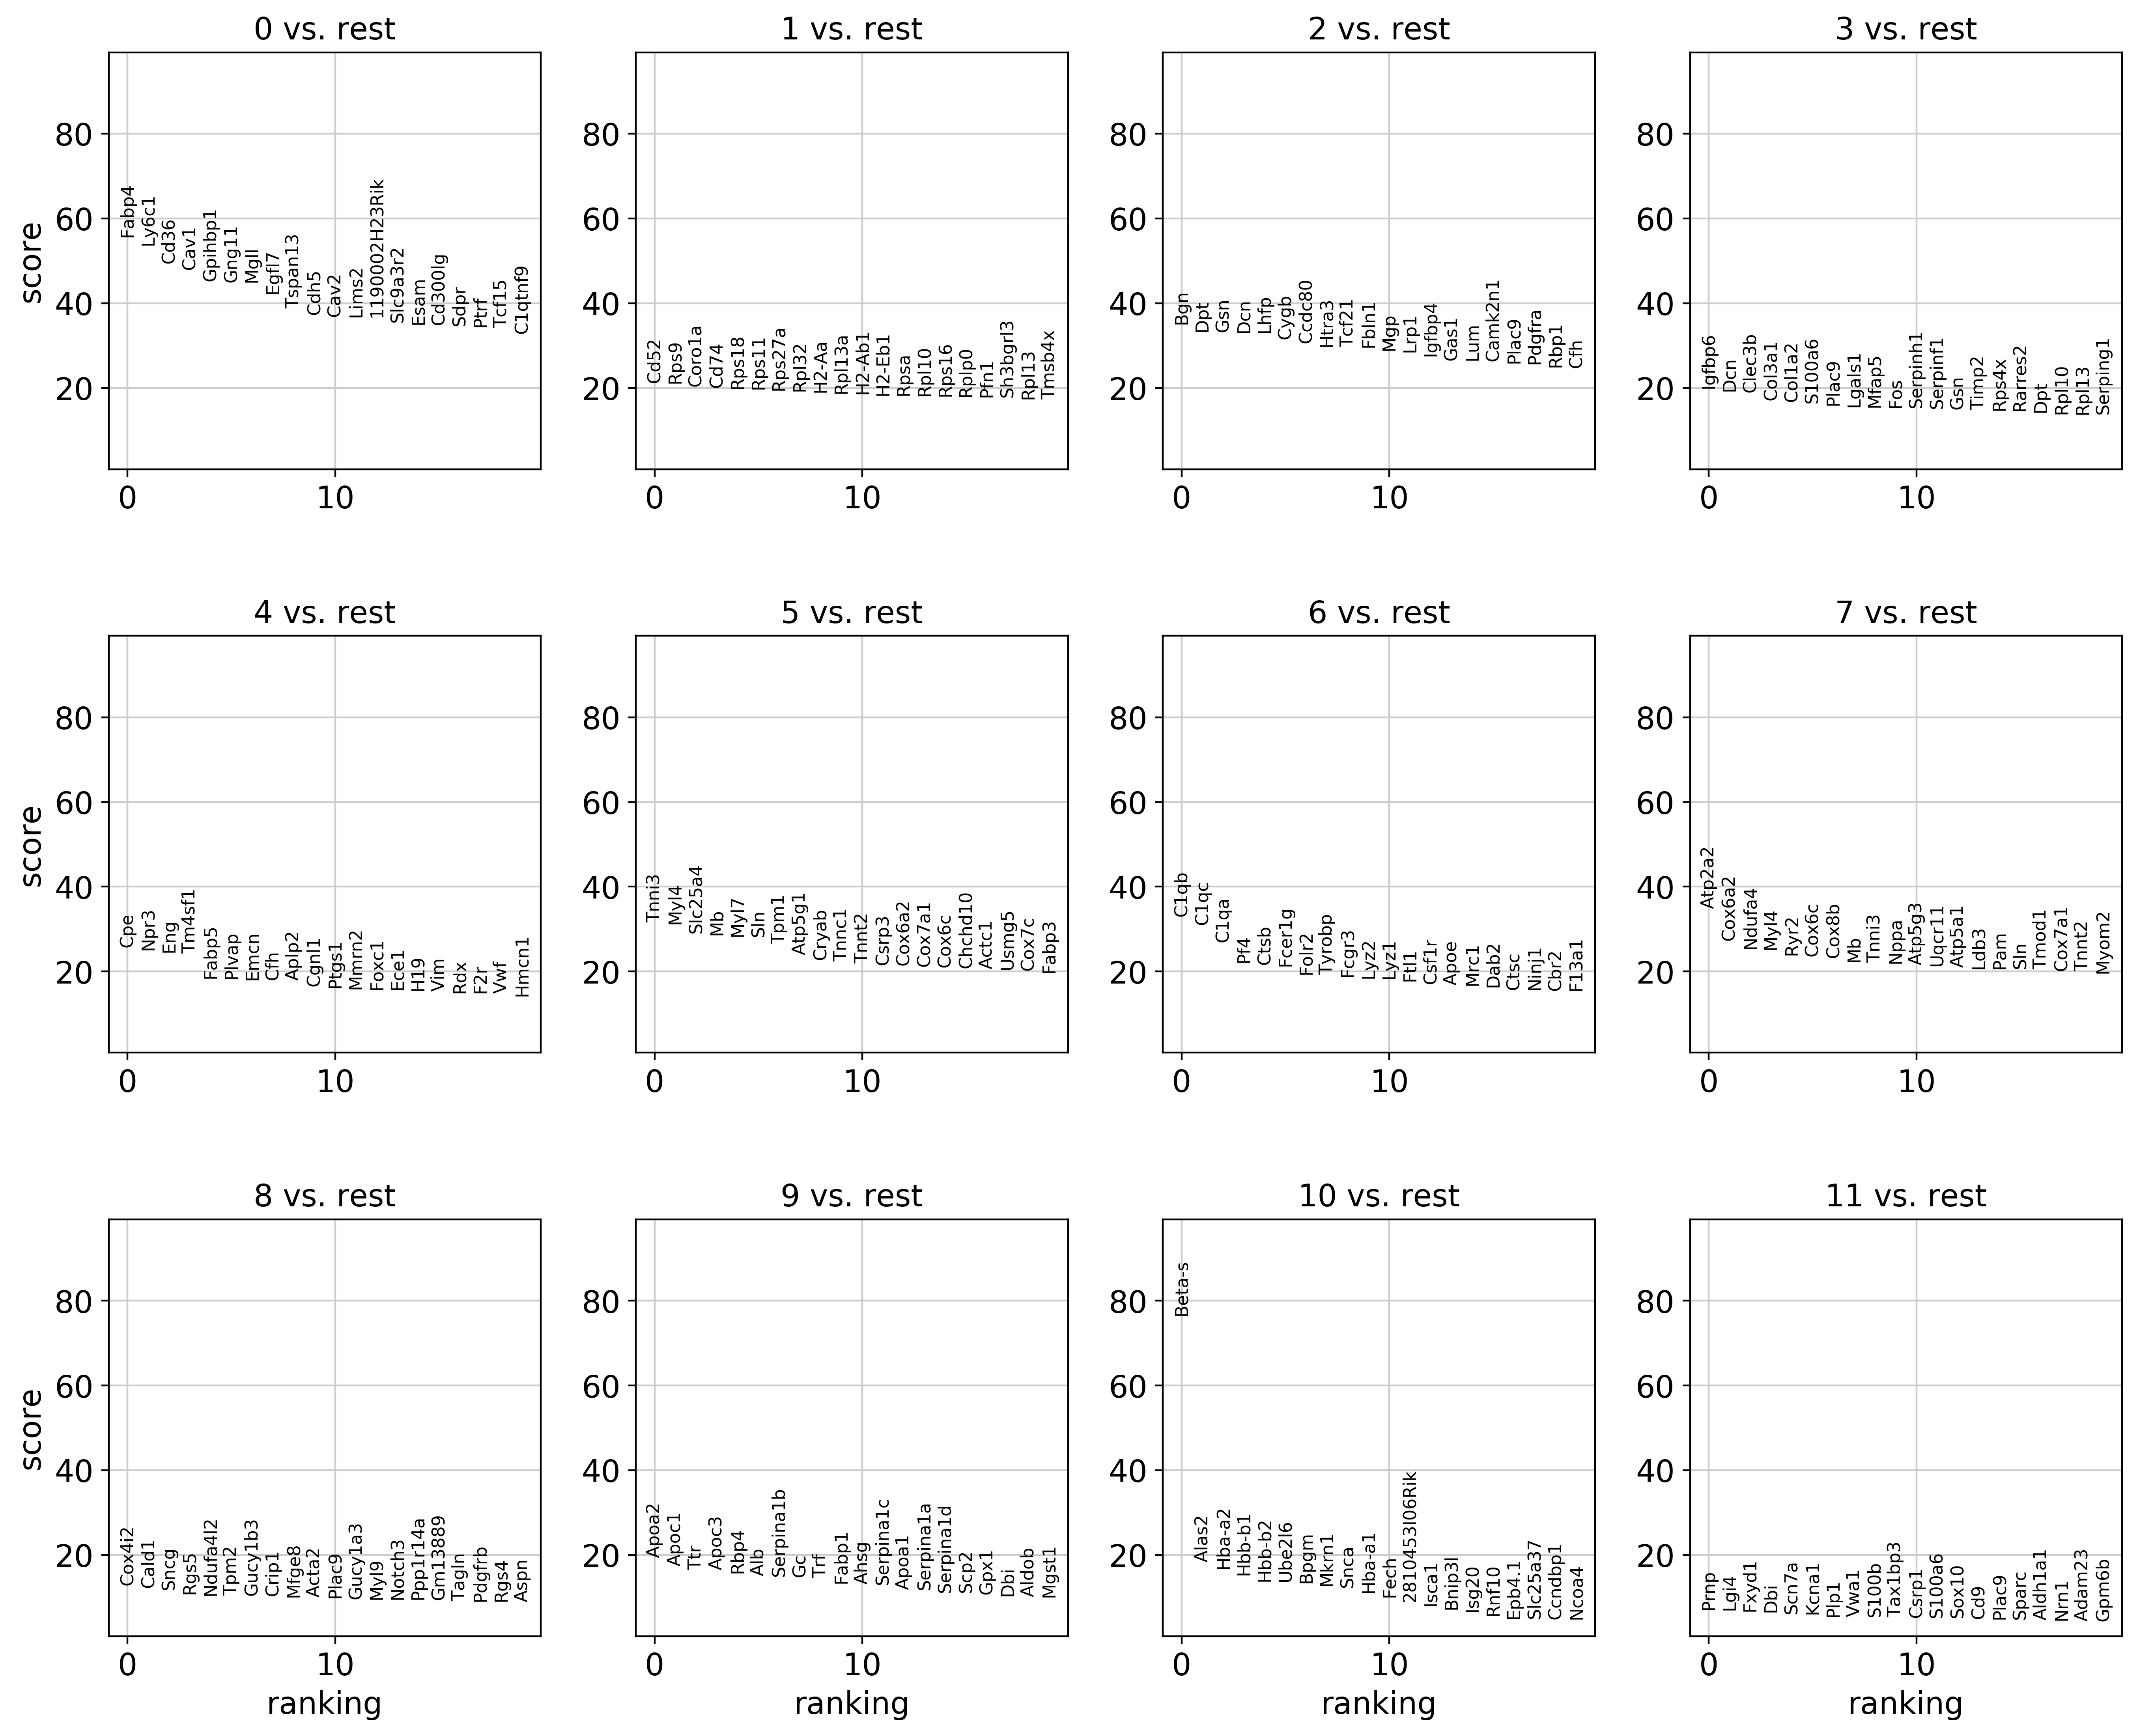

In [65]:
sc.tl.rank_genes_groups(tiss, 'louvain')
sc.pl.rank_genes_groups(tiss, n_genes=20, save='louvain_clusters_top_genes.pdf')
#adata.write(results_file)

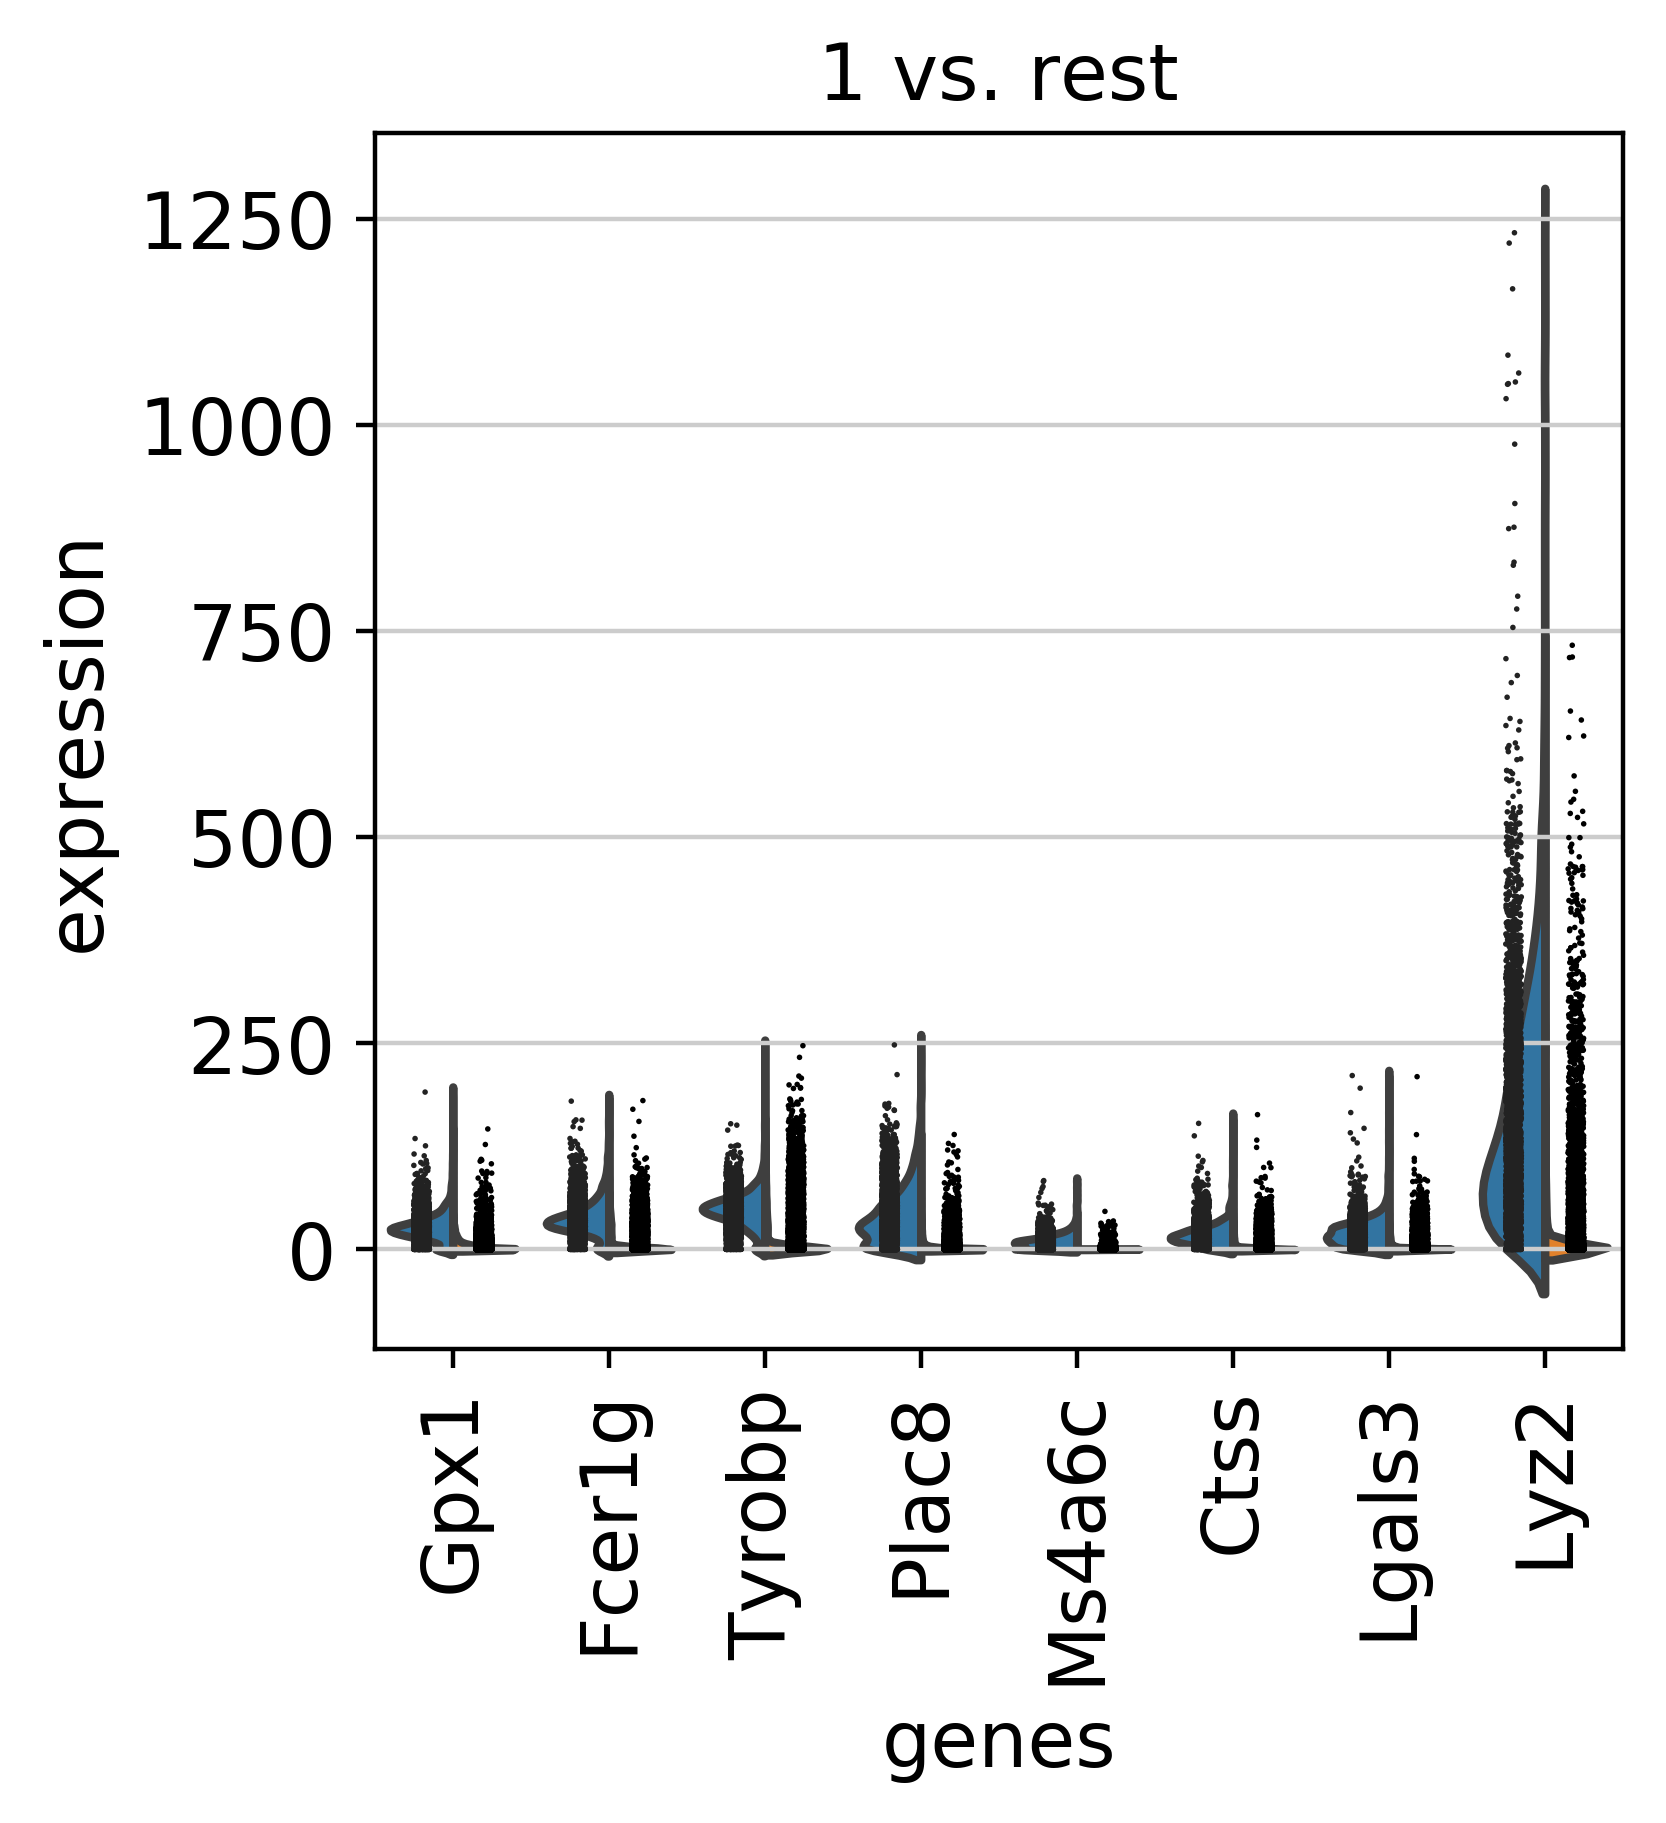

In [327]:
sc.pl.rank_genes_groups_violin(tiss, n_genes=8, groups=['1'])

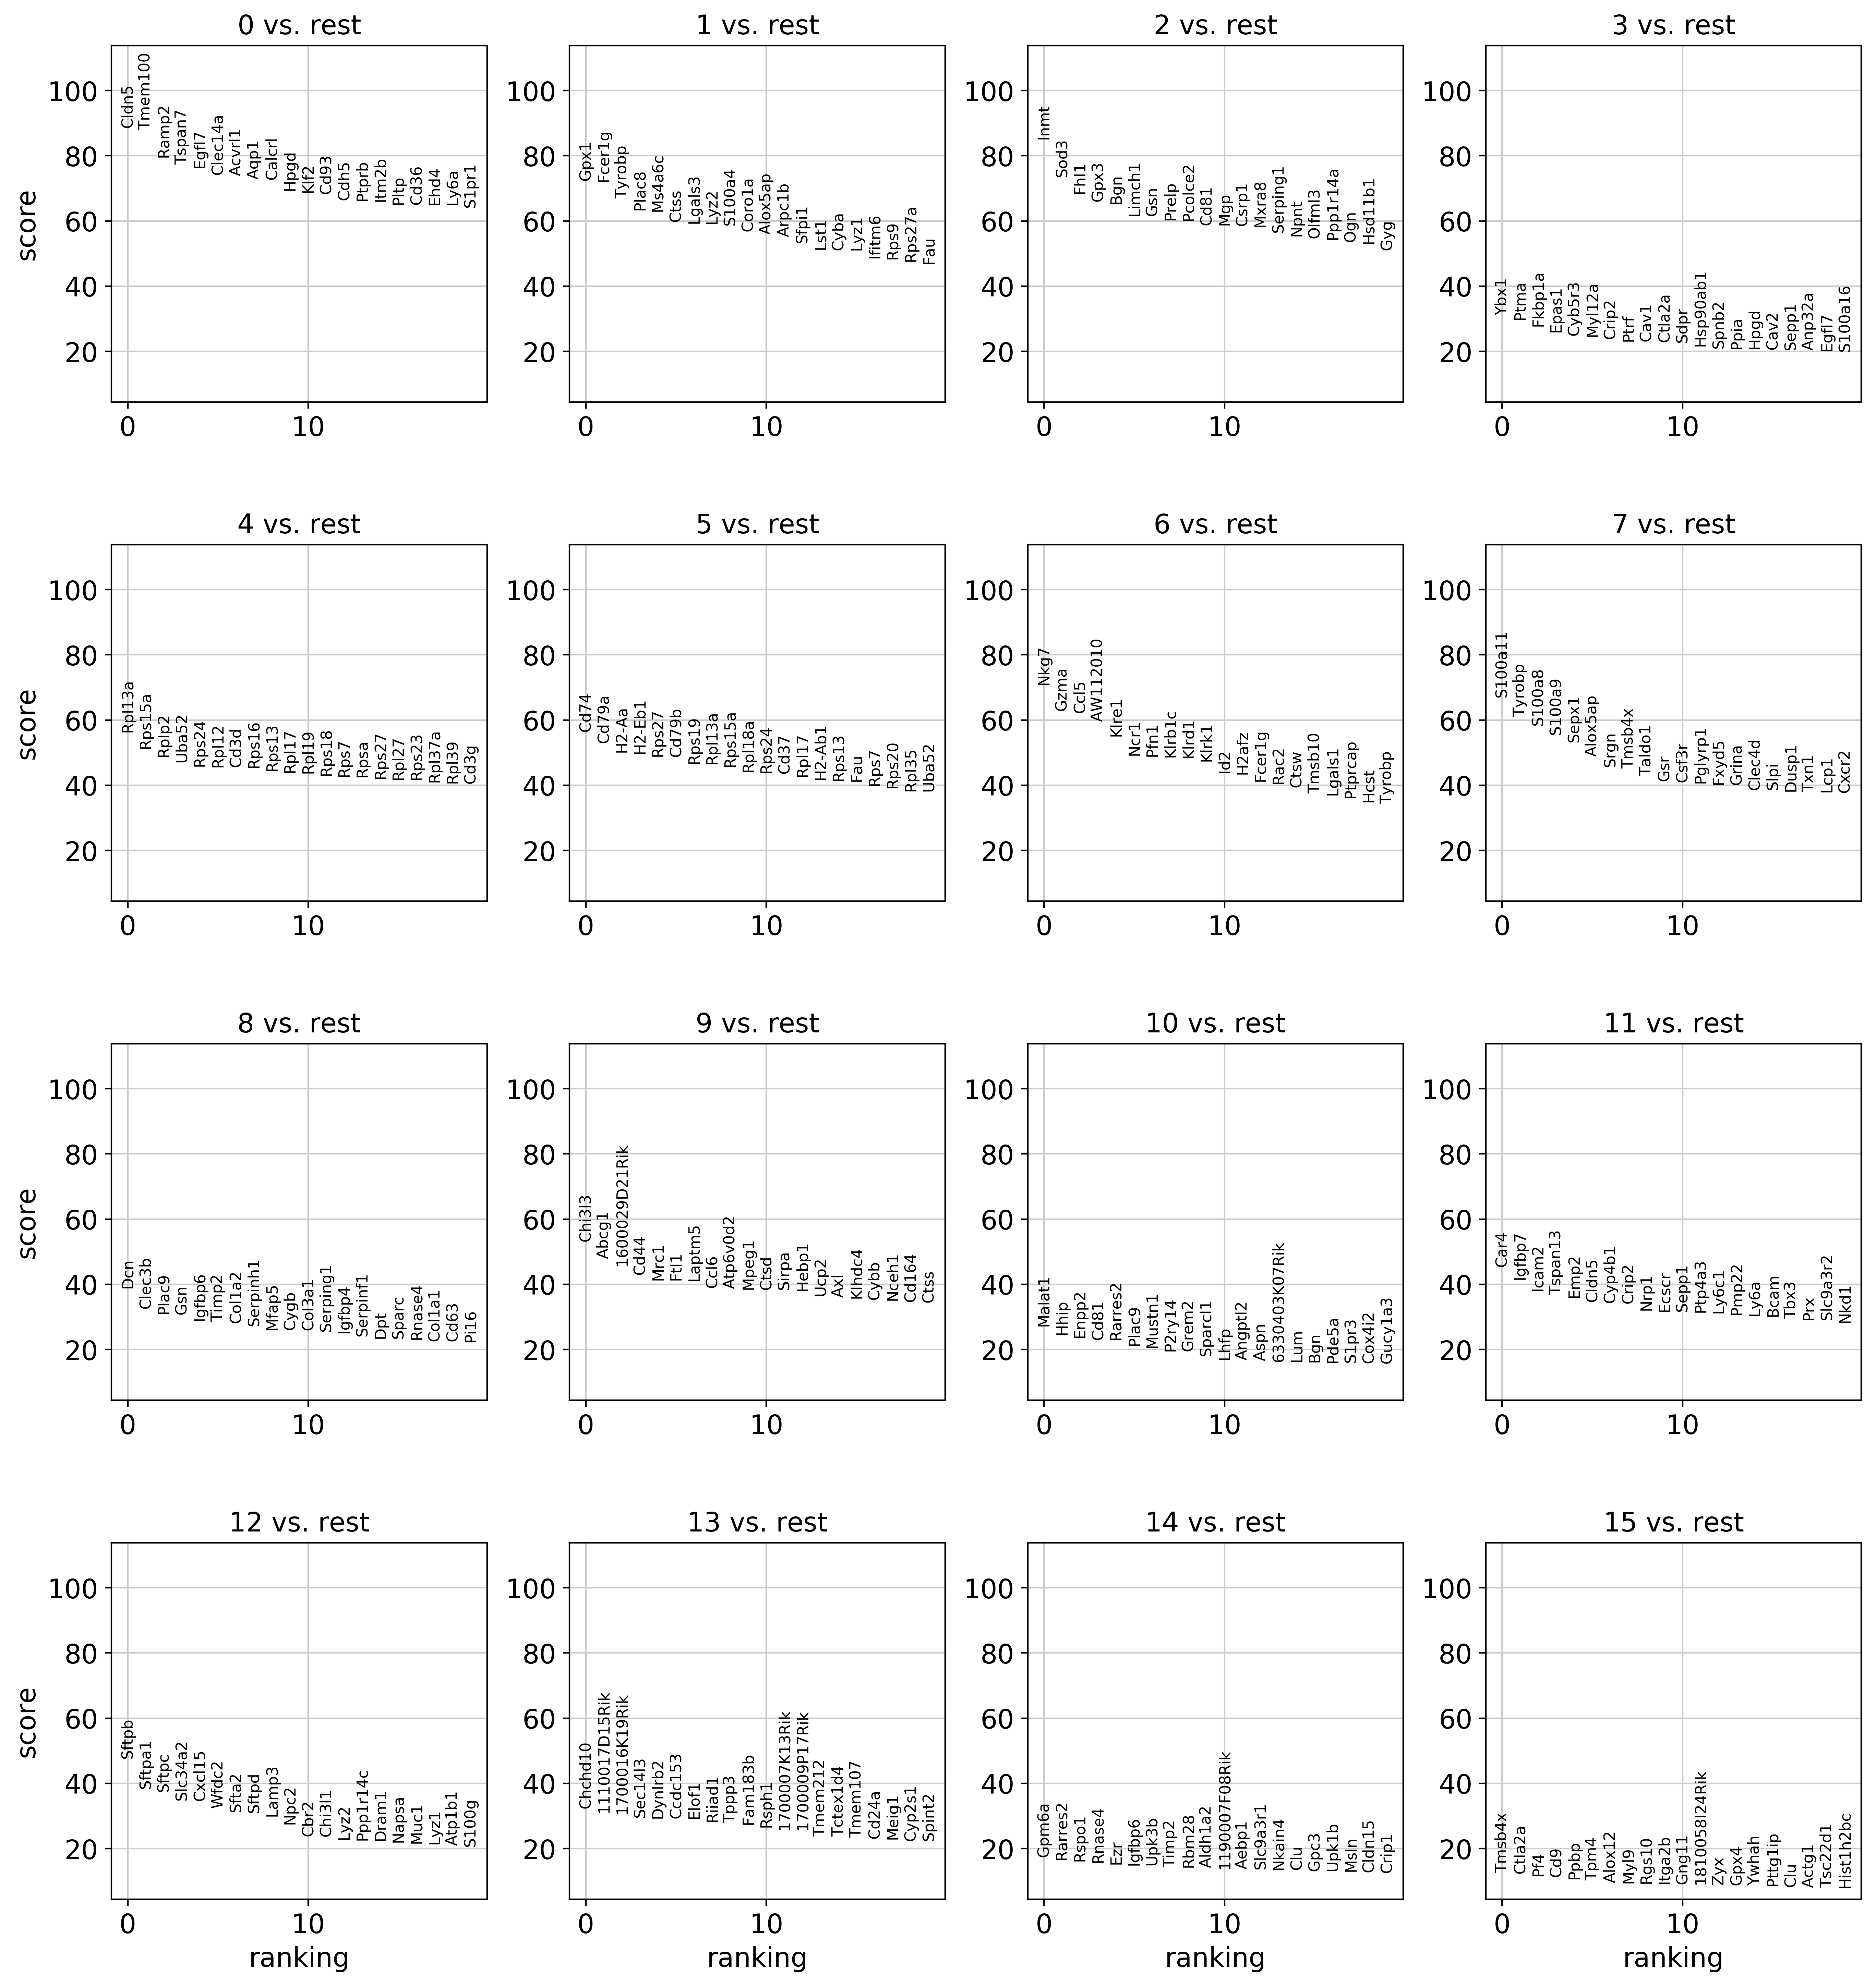

In [328]:
# sc.tl.rank_genes_groups(tiss, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(tiss, n_genes=20)

### Show the 10 top ranked genes per cluster in a dataframe.

In [329]:
pd.DataFrame(tiss.uns['rank_genes_groups']['names']).head(10)

0       1        2       3       4       5         6        7  \
0    Cldn5    Gpx1     Inmt    Ybx1  Rpl13a    Cd74      Nkg7  S100a11   
1  Tmem100  Fcer1g     Sod3    Ptma  Rps15a   Cd79a      Gzma   Tyrobp   
2    Ramp2  Tyrobp     Fhl1  Fkbp1a   Rplp2   H2-Aa      Ccl5   S100a8   
3   Tspan7   Plac8     Gpx3   Epas1   Uba52  H2-Eb1  AW112010   S100a9   
4    Egfl7  Ms4a6c      Bgn  Cyb5r3   Rps24   Rps27     Klre1    Sepx1   
5  Clec14a    Ctss   Limch1  Myl12a   Rpl12   Cd79b      Ncr1  Alox5ap   
6   Acvrl1  Lgals3      Gsn   Crip2    Cd3d   Rps19      Pfn1     Srgn   
7     Aqp1    Lyz2    Prelp    Ptrf   Rps16  Rpl13a    Klrb1c   Tmsb4x   
8   Calcrl  S100a4  Pcolce2    Cav1   Rps13  Rps15a     Klrd1   Taldo1   
9     Hpgd  Coro1a     Cd81  Ctla2a   Rpl17  Rpl18a     Klrk1      Gsr   

          8              9       10       11       12             13       14  \
0       Dcn         Chi3l3   Malat1     Car4    Sftpb        Chchd10    Gpm6a   
1    Clec3b          Abcg1     Hhip   Igfbp7   Sftpa1  1110017D15Rik  Rarres2   
2     Plac9  1600029D21Rik    Enpp2    Icam2    Sftpc  1700016K19Rik    Rspo1   
3       Gsn           Cd44     Cd81  Tspan13  Slc34a2        Sec14l3   Rnase4   
4    Igfbp6           Mrc1  Rarres2     Emp2   Cxcl15        Dynlrb2      Ezr   
5     Timp2           Ftl1    Plac9    Cldn5    Wfdc2        Ccdc153   Igfbp6   
6    Col1a2         Laptm5   Mustn1   Cyp4b1    Sfta2          Elof1    Upk3b   
7  Serpinh1           Ccl6   P2ry14    Crip2    Sftpd         Riiad1    Timp2   
8     Mfap5       Atp6v0d2    Grem2     Nrp1    Lamp3          Tppp3    Rbm28   
9      Cygb          Mpeg1  Sparcl1    Ecscr     Npc2        Fam183b  Aldh1a2   

       15  
0  Tmsb4x  
1  Ctla2a  
2     Pf4  
3     Cd9  
4    Ppbp  
5    Tpm4  
6  Alox12  
7    Myl9  
8   Rgs10  
9  Itga2b

### Get a table with scores and groups.



In [330]:
result = tiss.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

0_n        0_s     1_n        1_s   2_n        2_s     3_n        3_s  \
0    Cldn5  88.570618    Gpx1  72.384956  Inmt  85.126801    Ybx1  31.135742   
1  Tmem100  87.959557  Fcer1g  72.128952  Sod3  73.454742    Ptma  29.702051   
2    Ramp2  79.567612  Tyrobp  66.982018  Fhl1  68.454231  Fkbp1a  27.771120   
3   Tspan7  77.333748   Plac8  63.371429  Gpx3  65.994576   Epas1  25.979841   
4    Egfl7  76.272903  Ms4a6c  62.939182   Bgn  65.297989  Cyb5r3  24.863312   

      4_n        4_s    ...         11_n       11_s     12_n       12_s  \
0  Rpl13a  56.356106    ...         Car4  45.392147    Sftpb  47.602997   
1  Rps15a  51.249294    ...       Igfbp7  41.552380   Sftpa1  38.384293   
2   Rplp2  48.745205    ...        Icam2  38.084972    Sftpc  37.443550   
3   Uba52  47.114815    ...      Tspan13  36.783543  Slc34a2  34.809185   
4   Rps24  45.792469    ...         Emp2  35.901306   Cxcl15  34.654392   

            13_n       13_s     14_n       14_s    15_n       15_s  
0        Chchd10  32.357327    Gpm6a  17.467037  Tmsb4x  12.578192  
1  1110017D15Rik  30.966356  Rarres2  16.588436  Ctla2a  12.437191  
2  1700016K19Rik  30.632891    Rspo1  16.159048     Pf4  11.607166  
3        Sec14l3  29.520374   Rnase4  15.750690     Cd9  11.343161  
4        Dynlrb2  29.324017      Ezr  15.213679    Ppbp  10.659460  

[5 rows x 32 columns]

In [ ]:
sc.pl.violin(tiss, ['Cdkn2a','Myoc','Gpx3'],groupby='Age', rotation=90)#, save='.pdf')

In [ ]:

sc.pl.violin(tiss[tiss.obs['Age']=='3m',:], ['Cdkn2a'],groupby='cell_ontology_class',rotation=90)#, save='.pdf')


In [ ]:
sc.pl.violin(tiss[tiss.obs['Age']=='18m',:], ['Cdkn2a'],groupby='cell_ontology_class', rotation=90)#, save='.pdf')


In [ ]:
sc.pl.violin(tiss[tiss.obs['Age']=='21m',:], ['Cdkn2a'],groupby='cell_ontology_class', rotation=90)#, save='.pdf')


In [ ]:
sc.pl.violin(tiss[tiss.obs['Age']=='24m',:], ['Cdkn2a'],groupby='cell_ontology_class', rotation=90)#, save='.pdf')


In [66]:
def _build_subplots(n):
    '''
    Build subplots grid
    n: number of subplots
    '''
    nrow = int(np.sqrt(n))
    ncol = int(np.ceil(n / nrow))
    fig, axs = plt.subplots(nrow, ncol, dpi=100, figsize=(ncol*5, nrow*5))
    fig.subplots_adjust(hspace=.9)

    return fig, axs, nrow, ncol

In [67]:
list(set(tiss.obs['Age']))

['24m', '21m', '18m', '3m']

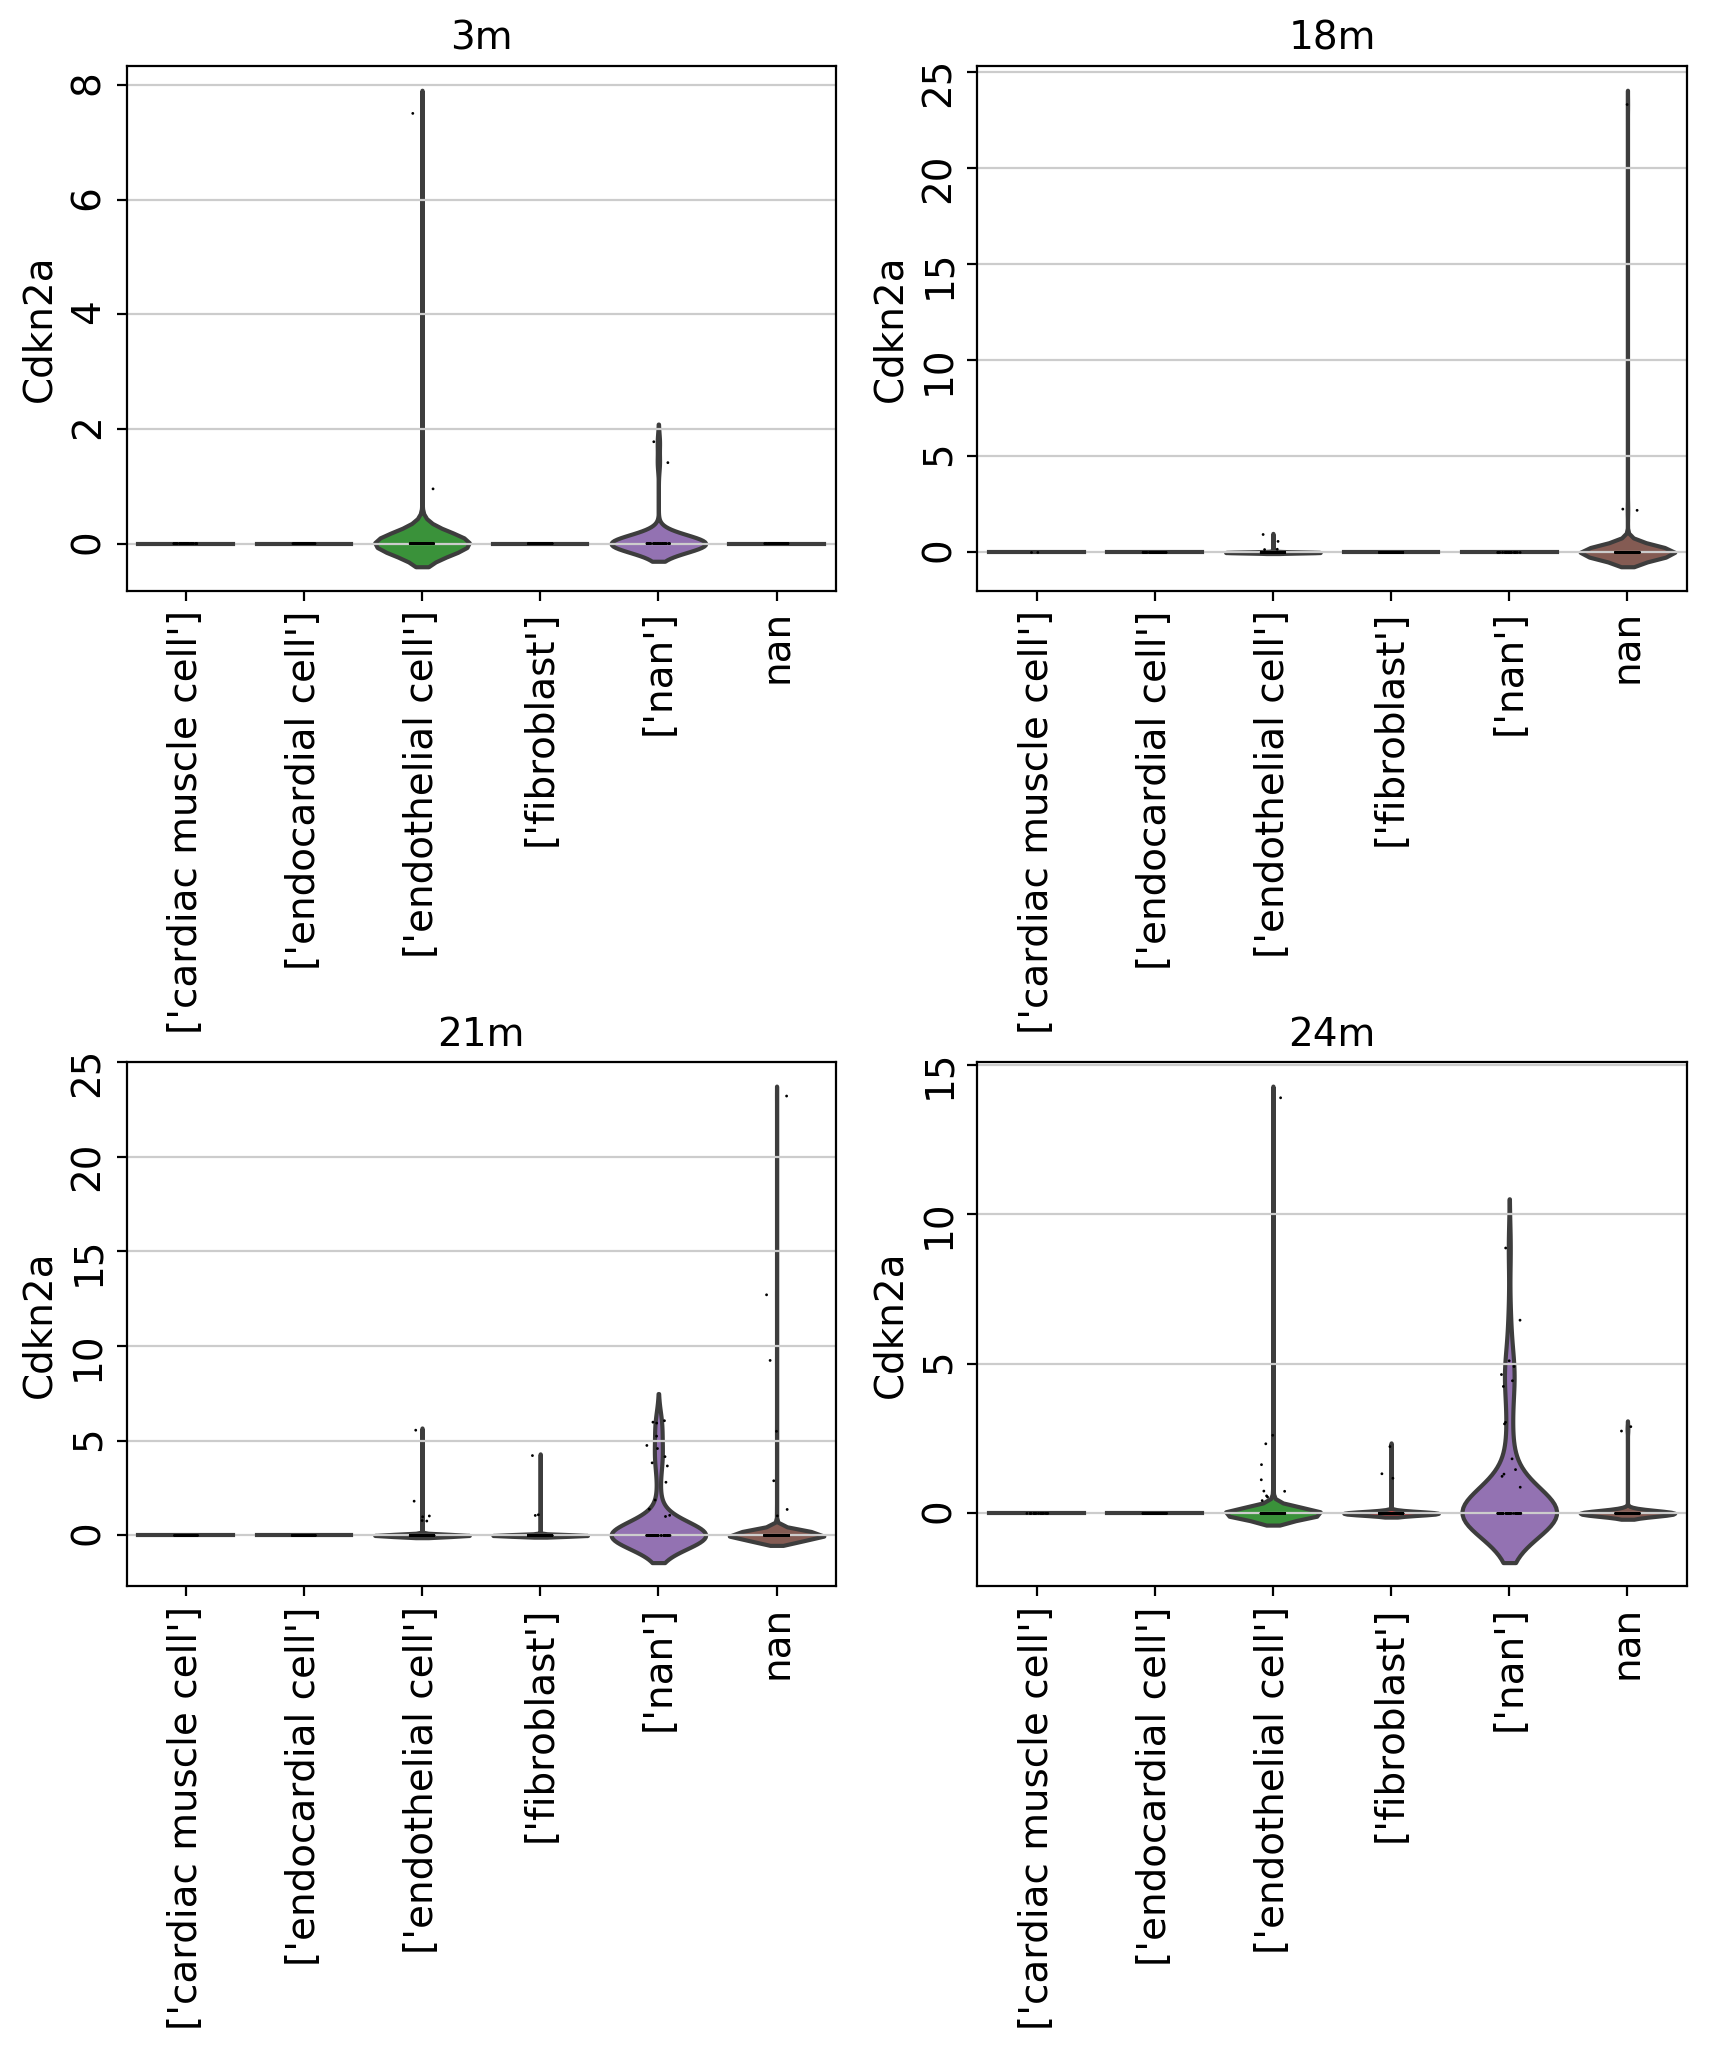

In [68]:
ages = ['3m','18m','21m','24m']#

fig, axs, nrow, ncol = _build_subplots(len(ages))

axs = axs.ravel()

for i in range(nrow*ncol):
    age = ages[i]
    axs[i].set_title(ages[i])
    sc.pl.violin(tiss[tiss.obs['Age']==ages[i],:], ['Cdkn2a'],
                 groupby='cell_ontology_class', 
                 rotation=90,
                 ax=axs[i],show=False)

# fig.savefig('figures/%s_p16.pdf' % tissofinterest, bbox_inches='tight')

In [ ]:
sc.pl.scatter(n_genes, n_cells,color='Age', rotation=90)#, save='.pdf')


In [ ]:
sc.tl.rank_genes_groups(tiss, 'cell_ontology_class')
sc.pl.rank_genes_groups(tiss, n_genes=20, save='cell_types_top_genes.pdf')

In [ ]:
sc.tl.rank_genes_groups(tiss, 'Age')
sc.pl.rank_genes_groups(tiss, n_genes=20, save='age_top_genes.pdf')

### subset for cell ontology

In [ ]:
tiss.obs[tiss.obs['cell_ontology_class'] == tiss.obs['cell_ontology_class'][1]].head()

In [ ]:
subtiss = tiss[tiss.obs['cell_ontology_class'] == tiss.obs['cell_ontology_class'][3],:]
sc.tl.rank_genes_groups(subtiss, 'Age', groups=['24m'], reference='3m')#, method='logreg')
sc.pl.rank_genes_groups(subtiss, n_genes=20, groups=['24m'], save='subtiss_louvain_clusters_top_genes.pdf')

In [ ]:
sc.pl.rank_genes_groups(subtiss, n_genes=20, save='subtiss_louvain_clusters_top_genes.pdf')

## Force-directed graph

In [ ]:
sc.tl.draw_graph(tiss) # be patient here...

In [ ]:
sc.pl.draw_graph(tiss, color=['Tissue'])

In [ ]:
sc.pl.draw_graph(tiss, color=['Age'])

In [ ]:
sc.pl.draw_graph(tiss, color=['Sex'])

In [ ]:
sc.pl.draw_graph(tiss, color=['louvain'])

# coming soon: Pseudotime analysis

In [ ]:
# sc.pp.neighbors(adata)


In [ ]:
# sc.tl.diffmap(adata)

In [ ]:
# sc.tl.dpt(adata, n_branchings=1)

In [ ]:
#sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups', 'age'])

In [ ]:
#sc.pl.diffmap(adata, color=['dpt_pseudotime'])

In [ ]:
#sc.pl.diffmap(adata, color=['dpt_groups'])

In [ ]:
#sc.pl.diffmap(adata, color=['Age'])

# Save processed data

In [ ]:
# adata.write('./write/maca.processed.h5ad')